In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [20]:
# Shared Generator Layers
class SharedGeneratorLayers(nn.Module):
    def __init__(self):
        super(SharedGeneratorLayers, self).__init__()
        self.main = nn.Sequential(
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.main(x)
        return x

In [21]:
# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, shared_layers):
        super(Generator, self).__init__()
        self.fc = nn.Linear(latent_dim, 256)
        self.shared_layers = shared_layers

    def forward(self, z):
        x = self.fc(z)
        x = self.shared_layers(x)
        return x

In [22]:
# Shared Discriminator and Classifier Layers
class SharedDiscriminatorClassifierLayers(nn.Module):
    def __init__(self):
        super(SharedDiscriminatorClassifierLayers, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3)
        )

    def forward(self, x):
        x = self.main(x)
        return x

In [23]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, shared_layers):
        super(Discriminator, self).__init__()
        self.shared_layers = shared_layers
        self.fc = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.shared_layers(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

In [24]:
# Classifier
class Classifier(nn.Module):
    def __init__(self, shared_layers, num_generators):
        super(Classifier, self).__init__()
        self.shared_layers = shared_layers
        self.fc = nn.Linear(256, num_generators)

    def forward(self, x):
        x = self.shared_layers(x)
        x = self.fc(x)
        return x

In [25]:
import matplotlib.pyplot as plt


def generate_and_plot(generators, latent_dim, device):
    num_generators = len(generators)  # Get the number of generators
    images_per_generator = 5  # Set how many images to display per generator
    fig, axes = plt.subplots(num_generators, images_per_generator, figsize=(images_per_generator * 2, num_generators * 2))
    
    # Loop through each generator and generate samples
    for gen_idx, generator in enumerate(generators):
        generator.eval()  # Set the generator to evaluation mode
        with torch.no_grad():
            # Generate latent vectors for the generator
            z = torch.randn(images_per_generator, latent_dim, device=device)
            generated_images = generator(z).cpu().numpy()  # Generate images and move them to CPU for plotting

        # Visualize the images generated by this generator
        for img_idx in range(images_per_generator):
            ax = axes[gen_idx, img_idx]
            
            # If the generated images are flattened (like MNIST), reshape them
            image = generated_images[img_idx]
            
            if image.shape == (784,):  # For MNIST, where images are flattened
                image = image.reshape(28, 28)  # Reshape to 28x28 for grayscale images
            
            # If working with RGB, ensure image has the shape (height, width, channels)
            elif len(image.shape) == 1 and image.size == 784 * 3:  # Example for flattened RGB
                image = image.reshape(28, 28, 3)  # Reshape to (28, 28, 3) for RGB
            
            ax.imshow(image, cmap='gray' if image.ndim == 2 else None)  # Use 'gray' cmap for grayscale
            ax.set_title(f"Generator {gen_idx + 1}")  # Label the image with the generator index
            ax.axis('off')  # Turn off the axis

    plt.tight_layout()
    plt.show()


In [26]:
def train_mgans(generators, discriminator, classifier, train_loader, latent_dim, num_epochs, beta, device, visualize_frequency):
    criterion_bce = nn.BCELoss()
    criterion_ce = nn.CrossEntropyLoss()

    # Collect generator parameters
    gen_params = []
    for gen in generators:
        gen_params += list(gen.fc.parameters())
    gen_params += list(generators[0].shared_layers.parameters())  # Shared layers are the same

    optimizer_G = optim.Adam(gen_params, lr=0.0002, betas=(0.5, 0.999))

    # Discriminator and Classifier params
    dc_params = list(discriminator.shared_layers.parameters()) + \
                list(discriminator.fc.parameters()) + \
                list(classifier.fc.parameters())
    optimizer_DC = optim.Adam(dc_params, lr=0.0002, betas=(0.5, 0.999))

    # History to track losses
    history = {'d_loss': [], 'g_loss': [], 'c_loss': []}

    for epoch in range(num_epochs):
        for batch_idx, (real_images, _) in enumerate(train_loader):
            # Prepare real images
            real_images = real_images.view(-1, 28 * 28).to(device)
            batch_size_real = real_images.size(0)

            # Labels for real images
            real_labels = torch.ones(batch_size_real, 1).to(device)

            # Zero gradients for discriminator and classifier
            optimizer_DC.zero_grad()

            # Discriminator loss on real images
            outputs = discriminator(real_images)
            d_loss_real = criterion_bce(outputs, real_labels)

            # Prepare fake images and labels
            fake_images_list = []
            fake_labels_list = []
            batch_size_fake = batch_size_real  # For each generator

            for idx, gen in enumerate(generators):
                z = torch.randn(batch_size_fake, latent_dim).to(device)
                fake_images = gen(z)
                fake_images_list.append(fake_images)
                fake_labels_list.append(torch.full((batch_size_fake,), idx, dtype=torch.long))

            # Concatenate fake images and labels
            fake_images = torch.cat(fake_images_list, dim=0)
            fake_labels = torch.cat(fake_labels_list, dim=0).to(device)

            # Labels for fake images for discriminator
            fake_labels_dis = torch.zeros(fake_images.size(0), 1).to(device)

            # Discriminator loss on fake images
            outputs = discriminator(fake_images.detach())
            d_loss_fake = criterion_bce(outputs, fake_labels_dis)

            # Total discriminator loss
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_DC.step()

            # Train Classifier
            optimizer_DC.zero_grad()
            outputs = classifier(fake_images.detach())
            c_loss = beta * criterion_ce(outputs, fake_labels)
            c_loss.backward()
            optimizer_DC.step()

            # Train Generators
            optimizer_G.zero_grad()

            # Generator adversarial loss
            outputs = discriminator(fake_images)
            real_labels_gen = torch.ones(fake_images.size(0), 1).to(device)
            g_loss_adv = criterion_bce(outputs, real_labels_gen)

            # Generator classification loss
            outputs = classifier(fake_images)
            g_loss_cls = criterion_ce(outputs, fake_labels)

            # Total generator loss
            g_loss = g_loss_adv - beta * g_loss_cls
            g_loss.backward()
            optimizer_G.step()

            if batch_idx % 100 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], '
                      f'D Loss: {d_loss.item():.4f}, C Loss: {c_loss.item():.4f}, G Loss: {g_loss.item():.4f}')

            # Save losses
            history['d_loss'].append(d_loss.item())
            history['g_loss'].append(g_loss.item())
            history['c_loss'].append(c_loss.item())

        # Visualize every 3 epochs
        if (epoch + 1) % visualize_frequency == 0:
            print(f'Generating samples at epoch {epoch + 1}')
            generate_and_plot(generators, latent_dim, device)

    return history

In [27]:
# Hyperparameters
batch_size = 64
num_epochs = 100
learning_rate = 0.0002
latent_dim = 100
num_generators = 5
beta = 1.0  # Diversity hyperparameter
visualize_frequency = 5

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [28]:
# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

train_dataset = datasets.MNIST(root='data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size * num_generators, shuffle=True)


In [29]:
def plot_training_history(history, num_epochs):
    # Extract losses from history
    d_loss = history['d_loss']  # Discriminator loss
    g_loss = history['g_loss']  # Generator loss
    c_loss = history['c_loss']  # Classifier loss

    # Plot Discriminator Loss
    plt.figure(figsize=(10, 6))
    plt.plot(d_loss, label='Discriminator Loss', color='blue')
    
    # Plot Generator Loss
    plt.plot(g_loss, label='Generator Loss', color='green')

    # Plot Classifier Loss
    plt.plot(c_loss, label='Classifier Loss', color='red')

    # Labels and Title
    plt.title(f'Loss Curves over {num_epochs} Epochs')
    plt.xlabel('Batch Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

Epoch [1/100], Batch [0/188], D Loss: 1.3801, C Loss: 1.6110, G Loss: -0.9257
Epoch [1/100], Batch [100/188], D Loss: 1.5217, C Loss: 1.6108, G Loss: -0.8242
Epoch [2/100], Batch [0/188], D Loss: 1.1546, C Loss: 1.6102, G Loss: -0.8220
Epoch [2/100], Batch [100/188], D Loss: 1.3630, C Loss: 1.6123, G Loss: 0.4101
Epoch [3/100], Batch [0/188], D Loss: 1.3741, C Loss: 1.6095, G Loss: -0.6470
Epoch [3/100], Batch [100/188], D Loss: 1.0853, C Loss: 1.6108, G Loss: -0.4765
Epoch [4/100], Batch [0/188], D Loss: 1.0224, C Loss: 1.6083, G Loss: -0.5533
Epoch [4/100], Batch [100/188], D Loss: 1.0961, C Loss: 1.6099, G Loss: -0.7198
Epoch [5/100], Batch [0/188], D Loss: 1.0176, C Loss: 1.6101, G Loss: -0.8488
Epoch [5/100], Batch [100/188], D Loss: 1.0105, C Loss: 1.6119, G Loss: -0.3518
Generating samples at epoch 5


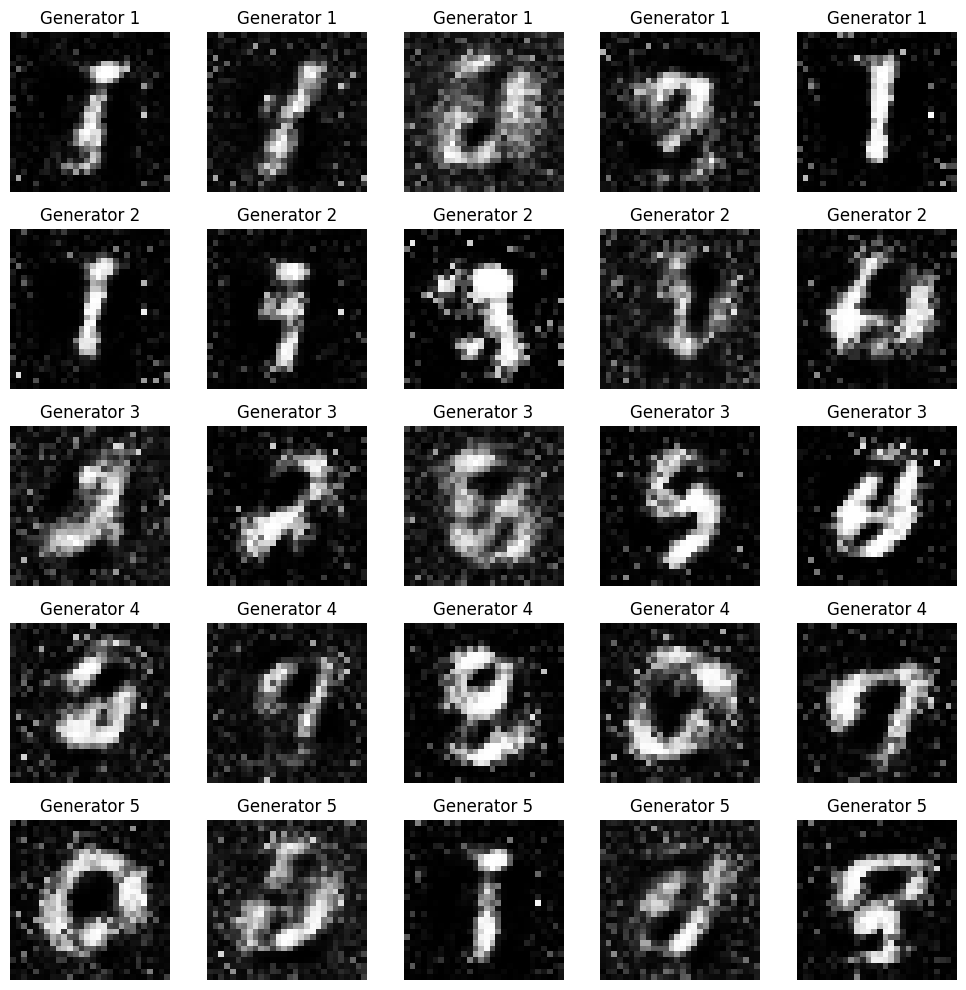

Epoch [6/100], Batch [0/188], D Loss: 1.4584, C Loss: 1.6104, G Loss: 0.4239
Epoch [6/100], Batch [100/188], D Loss: 1.2126, C Loss: 1.6092, G Loss: -0.7561
Epoch [7/100], Batch [0/188], D Loss: 1.0244, C Loss: 1.6097, G Loss: -0.4633
Epoch [7/100], Batch [100/188], D Loss: 1.1792, C Loss: 1.6087, G Loss: -0.3580
Epoch [8/100], Batch [0/188], D Loss: 1.1017, C Loss: 1.6098, G Loss: -0.5263
Epoch [8/100], Batch [100/188], D Loss: 1.1024, C Loss: 1.6074, G Loss: -0.4479
Epoch [9/100], Batch [0/188], D Loss: 1.1485, C Loss: 1.6073, G Loss: -0.6343
Epoch [9/100], Batch [100/188], D Loss: 1.2039, C Loss: 1.6092, G Loss: -0.5614
Epoch [10/100], Batch [0/188], D Loss: 1.2740, C Loss: 1.6092, G Loss: -0.8427
Epoch [10/100], Batch [100/188], D Loss: 1.2157, C Loss: 1.6103, G Loss: -0.8234
Generating samples at epoch 10


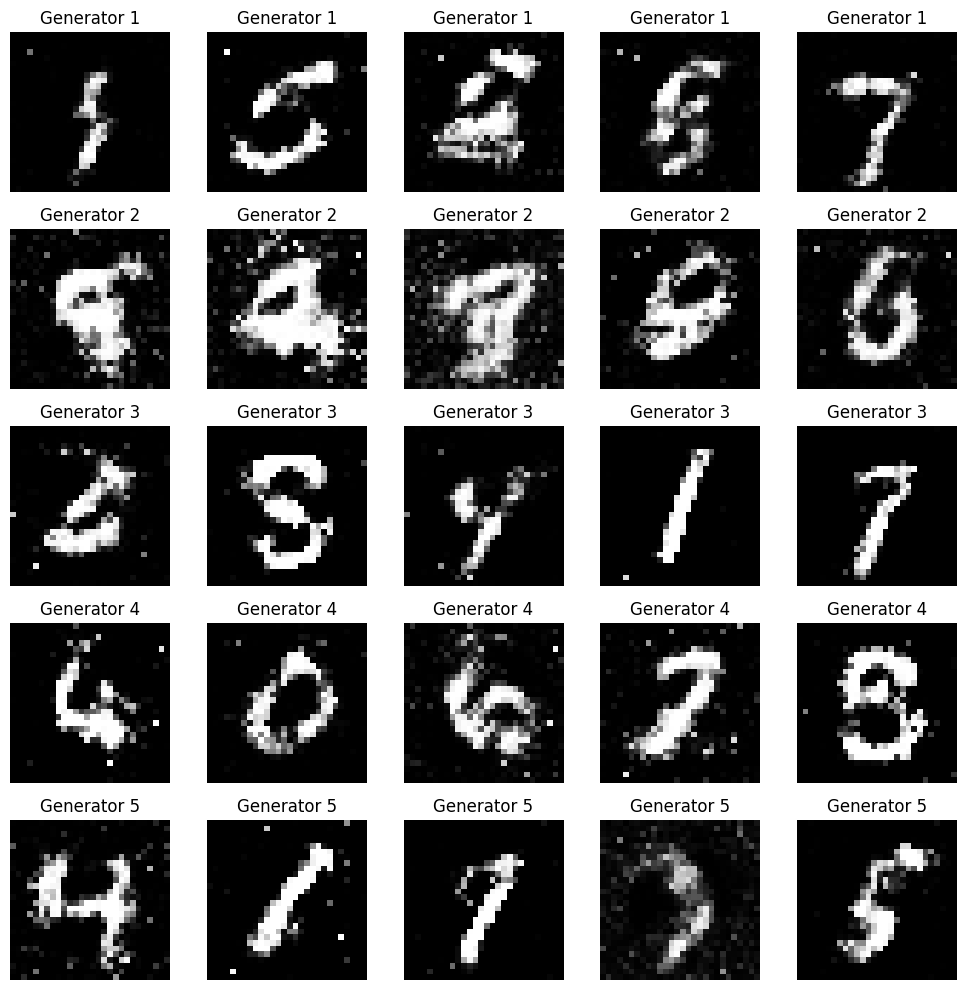

Epoch [11/100], Batch [0/188], D Loss: 1.1570, C Loss: 1.6102, G Loss: -0.6006
Epoch [11/100], Batch [100/188], D Loss: 1.1523, C Loss: 1.6105, G Loss: -0.3402
Epoch [12/100], Batch [0/188], D Loss: 1.1775, C Loss: 1.6098, G Loss: -0.6723
Epoch [12/100], Batch [100/188], D Loss: 1.2146, C Loss: 1.6102, G Loss: -0.5540
Epoch [13/100], Batch [0/188], D Loss: 1.1999, C Loss: 1.6091, G Loss: -0.8149
Epoch [13/100], Batch [100/188], D Loss: 1.2651, C Loss: 1.6101, G Loss: -0.8606
Epoch [14/100], Batch [0/188], D Loss: 1.3090, C Loss: 1.6090, G Loss: -0.3780
Epoch [14/100], Batch [100/188], D Loss: 1.2075, C Loss: 1.6103, G Loss: -0.8047
Epoch [15/100], Batch [0/188], D Loss: 1.2139, C Loss: 1.6103, G Loss: -0.6200
Epoch [15/100], Batch [100/188], D Loss: 1.2837, C Loss: 1.6122, G Loss: -0.7936
Generating samples at epoch 15


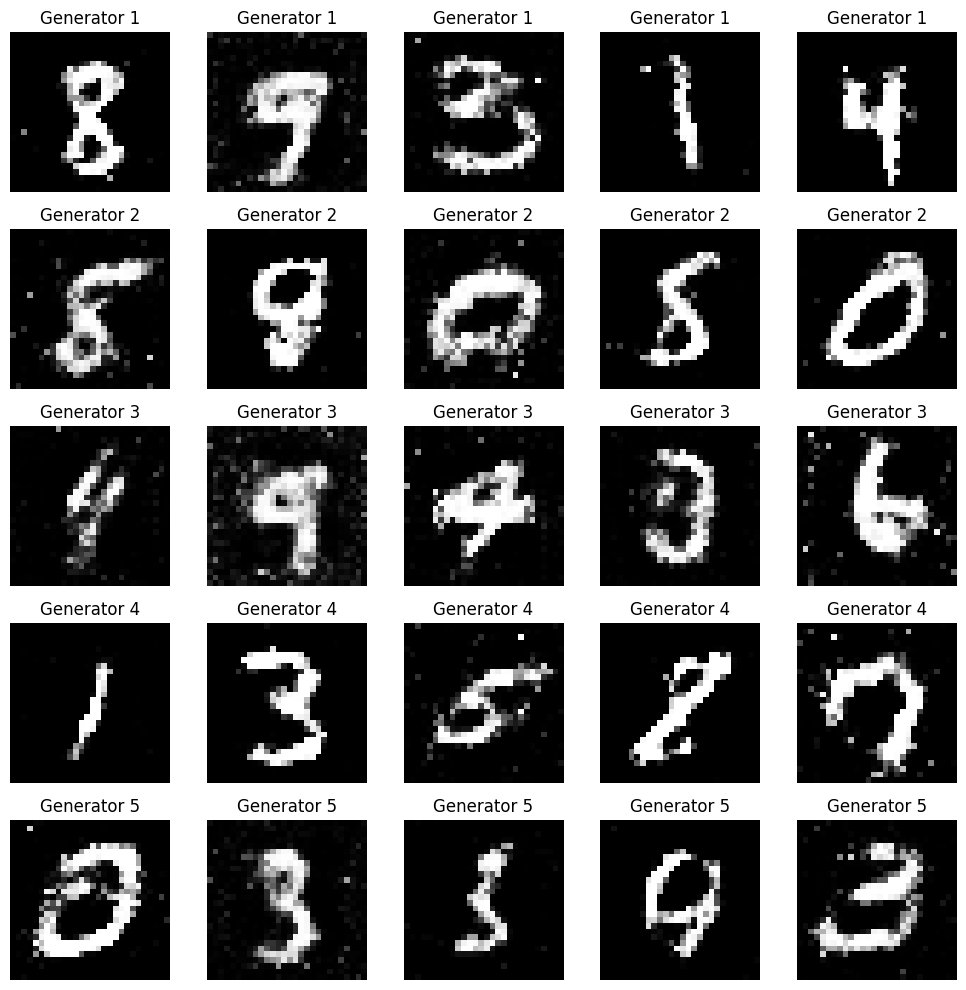

Epoch [16/100], Batch [0/188], D Loss: 1.3085, C Loss: 1.6097, G Loss: -0.4579
Epoch [16/100], Batch [100/188], D Loss: 1.2276, C Loss: 1.6101, G Loss: -0.6744
Epoch [17/100], Batch [0/188], D Loss: 1.2459, C Loss: 1.6096, G Loss: -0.7779
Epoch [17/100], Batch [100/188], D Loss: 1.2149, C Loss: 1.6109, G Loss: -0.7497
Epoch [18/100], Batch [0/188], D Loss: 1.2283, C Loss: 1.6097, G Loss: -0.7706
Epoch [18/100], Batch [100/188], D Loss: 1.2494, C Loss: 1.6109, G Loss: -0.9325
Epoch [19/100], Batch [0/188], D Loss: 1.2368, C Loss: 1.6092, G Loss: -0.8102
Epoch [19/100], Batch [100/188], D Loss: 1.2669, C Loss: 1.6079, G Loss: -0.4822
Epoch [20/100], Batch [0/188], D Loss: 1.2556, C Loss: 1.6095, G Loss: -0.6648
Epoch [20/100], Batch [100/188], D Loss: 1.2589, C Loss: 1.6095, G Loss: -0.7628
Generating samples at epoch 20


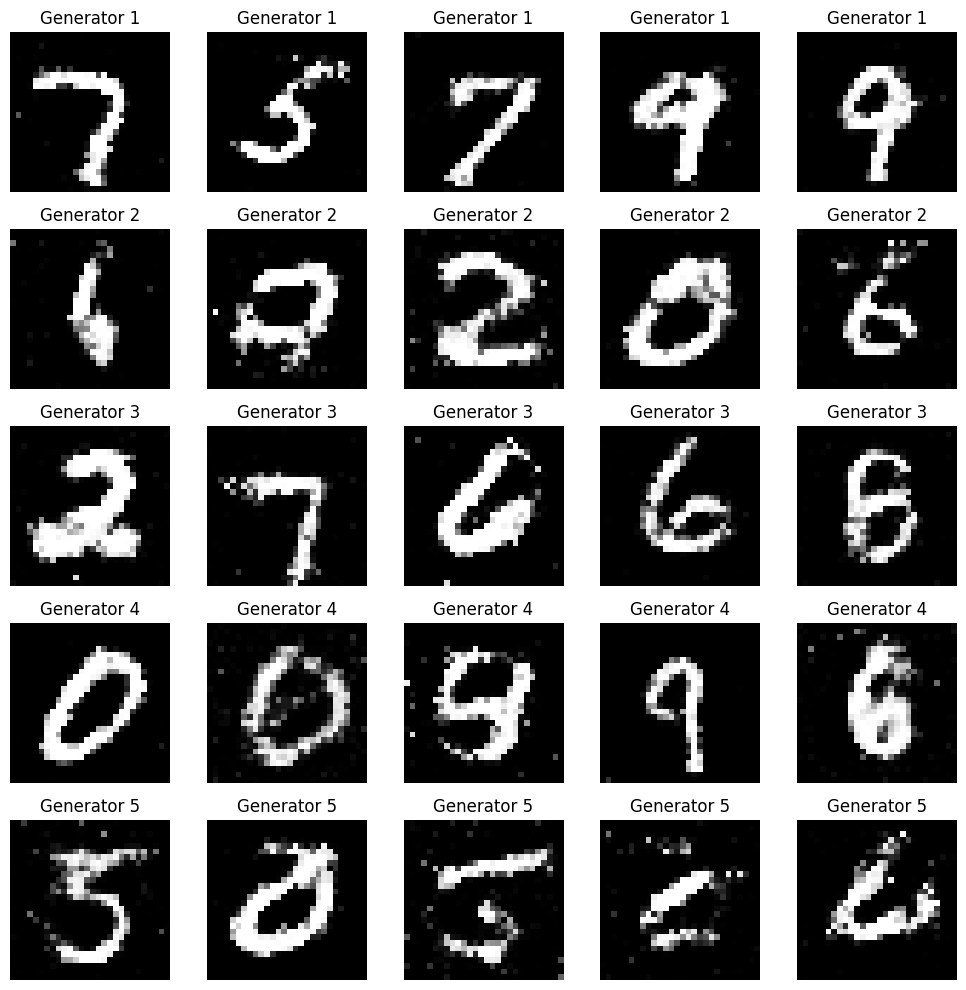

Epoch [21/100], Batch [0/188], D Loss: 1.3072, C Loss: 1.6105, G Loss: -0.5901
Epoch [21/100], Batch [100/188], D Loss: 1.3156, C Loss: 1.6086, G Loss: -0.4637
Epoch [22/100], Batch [0/188], D Loss: 1.3612, C Loss: 1.6103, G Loss: -0.5306
Epoch [22/100], Batch [100/188], D Loss: 1.3279, C Loss: 1.6091, G Loss: -0.6728
Epoch [23/100], Batch [0/188], D Loss: 1.3262, C Loss: 1.6095, G Loss: -0.6601
Epoch [23/100], Batch [100/188], D Loss: 1.3027, C Loss: 1.6099, G Loss: -0.6949
Epoch [24/100], Batch [0/188], D Loss: 1.3224, C Loss: 1.6092, G Loss: -0.6865
Epoch [24/100], Batch [100/188], D Loss: 1.3028, C Loss: 1.6094, G Loss: -0.9102
Epoch [25/100], Batch [0/188], D Loss: 1.3225, C Loss: 1.6095, G Loss: -0.7031
Epoch [25/100], Batch [100/188], D Loss: 1.2789, C Loss: 1.6110, G Loss: -0.7674
Generating samples at epoch 25


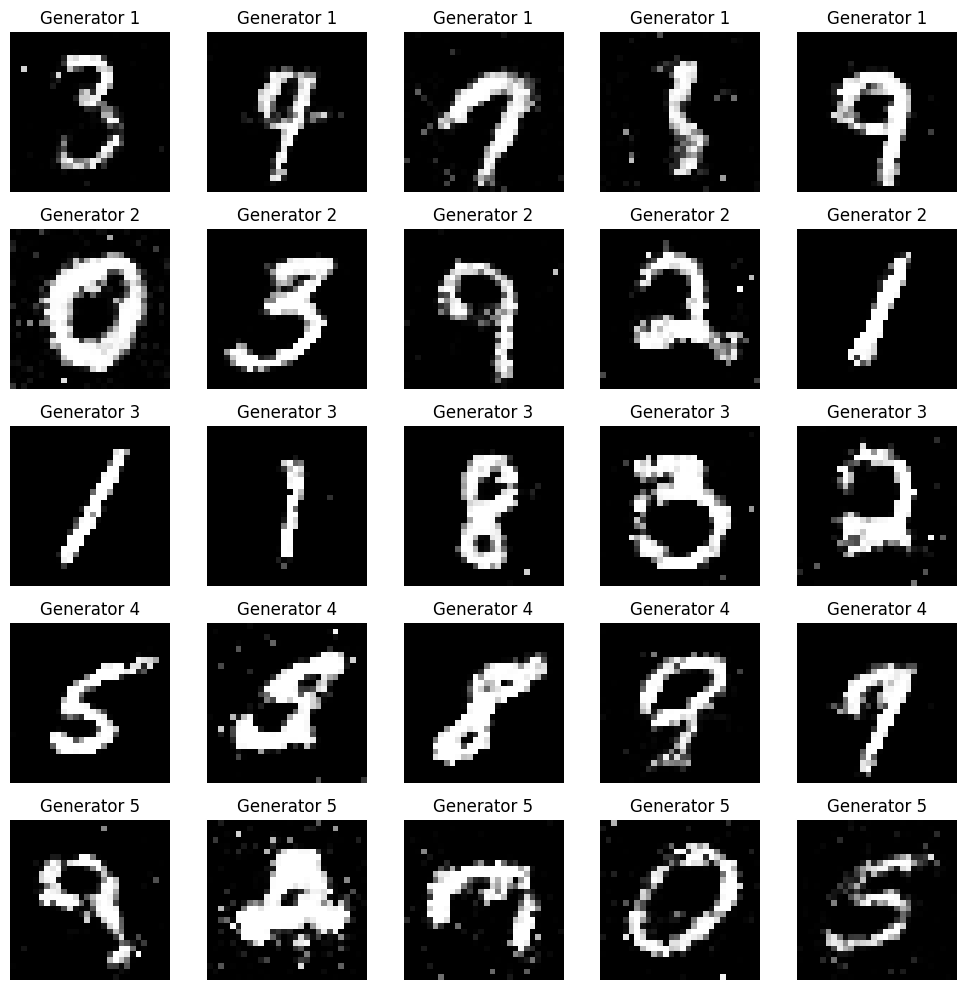

Epoch [26/100], Batch [0/188], D Loss: 1.3431, C Loss: 1.6086, G Loss: -0.4019
Epoch [26/100], Batch [100/188], D Loss: 1.2744, C Loss: 1.6097, G Loss: -0.7717
Epoch [27/100], Batch [0/188], D Loss: 1.3776, C Loss: 1.6100, G Loss: -0.6135
Epoch [27/100], Batch [100/188], D Loss: 1.3149, C Loss: 1.6109, G Loss: -0.6781
Epoch [28/100], Batch [0/188], D Loss: 1.2979, C Loss: 1.6097, G Loss: -0.7849
Epoch [28/100], Batch [100/188], D Loss: 1.3063, C Loss: 1.6086, G Loss: -0.8699
Epoch [29/100], Batch [0/188], D Loss: 1.3074, C Loss: 1.6085, G Loss: -0.8971
Epoch [29/100], Batch [100/188], D Loss: 1.3277, C Loss: 1.6093, G Loss: -0.8964
Epoch [30/100], Batch [0/188], D Loss: 1.3186, C Loss: 1.6102, G Loss: -0.8049
Epoch [30/100], Batch [100/188], D Loss: 1.2915, C Loss: 1.6088, G Loss: -0.8792
Generating samples at epoch 30


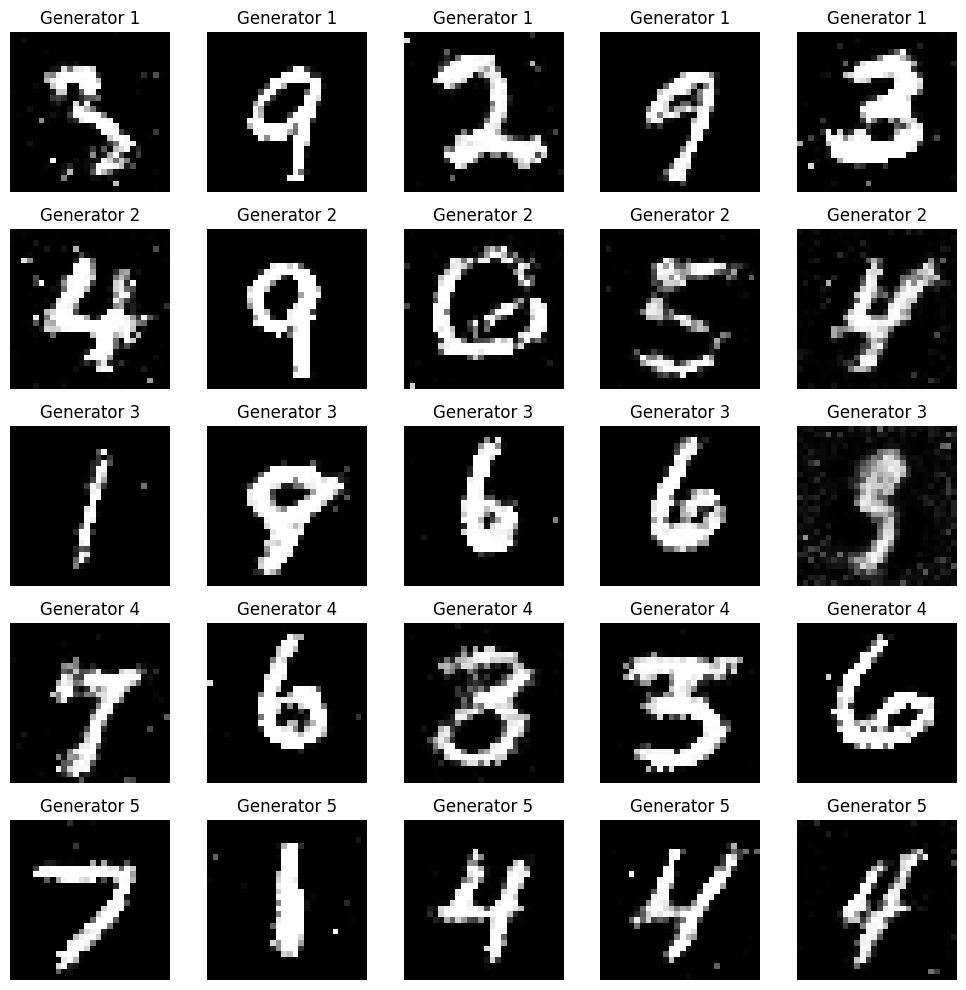

Epoch [31/100], Batch [0/188], D Loss: 1.3579, C Loss: 1.6096, G Loss: -0.4457
Epoch [31/100], Batch [100/188], D Loss: 1.3153, C Loss: 1.6096, G Loss: -0.7550
Epoch [32/100], Batch [0/188], D Loss: 1.3654, C Loss: 1.6116, G Loss: -1.0193
Epoch [32/100], Batch [100/188], D Loss: 1.3510, C Loss: 1.6093, G Loss: -0.9349
Epoch [33/100], Batch [0/188], D Loss: 1.3284, C Loss: 1.6102, G Loss: -0.6605
Epoch [33/100], Batch [100/188], D Loss: 1.3563, C Loss: 1.6097, G Loss: -0.9418
Epoch [34/100], Batch [0/188], D Loss: 1.3653, C Loss: 1.6097, G Loss: -0.4324
Epoch [34/100], Batch [100/188], D Loss: 1.3056, C Loss: 1.6102, G Loss: -0.8443
Epoch [35/100], Batch [0/188], D Loss: 1.3537, C Loss: 1.6083, G Loss: -0.5875
Epoch [35/100], Batch [100/188], D Loss: 1.3289, C Loss: 1.6097, G Loss: -0.7819
Generating samples at epoch 35


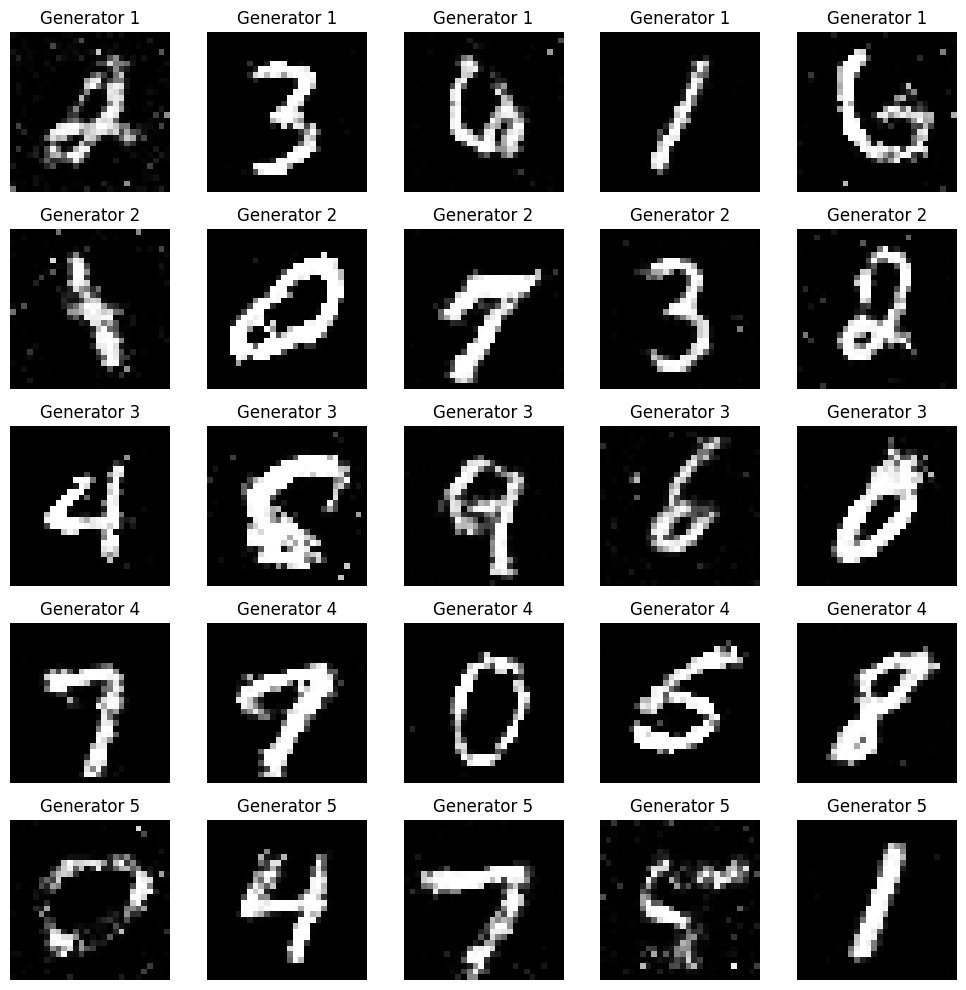

Epoch [36/100], Batch [0/188], D Loss: 1.3504, C Loss: 1.6095, G Loss: -0.7376
Epoch [36/100], Batch [100/188], D Loss: 1.3531, C Loss: 1.6102, G Loss: -0.9179
Epoch [37/100], Batch [0/188], D Loss: 1.3279, C Loss: 1.6093, G Loss: -0.8764
Epoch [37/100], Batch [100/188], D Loss: 1.3256, C Loss: 1.6093, G Loss: -0.7037
Epoch [38/100], Batch [0/188], D Loss: 1.3491, C Loss: 1.6092, G Loss: -0.7496
Epoch [38/100], Batch [100/188], D Loss: 1.3337, C Loss: 1.6088, G Loss: -0.8475
Epoch [39/100], Batch [0/188], D Loss: 1.3514, C Loss: 1.6089, G Loss: -0.7434
Epoch [39/100], Batch [100/188], D Loss: 1.3258, C Loss: 1.6086, G Loss: -0.8207
Epoch [40/100], Batch [0/188], D Loss: 1.3316, C Loss: 1.6102, G Loss: -0.8348
Epoch [40/100], Batch [100/188], D Loss: 1.3521, C Loss: 1.6098, G Loss: -0.8828
Generating samples at epoch 40


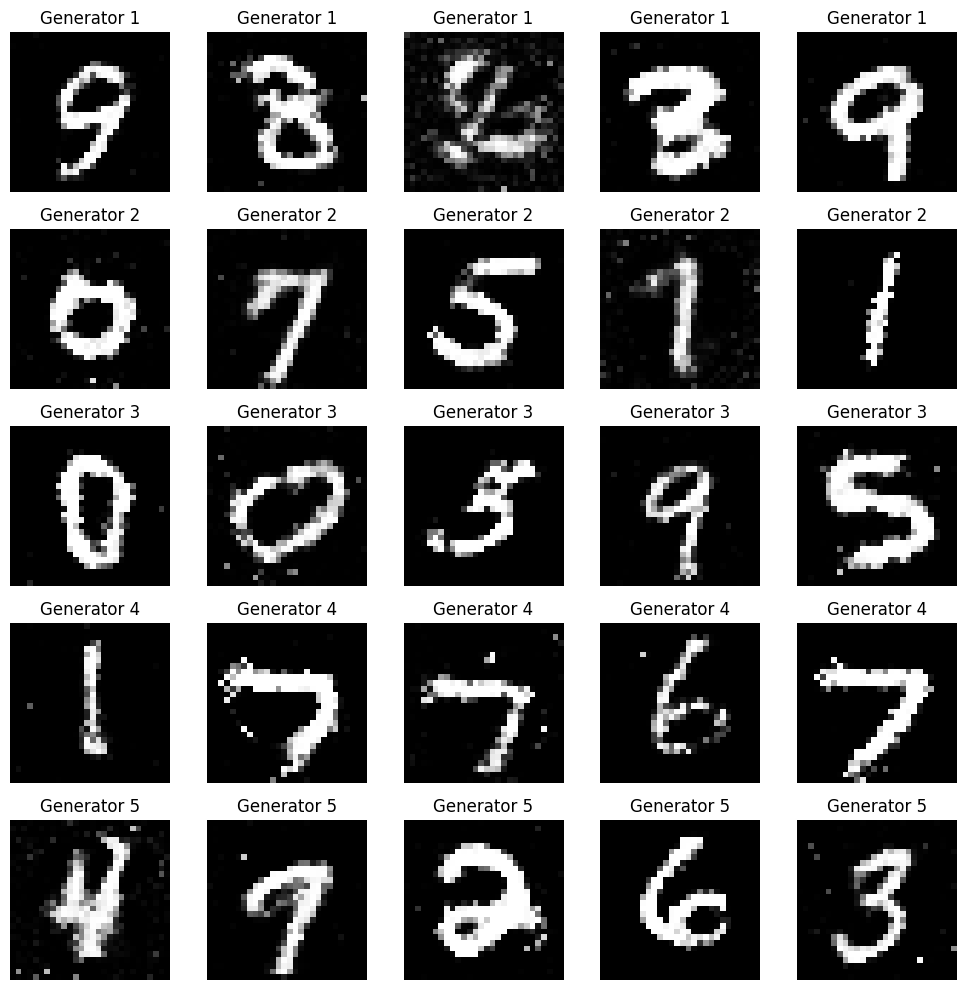

Epoch [41/100], Batch [0/188], D Loss: 1.3013, C Loss: 1.6093, G Loss: -0.7951
Epoch [41/100], Batch [100/188], D Loss: 1.3312, C Loss: 1.6083, G Loss: -0.8483
Epoch [42/100], Batch [0/188], D Loss: 1.3838, C Loss: 1.6101, G Loss: -0.9880
Epoch [42/100], Batch [100/188], D Loss: 1.3539, C Loss: 1.6092, G Loss: -0.8472
Epoch [43/100], Batch [0/188], D Loss: 1.3401, C Loss: 1.6102, G Loss: -0.7652
Epoch [43/100], Batch [100/188], D Loss: 1.3504, C Loss: 1.6101, G Loss: -0.8274
Epoch [44/100], Batch [0/188], D Loss: 1.3613, C Loss: 1.6100, G Loss: -0.8960
Epoch [44/100], Batch [100/188], D Loss: 1.3521, C Loss: 1.6097, G Loss: -0.8910
Epoch [45/100], Batch [0/188], D Loss: 1.3408, C Loss: 1.6085, G Loss: -0.7974
Epoch [45/100], Batch [100/188], D Loss: 1.3450, C Loss: 1.6097, G Loss: -0.8252
Generating samples at epoch 45


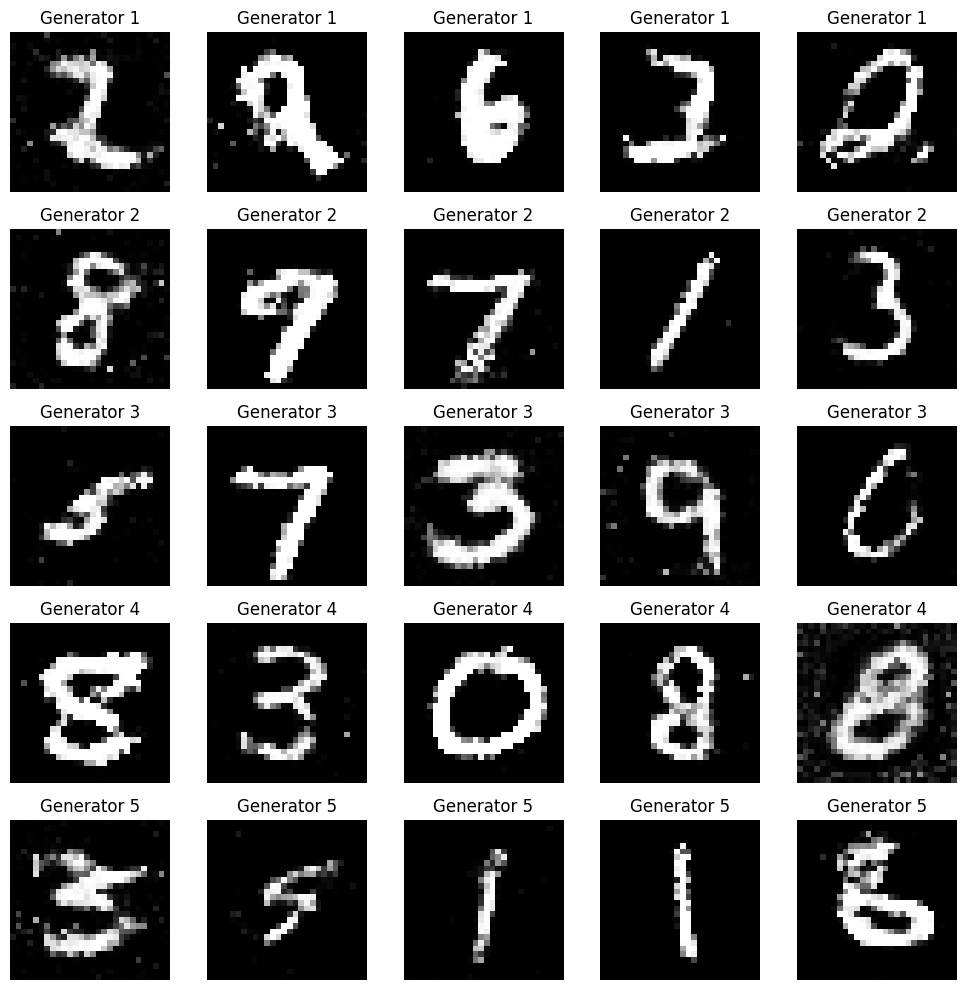

Epoch [46/100], Batch [0/188], D Loss: 1.3267, C Loss: 1.6085, G Loss: -0.6266
Epoch [46/100], Batch [100/188], D Loss: 1.3283, C Loss: 1.6094, G Loss: -0.7190
Epoch [47/100], Batch [0/188], D Loss: 1.3345, C Loss: 1.6097, G Loss: -0.8056
Epoch [47/100], Batch [100/188], D Loss: 1.3777, C Loss: 1.6090, G Loss: -0.9079
Epoch [48/100], Batch [0/188], D Loss: 1.3342, C Loss: 1.6105, G Loss: -0.8176
Epoch [48/100], Batch [100/188], D Loss: 1.3526, C Loss: 1.6093, G Loss: -0.8602
Epoch [49/100], Batch [0/188], D Loss: 1.3799, C Loss: 1.6105, G Loss: -0.9300
Epoch [49/100], Batch [100/188], D Loss: 1.3294, C Loss: 1.6096, G Loss: -0.8202
Epoch [50/100], Batch [0/188], D Loss: 1.3618, C Loss: 1.6096, G Loss: -0.7605
Epoch [50/100], Batch [100/188], D Loss: 1.3904, C Loss: 1.6094, G Loss: -0.7751
Generating samples at epoch 50


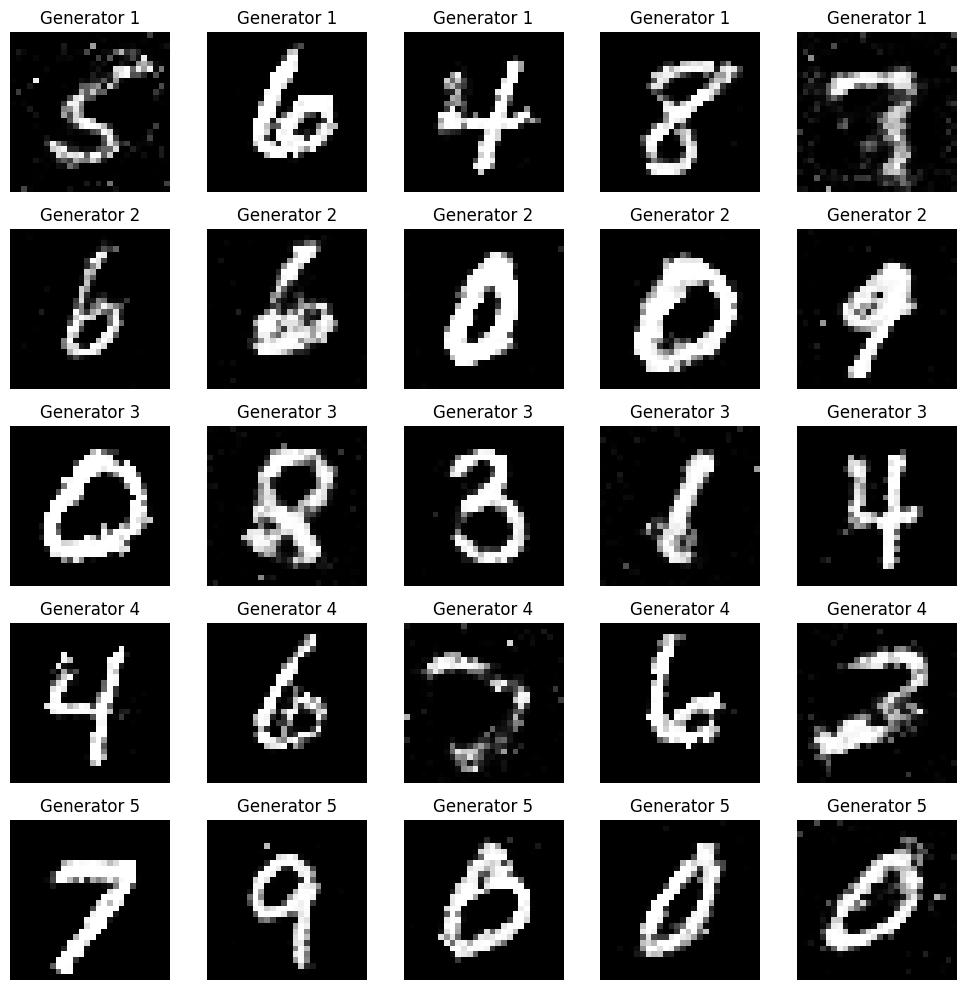

Epoch [51/100], Batch [0/188], D Loss: 1.3728, C Loss: 1.6093, G Loss: -0.7457
Epoch [51/100], Batch [100/188], D Loss: 1.3599, C Loss: 1.6089, G Loss: -0.8266
Epoch [52/100], Batch [0/188], D Loss: 1.3392, C Loss: 1.6094, G Loss: -0.8990
Epoch [52/100], Batch [100/188], D Loss: 1.3489, C Loss: 1.6105, G Loss: -0.9683
Epoch [53/100], Batch [0/188], D Loss: 1.3552, C Loss: 1.6098, G Loss: -0.8909
Epoch [53/100], Batch [100/188], D Loss: 1.3245, C Loss: 1.6102, G Loss: -0.7150
Epoch [54/100], Batch [0/188], D Loss: 1.3678, C Loss: 1.6088, G Loss: -0.8298
Epoch [54/100], Batch [100/188], D Loss: 1.3452, C Loss: 1.6091, G Loss: -0.8213
Epoch [55/100], Batch [0/188], D Loss: 1.4257, C Loss: 1.6092, G Loss: -0.5950
Epoch [55/100], Batch [100/188], D Loss: 1.3422, C Loss: 1.6098, G Loss: -0.8961
Generating samples at epoch 55


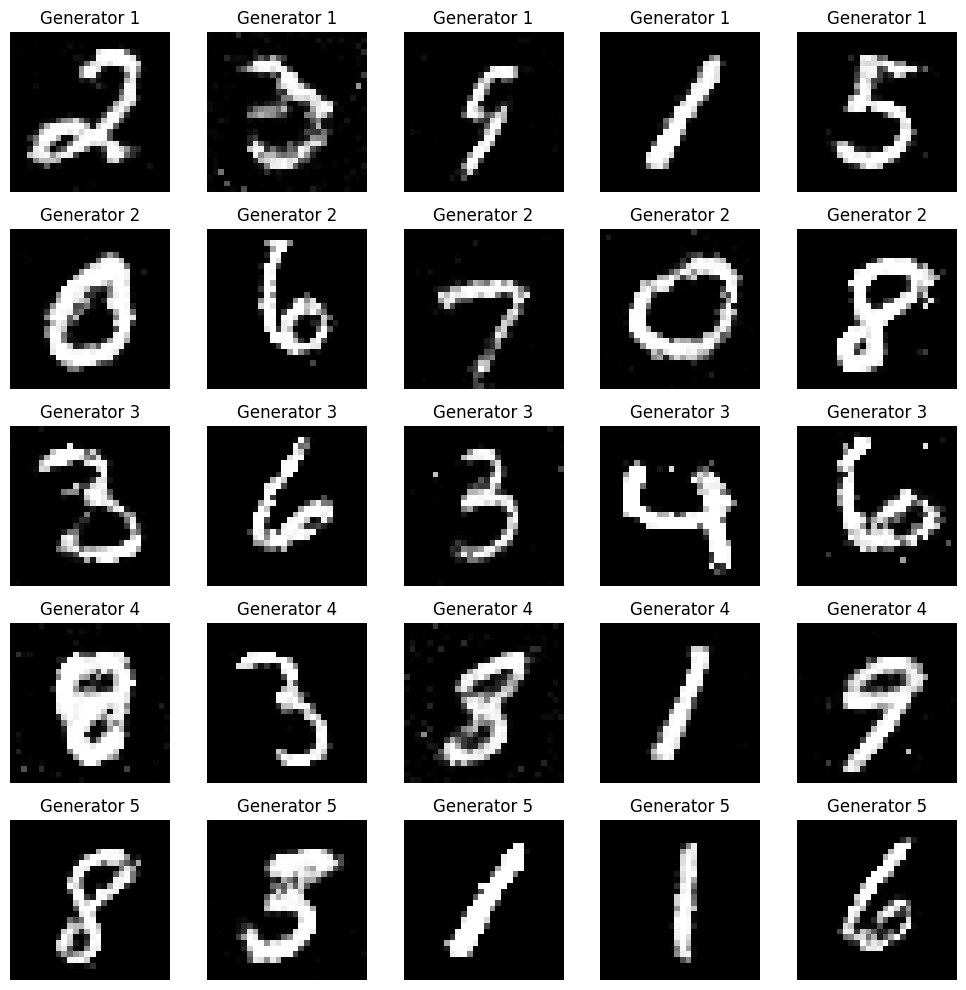

Epoch [56/100], Batch [0/188], D Loss: 1.3617, C Loss: 1.6100, G Loss: -0.7612
Epoch [56/100], Batch [100/188], D Loss: 1.3591, C Loss: 1.6098, G Loss: -0.9444
Epoch [57/100], Batch [0/188], D Loss: 1.3696, C Loss: 1.6095, G Loss: -0.8372
Epoch [57/100], Batch [100/188], D Loss: 1.3663, C Loss: 1.6086, G Loss: -0.8001
Epoch [58/100], Batch [0/188], D Loss: 1.3796, C Loss: 1.6100, G Loss: -0.9509
Epoch [58/100], Batch [100/188], D Loss: 1.3662, C Loss: 1.6100, G Loss: -0.8843
Epoch [59/100], Batch [0/188], D Loss: 1.3460, C Loss: 1.6100, G Loss: -0.8489
Epoch [59/100], Batch [100/188], D Loss: 1.3400, C Loss: 1.6092, G Loss: -0.7438
Epoch [60/100], Batch [0/188], D Loss: 1.3437, C Loss: 1.6105, G Loss: -0.9408
Epoch [60/100], Batch [100/188], D Loss: 1.3568, C Loss: 1.6086, G Loss: -0.9020
Generating samples at epoch 60


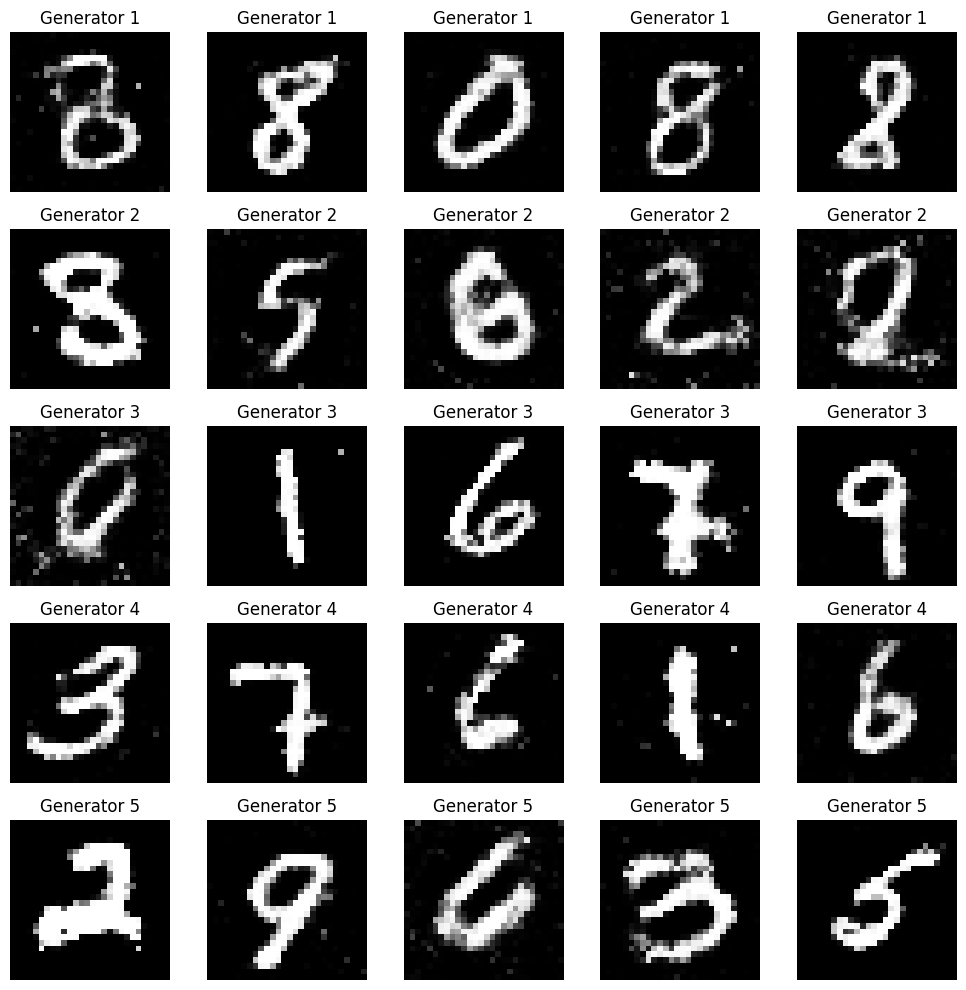

Epoch [61/100], Batch [0/188], D Loss: 1.3585, C Loss: 1.6094, G Loss: -0.9060
Epoch [61/100], Batch [100/188], D Loss: 1.3529, C Loss: 1.6096, G Loss: -0.7397
Epoch [62/100], Batch [0/188], D Loss: 1.3636, C Loss: 1.6092, G Loss: -0.8242
Epoch [62/100], Batch [100/188], D Loss: 1.3602, C Loss: 1.6092, G Loss: -0.8149
Epoch [63/100], Batch [0/188], D Loss: 1.3507, C Loss: 1.6099, G Loss: -0.7969
Epoch [63/100], Batch [100/188], D Loss: 1.3336, C Loss: 1.6098, G Loss: -0.7720
Epoch [64/100], Batch [0/188], D Loss: 1.3602, C Loss: 1.6091, G Loss: -0.9029
Epoch [64/100], Batch [100/188], D Loss: 1.3482, C Loss: 1.6092, G Loss: -0.8620
Epoch [65/100], Batch [0/188], D Loss: 1.3500, C Loss: 1.6090, G Loss: -0.8717
Epoch [65/100], Batch [100/188], D Loss: 1.3672, C Loss: 1.6099, G Loss: -0.8011
Generating samples at epoch 65


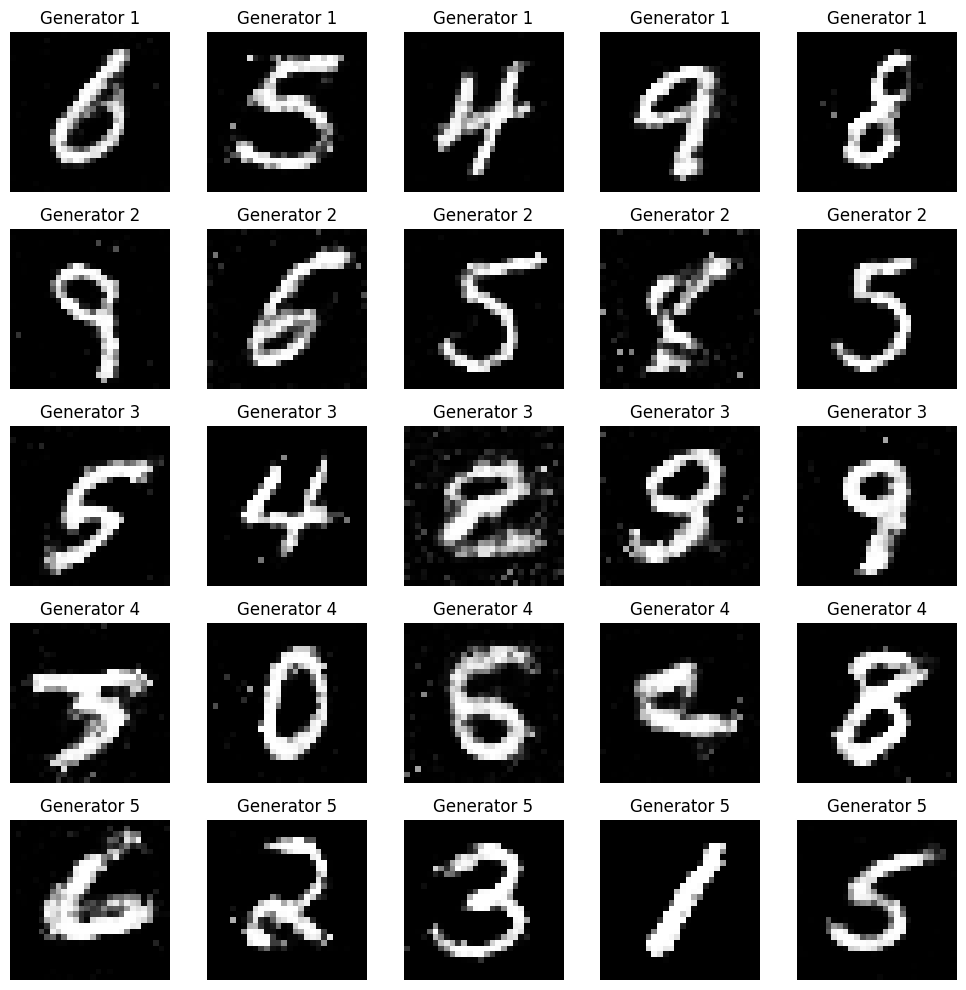

Epoch [66/100], Batch [0/188], D Loss: 1.3593, C Loss: 1.6096, G Loss: -0.7794
Epoch [66/100], Batch [100/188], D Loss: 1.3410, C Loss: 1.6093, G Loss: -0.8154
Epoch [67/100], Batch [0/188], D Loss: 1.3381, C Loss: 1.6094, G Loss: -0.8107
Epoch [67/100], Batch [100/188], D Loss: 1.3480, C Loss: 1.6091, G Loss: -0.7658
Epoch [68/100], Batch [0/188], D Loss: 1.3610, C Loss: 1.6098, G Loss: -0.7909
Epoch [68/100], Batch [100/188], D Loss: 1.3672, C Loss: 1.6086, G Loss: -0.8847
Epoch [69/100], Batch [0/188], D Loss: 1.3554, C Loss: 1.6104, G Loss: -0.8345
Epoch [69/100], Batch [100/188], D Loss: 1.3430, C Loss: 1.6099, G Loss: -0.8607
Epoch [70/100], Batch [0/188], D Loss: 1.3596, C Loss: 1.6096, G Loss: -0.8512
Epoch [70/100], Batch [100/188], D Loss: 1.3424, C Loss: 1.6087, G Loss: -0.8734
Generating samples at epoch 70


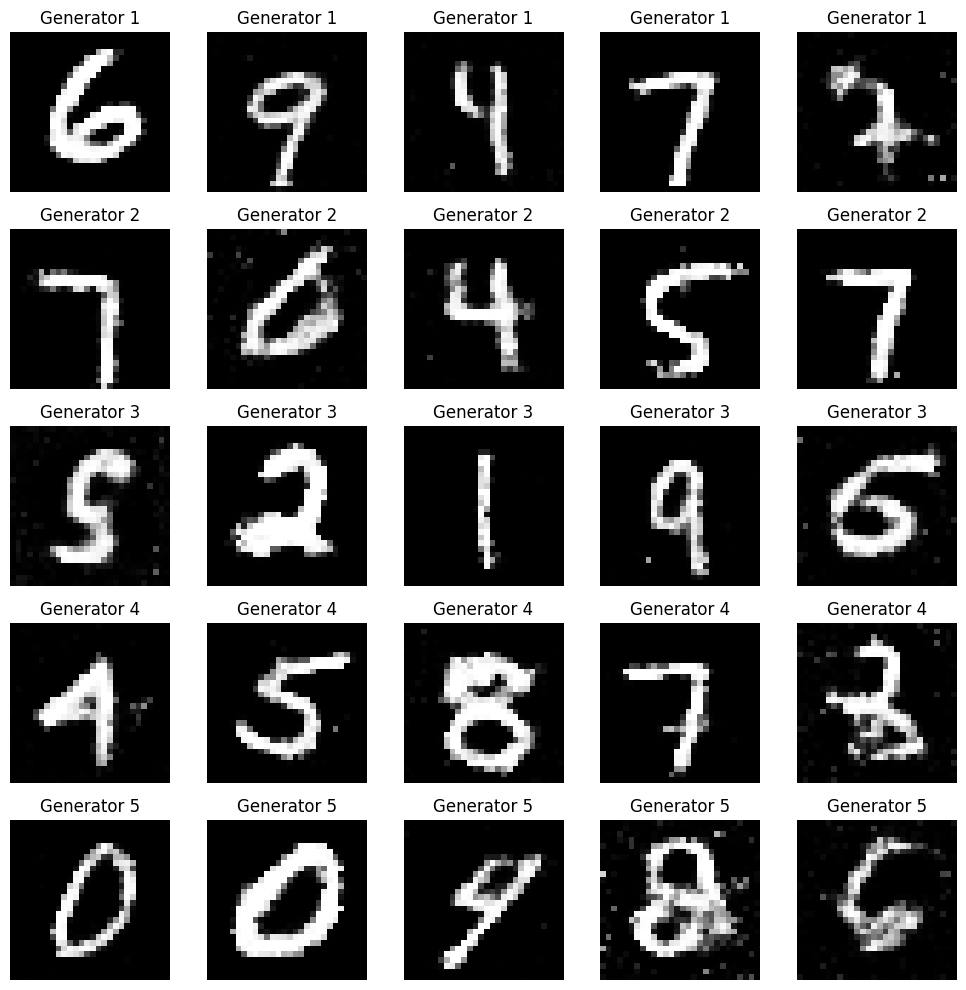

Epoch [71/100], Batch [0/188], D Loss: 1.3603, C Loss: 1.6099, G Loss: -0.8324
Epoch [71/100], Batch [100/188], D Loss: 1.3660, C Loss: 1.6090, G Loss: -0.8425
Epoch [72/100], Batch [0/188], D Loss: 1.3498, C Loss: 1.6091, G Loss: -0.8881
Epoch [72/100], Batch [100/188], D Loss: 1.3661, C Loss: 1.6092, G Loss: -0.7627
Epoch [73/100], Batch [0/188], D Loss: 1.3551, C Loss: 1.6094, G Loss: -0.8492
Epoch [73/100], Batch [100/188], D Loss: 1.3494, C Loss: 1.6096, G Loss: -0.8195
Epoch [74/100], Batch [0/188], D Loss: 1.3646, C Loss: 1.6101, G Loss: -0.8458
Epoch [74/100], Batch [100/188], D Loss: 1.3372, C Loss: 1.6098, G Loss: -0.8329
Epoch [75/100], Batch [0/188], D Loss: 1.3517, C Loss: 1.6098, G Loss: -0.7755
Epoch [75/100], Batch [100/188], D Loss: 1.3515, C Loss: 1.6095, G Loss: -0.8867
Generating samples at epoch 75


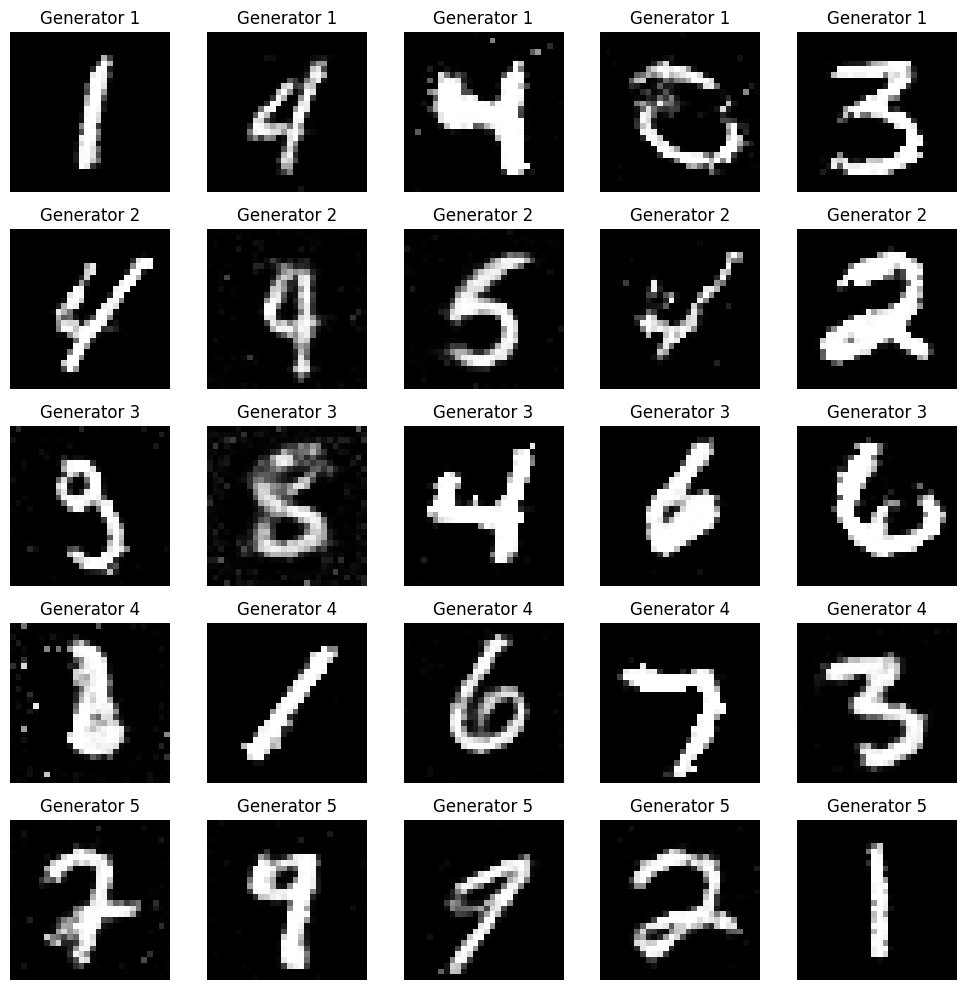

Epoch [76/100], Batch [0/188], D Loss: 1.3458, C Loss: 1.6092, G Loss: -0.9007
Epoch [76/100], Batch [100/188], D Loss: 1.3510, C Loss: 1.6094, G Loss: -0.9109
Epoch [77/100], Batch [0/188], D Loss: 1.3539, C Loss: 1.6099, G Loss: -0.8305
Epoch [77/100], Batch [100/188], D Loss: 1.3655, C Loss: 1.6094, G Loss: -0.8914
Epoch [78/100], Batch [0/188], D Loss: 1.3508, C Loss: 1.6096, G Loss: -0.8383
Epoch [78/100], Batch [100/188], D Loss: 1.3357, C Loss: 1.6099, G Loss: -0.7462
Epoch [79/100], Batch [0/188], D Loss: 1.3474, C Loss: 1.6093, G Loss: -0.8627
Epoch [79/100], Batch [100/188], D Loss: 1.3542, C Loss: 1.6093, G Loss: -0.8928
Epoch [80/100], Batch [0/188], D Loss: 1.3648, C Loss: 1.6095, G Loss: -0.7861
Epoch [80/100], Batch [100/188], D Loss: 1.3973, C Loss: 1.6093, G Loss: -0.7697
Generating samples at epoch 80


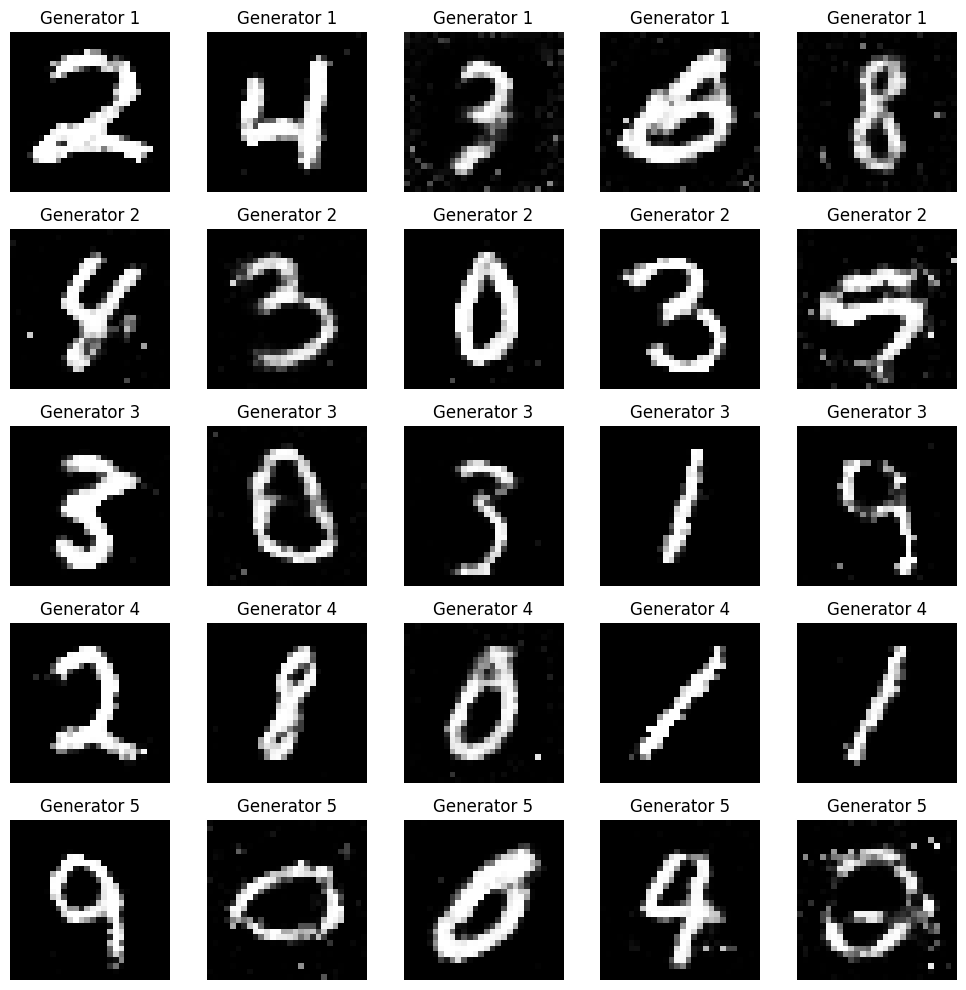

Epoch [81/100], Batch [0/188], D Loss: 1.3539, C Loss: 1.6093, G Loss: -0.8228
Epoch [81/100], Batch [100/188], D Loss: 1.3634, C Loss: 1.6103, G Loss: -0.9799
Epoch [82/100], Batch [0/188], D Loss: 1.3597, C Loss: 1.6101, G Loss: -0.8612
Epoch [82/100], Batch [100/188], D Loss: 1.3541, C Loss: 1.6104, G Loss: -0.7964
Epoch [83/100], Batch [0/188], D Loss: 1.3884, C Loss: 1.6090, G Loss: -0.7927
Epoch [83/100], Batch [100/188], D Loss: 1.3522, C Loss: 1.6108, G Loss: -0.9052
Epoch [84/100], Batch [0/188], D Loss: 1.3573, C Loss: 1.6097, G Loss: -0.8466
Epoch [84/100], Batch [100/188], D Loss: 1.3645, C Loss: 1.6085, G Loss: -0.7880
Epoch [85/100], Batch [0/188], D Loss: 1.3668, C Loss: 1.6095, G Loss: -0.8116
Epoch [85/100], Batch [100/188], D Loss: 1.3459, C Loss: 1.6091, G Loss: -0.9023
Generating samples at epoch 85


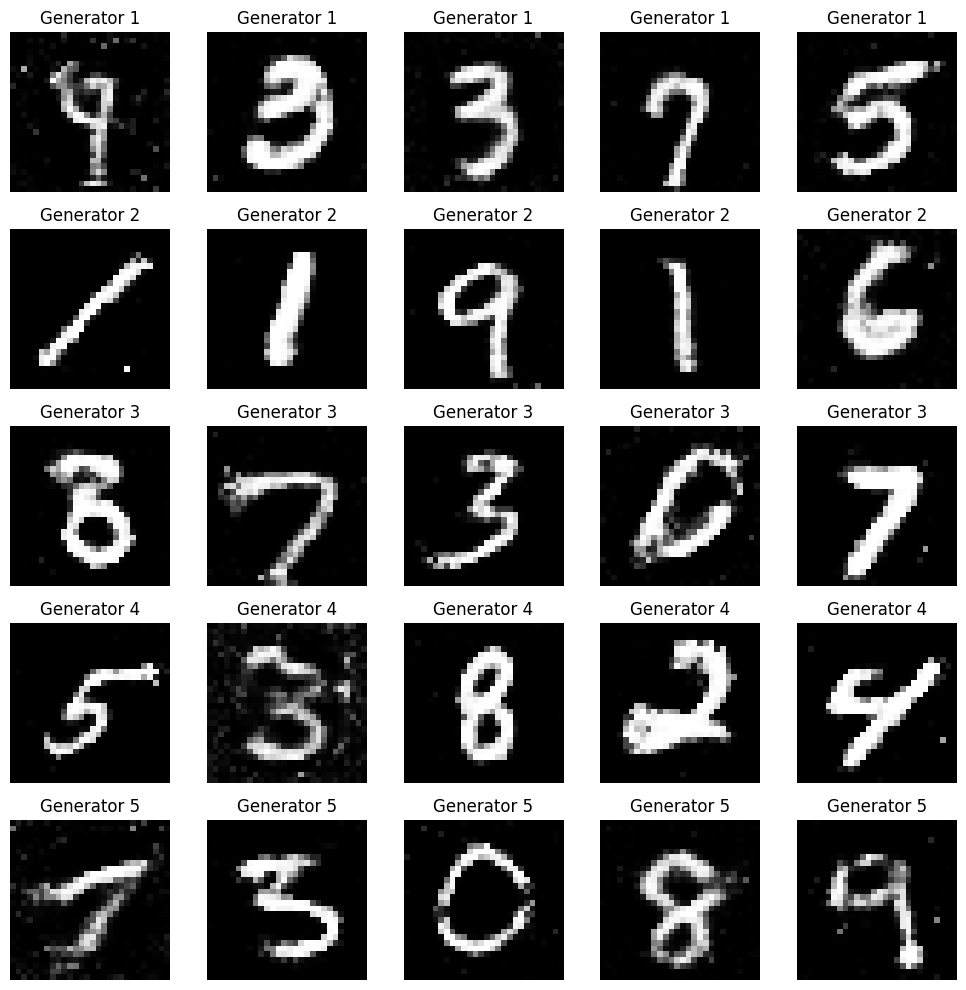

Epoch [86/100], Batch [0/188], D Loss: 1.3621, C Loss: 1.6103, G Loss: -0.8223
Epoch [86/100], Batch [100/188], D Loss: 1.3199, C Loss: 1.6098, G Loss: -0.7933
Epoch [87/100], Batch [0/188], D Loss: 1.3546, C Loss: 1.6092, G Loss: -0.8726
Epoch [87/100], Batch [100/188], D Loss: 1.3509, C Loss: 1.6098, G Loss: -0.8649
Epoch [88/100], Batch [0/188], D Loss: 1.3493, C Loss: 1.6090, G Loss: -0.8153
Epoch [88/100], Batch [100/188], D Loss: 1.3498, C Loss: 1.6092, G Loss: -0.8447
Epoch [89/100], Batch [0/188], D Loss: 1.3609, C Loss: 1.6099, G Loss: -0.7024
Epoch [89/100], Batch [100/188], D Loss: 1.3406, C Loss: 1.6096, G Loss: -0.8418
Epoch [90/100], Batch [0/188], D Loss: 1.3596, C Loss: 1.6104, G Loss: -0.8403
Epoch [90/100], Batch [100/188], D Loss: 1.3681, C Loss: 1.6095, G Loss: -0.8248
Generating samples at epoch 90


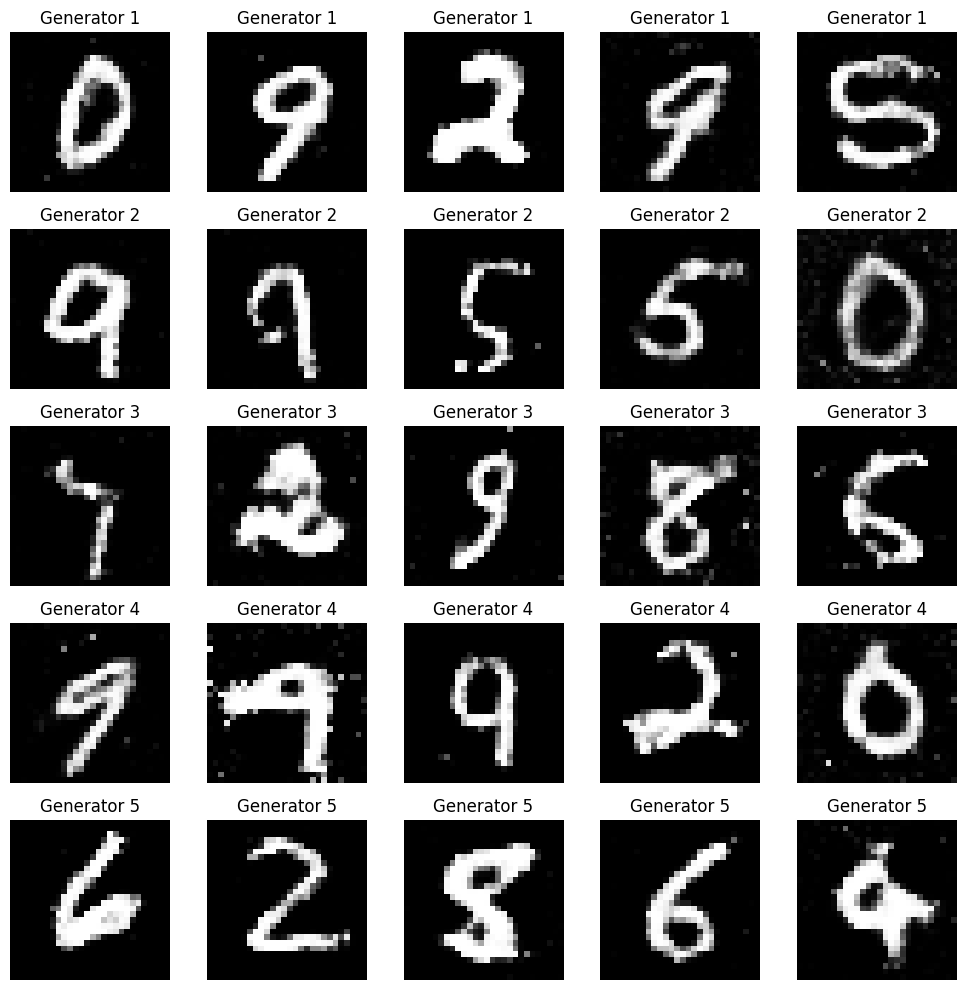

Epoch [91/100], Batch [0/188], D Loss: 1.3343, C Loss: 1.6107, G Loss: -0.9470
Epoch [91/100], Batch [100/188], D Loss: 1.3808, C Loss: 1.6105, G Loss: -0.8502
Epoch [92/100], Batch [0/188], D Loss: 1.3434, C Loss: 1.6097, G Loss: -0.7766
Epoch [92/100], Batch [100/188], D Loss: 1.3507, C Loss: 1.6094, G Loss: -0.8603
Epoch [93/100], Batch [0/188], D Loss: 1.3521, C Loss: 1.6106, G Loss: -0.8922
Epoch [93/100], Batch [100/188], D Loss: 1.3634, C Loss: 1.6098, G Loss: -0.8998
Epoch [94/100], Batch [0/188], D Loss: 1.3415, C Loss: 1.6092, G Loss: -0.9126
Epoch [94/100], Batch [100/188], D Loss: 1.3391, C Loss: 1.6100, G Loss: -0.8510
Epoch [95/100], Batch [0/188], D Loss: 1.3776, C Loss: 1.6097, G Loss: -0.9700
Epoch [95/100], Batch [100/188], D Loss: 1.3668, C Loss: 1.6092, G Loss: -0.7109
Generating samples at epoch 95


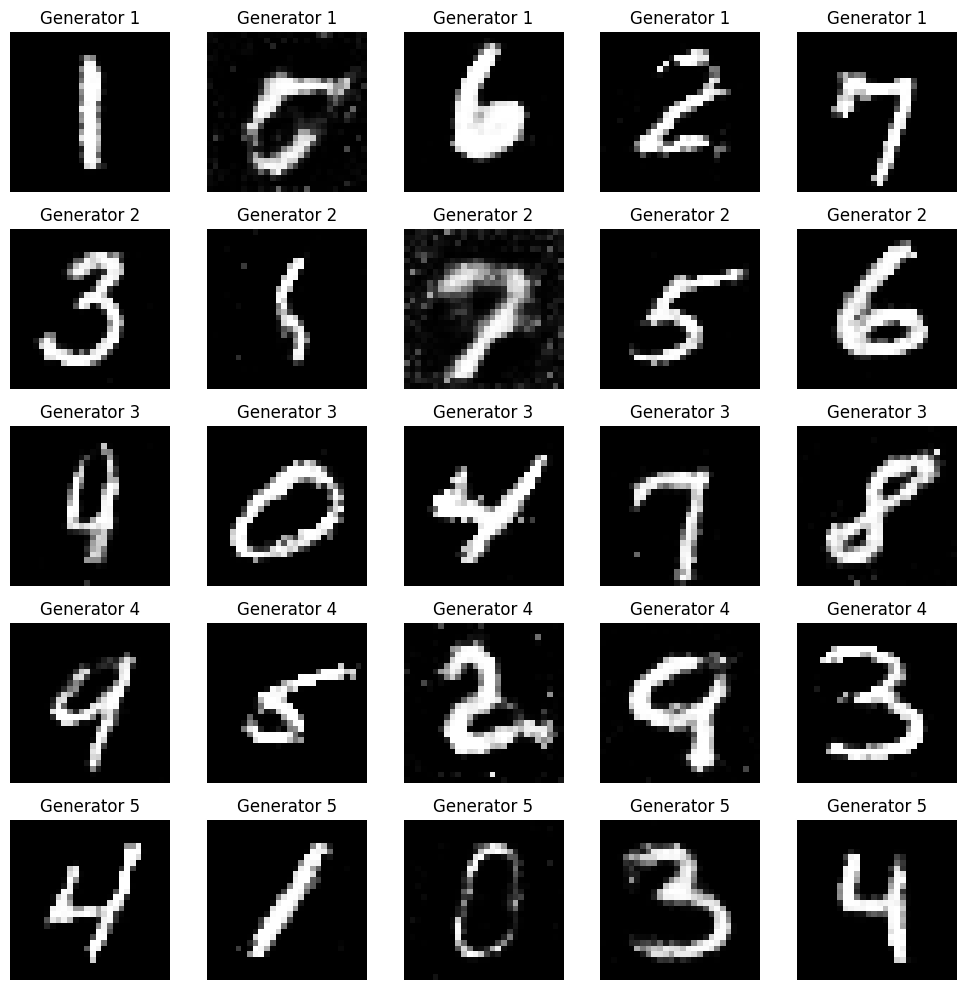

Epoch [96/100], Batch [0/188], D Loss: 1.3652, C Loss: 1.6104, G Loss: -0.7312
Epoch [96/100], Batch [100/188], D Loss: 1.3539, C Loss: 1.6099, G Loss: -0.8559
Epoch [97/100], Batch [0/188], D Loss: 1.3868, C Loss: 1.6098, G Loss: -0.9155
Epoch [97/100], Batch [100/188], D Loss: 1.3630, C Loss: 1.6103, G Loss: -0.9005
Epoch [98/100], Batch [0/188], D Loss: 1.3528, C Loss: 1.6096, G Loss: -0.8459
Epoch [98/100], Batch [100/188], D Loss: 1.3634, C Loss: 1.6098, G Loss: -0.9210
Epoch [99/100], Batch [0/188], D Loss: 1.3742, C Loss: 1.6096, G Loss: -0.9065
Epoch [99/100], Batch [100/188], D Loss: 1.3447, C Loss: 1.6095, G Loss: -0.8682
Epoch [100/100], Batch [0/188], D Loss: 1.3733, C Loss: 1.6108, G Loss: -0.9457
Epoch [100/100], Batch [100/188], D Loss: 1.3531, C Loss: 1.6092, G Loss: -0.7032
Generating samples at epoch 100


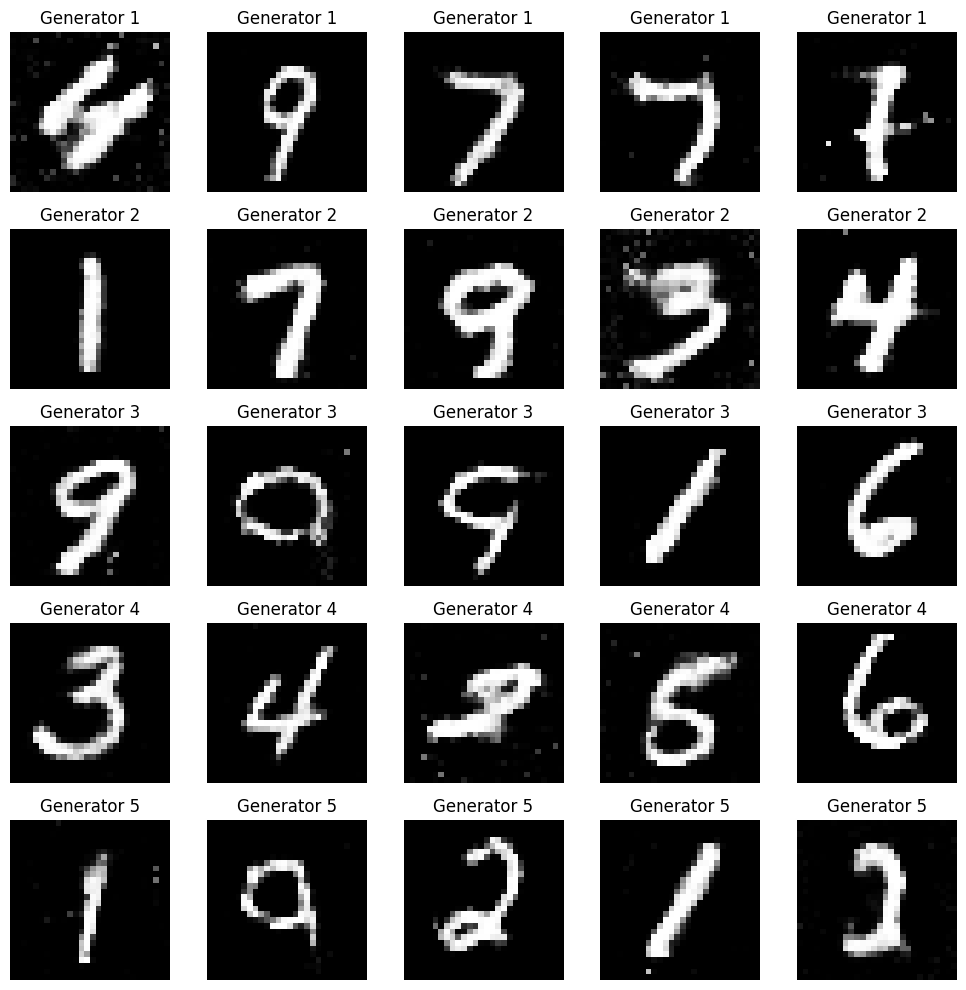

In [12]:


# Initialize models
shared_generator_layers = SharedGeneratorLayers().to(device)
shared_disc_class_layers = SharedDiscriminatorClassifierLayers().to(device)

generators = [Generator(latent_dim, shared_generator_layers).to(device) for _ in range(num_generators)]
discriminator = Discriminator(shared_disc_class_layers).to(device)
classifier = Classifier(shared_disc_class_layers, num_generators).to(device)

# Train the model
history = train_mgans(generators, discriminator, classifier, train_loader, latent_dim, num_epochs, beta, device, visualize_frequency)


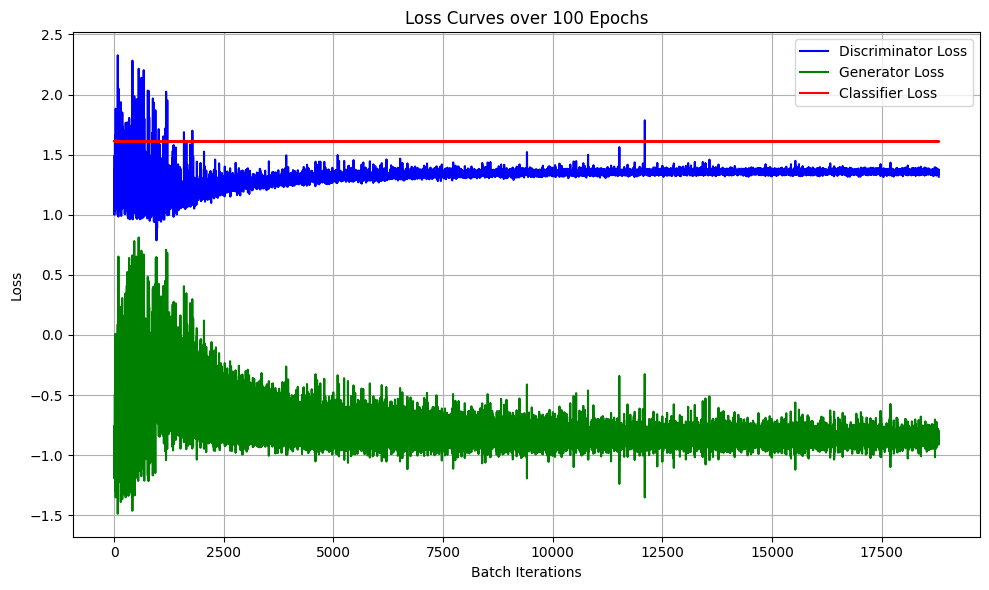

In [13]:
plot_training_history(history, num_epochs)

In [30]:
# Hyperparameters
batch_size = 64
num_epochs = 100
learning_rate = 0.0002
latent_dim = 100
num_generators = 5
beta = 0.5  # Diversity hyperparameter
visualize_frequency = 5

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Epoch [1/100], Batch [0/188], D Loss: 1.3752, C Loss: 0.8049, G Loss: -0.0999
Epoch [1/100], Batch [100/188], D Loss: 1.0879, C Loss: 0.8054, G Loss: 0.0263
Epoch [2/100], Batch [0/188], D Loss: 1.3658, C Loss: 0.8053, G Loss: 0.2401
Epoch [2/100], Batch [100/188], D Loss: 1.4135, C Loss: 0.8054, G Loss: 0.1048
Epoch [3/100], Batch [0/188], D Loss: 1.0003, C Loss: 0.8056, G Loss: -0.0753
Epoch [3/100], Batch [100/188], D Loss: 1.0275, C Loss: 0.8044, G Loss: 0.1011
Epoch [4/100], Batch [0/188], D Loss: 1.1862, C Loss: 0.8051, G Loss: -0.1615
Epoch [4/100], Batch [100/188], D Loss: 1.0331, C Loss: 0.8045, G Loss: -0.0650
Epoch [5/100], Batch [0/188], D Loss: 1.0581, C Loss: 0.8049, G Loss: -0.2881
Epoch [5/100], Batch [100/188], D Loss: 1.1155, C Loss: 0.8044, G Loss: 0.7508
Generating samples at epoch 5


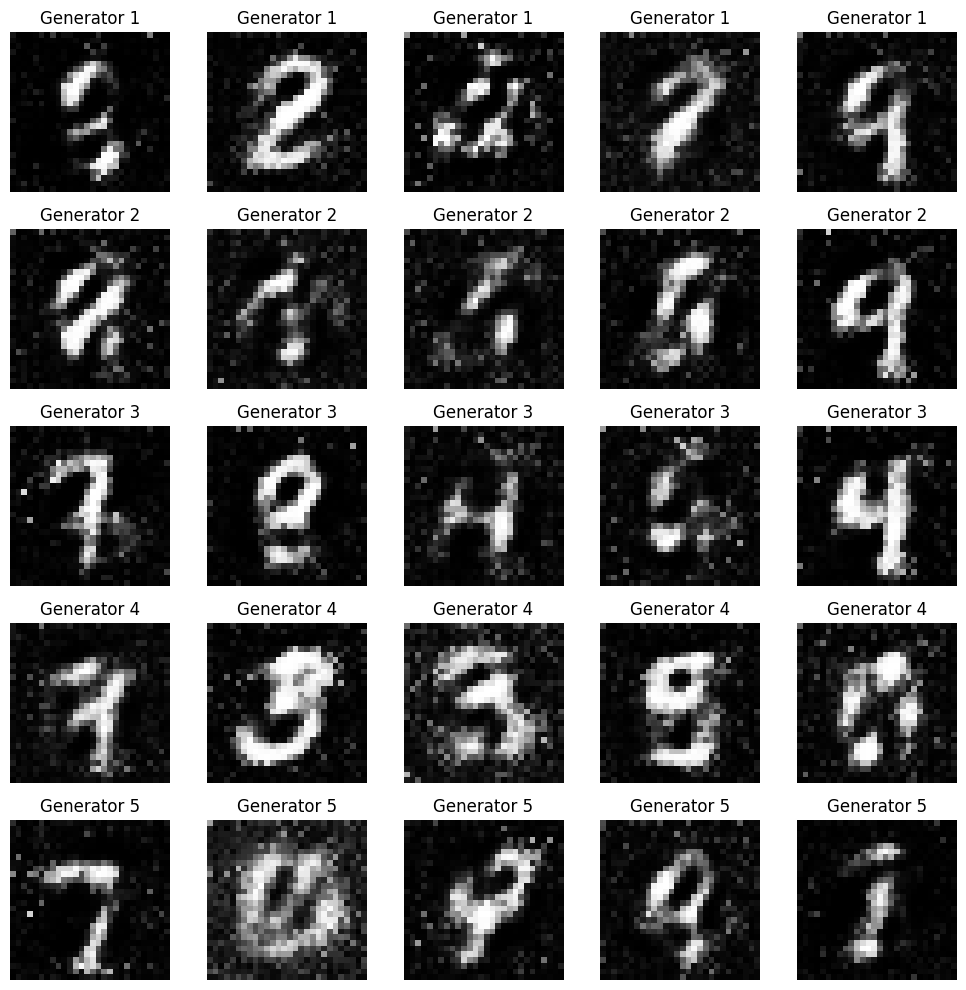

Epoch [6/100], Batch [0/188], D Loss: 1.4141, C Loss: 0.8050, G Loss: 0.2237
Epoch [6/100], Batch [100/188], D Loss: 1.2118, C Loss: 0.8030, G Loss: 0.5246
Epoch [7/100], Batch [0/188], D Loss: 1.2999, C Loss: 0.8043, G Loss: 0.2716
Epoch [7/100], Batch [100/188], D Loss: 1.1708, C Loss: 0.8068, G Loss: 0.1037
Epoch [8/100], Batch [0/188], D Loss: 1.1600, C Loss: 0.8038, G Loss: 0.0871
Epoch [8/100], Batch [100/188], D Loss: 1.0715, C Loss: 0.8037, G Loss: 0.1361
Epoch [9/100], Batch [0/188], D Loss: 1.1499, C Loss: 0.8045, G Loss: 0.0048
Epoch [9/100], Batch [100/188], D Loss: 1.2626, C Loss: 0.8042, G Loss: -0.0974
Epoch [10/100], Batch [0/188], D Loss: 1.2465, C Loss: 0.8038, G Loss: 0.6404
Epoch [10/100], Batch [100/188], D Loss: 1.1965, C Loss: 0.8046, G Loss: 0.1344
Generating samples at epoch 10


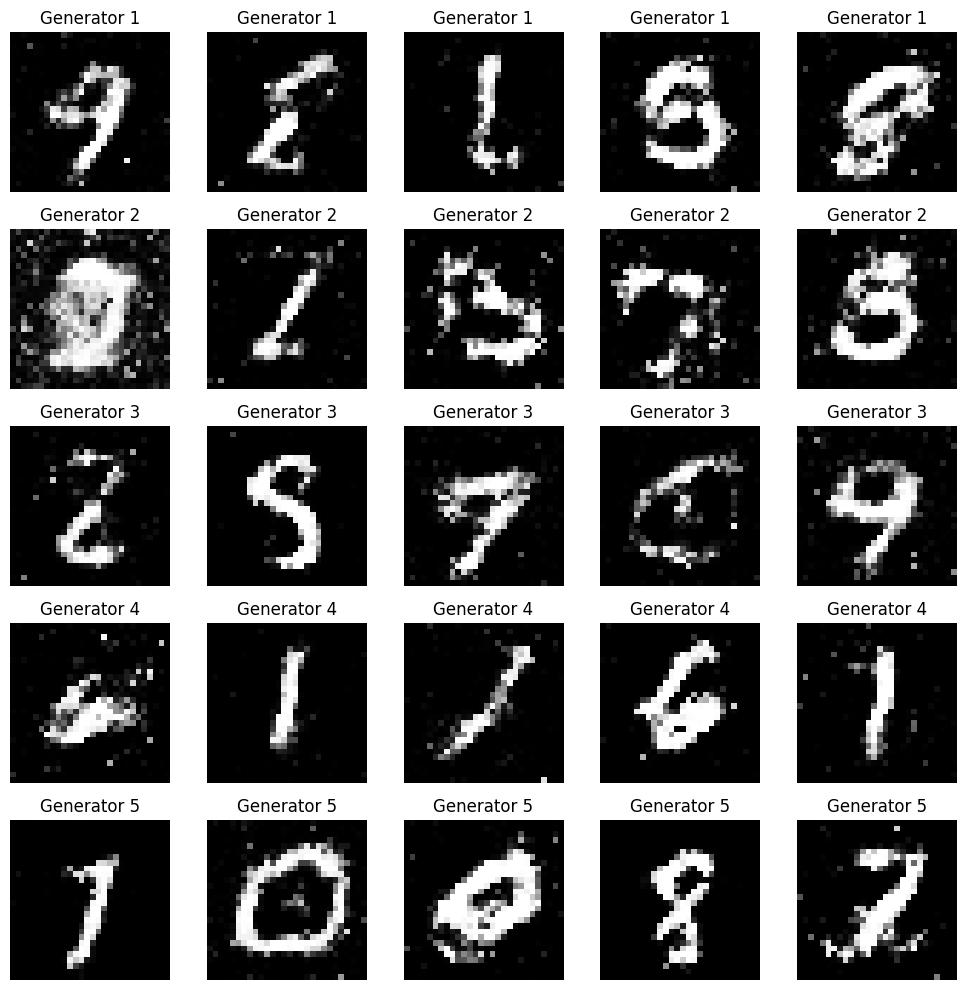

Epoch [11/100], Batch [0/188], D Loss: 1.2072, C Loss: 0.8050, G Loss: -0.0825
Epoch [11/100], Batch [100/188], D Loss: 1.2248, C Loss: 0.8055, G Loss: 0.2842
Epoch [12/100], Batch [0/188], D Loss: 1.1893, C Loss: 0.8056, G Loss: 0.2520
Epoch [12/100], Batch [100/188], D Loss: 1.1749, C Loss: 0.8061, G Loss: 0.0784
Epoch [13/100], Batch [0/188], D Loss: 1.2265, C Loss: 0.8049, G Loss: 0.1541
Epoch [13/100], Batch [100/188], D Loss: 1.2192, C Loss: 0.8042, G Loss: 0.1474
Epoch [14/100], Batch [0/188], D Loss: 1.1966, C Loss: 0.8056, G Loss: 0.2375
Epoch [14/100], Batch [100/188], D Loss: 1.2079, C Loss: 0.8039, G Loss: 0.0727
Epoch [15/100], Batch [0/188], D Loss: 1.2301, C Loss: 0.8046, G Loss: -0.0841
Epoch [15/100], Batch [100/188], D Loss: 1.2334, C Loss: 0.8045, G Loss: 0.0519
Generating samples at epoch 15


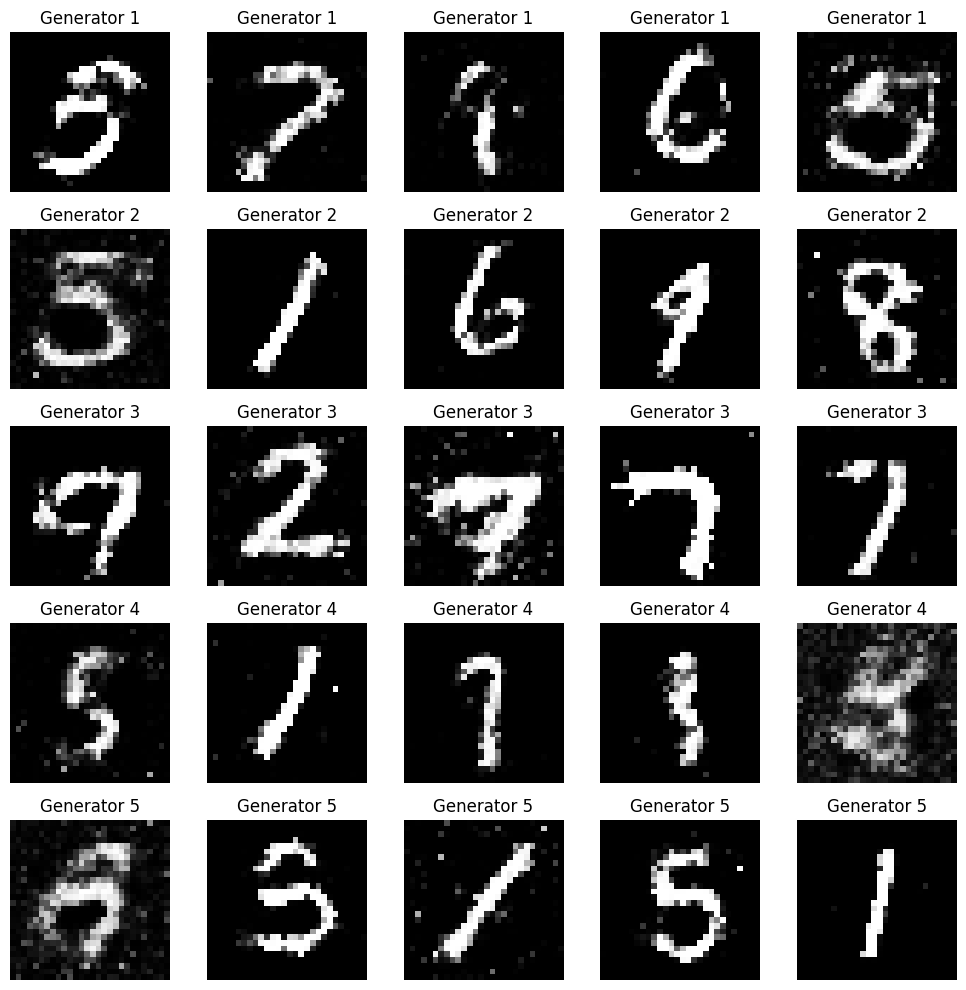

Epoch [16/100], Batch [0/188], D Loss: 1.2454, C Loss: 0.8050, G Loss: -0.0554
Epoch [16/100], Batch [100/188], D Loss: 1.2816, C Loss: 0.8044, G Loss: 0.0742
Epoch [17/100], Batch [0/188], D Loss: 1.2192, C Loss: 0.8039, G Loss: 0.1374
Epoch [17/100], Batch [100/188], D Loss: 1.2824, C Loss: 0.8043, G Loss: 0.1524
Epoch [18/100], Batch [0/188], D Loss: 1.2972, C Loss: 0.8050, G Loss: 0.2697
Epoch [18/100], Batch [100/188], D Loss: 1.2711, C Loss: 0.8049, G Loss: -0.0442
Epoch [19/100], Batch [0/188], D Loss: 1.2769, C Loss: 0.8040, G Loss: 0.0010
Epoch [19/100], Batch [100/188], D Loss: 1.2528, C Loss: 0.8047, G Loss: 0.1323
Epoch [20/100], Batch [0/188], D Loss: 1.2859, C Loss: 0.8045, G Loss: -0.0477
Epoch [20/100], Batch [100/188], D Loss: 1.2591, C Loss: 0.8055, G Loss: 0.1762
Generating samples at epoch 20


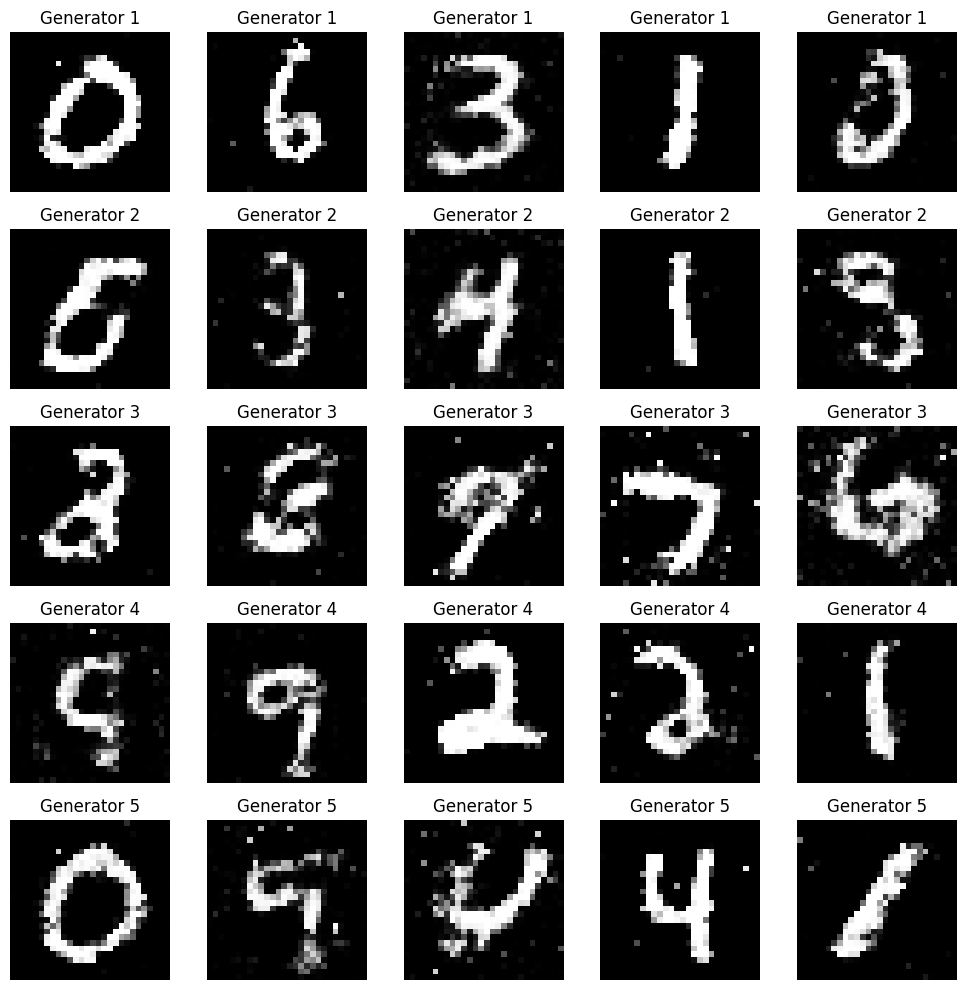

Epoch [21/100], Batch [0/188], D Loss: 1.2605, C Loss: 0.8058, G Loss: -0.0281
Epoch [21/100], Batch [100/188], D Loss: 1.2916, C Loss: 0.8047, G Loss: -0.0605
Epoch [22/100], Batch [0/188], D Loss: 1.3199, C Loss: 0.8044, G Loss: -0.0102
Epoch [22/100], Batch [100/188], D Loss: 1.2946, C Loss: 0.8044, G Loss: 0.0322
Epoch [23/100], Batch [0/188], D Loss: 1.2769, C Loss: 0.8047, G Loss: 0.0069
Epoch [23/100], Batch [100/188], D Loss: 1.3186, C Loss: 0.8048, G Loss: 0.1882
Epoch [24/100], Batch [0/188], D Loss: 1.3056, C Loss: 0.8048, G Loss: -0.0196
Epoch [24/100], Batch [100/188], D Loss: 1.2892, C Loss: 0.8052, G Loss: 0.0682
Epoch [25/100], Batch [0/188], D Loss: 1.3021, C Loss: 0.8043, G Loss: -0.0000
Epoch [25/100], Batch [100/188], D Loss: 1.2888, C Loss: 0.8045, G Loss: 0.0042
Generating samples at epoch 25


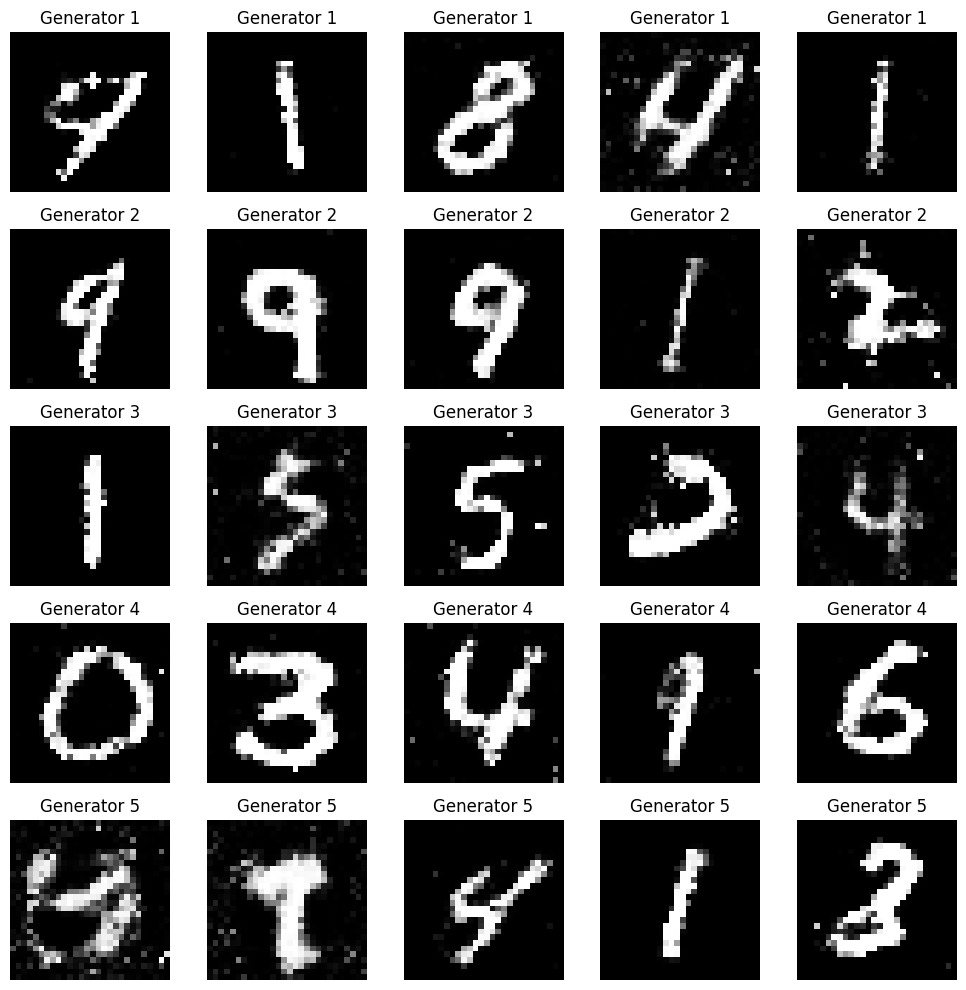

Epoch [26/100], Batch [0/188], D Loss: 1.3096, C Loss: 0.8050, G Loss: -0.0537
Epoch [26/100], Batch [100/188], D Loss: 1.2938, C Loss: 0.8049, G Loss: 0.0637
Epoch [27/100], Batch [0/188], D Loss: 1.3240, C Loss: 0.8048, G Loss: 0.0516
Epoch [27/100], Batch [100/188], D Loss: 1.3075, C Loss: 0.8055, G Loss: -0.0116
Epoch [28/100], Batch [0/188], D Loss: 1.2981, C Loss: 0.8049, G Loss: 0.0196
Epoch [28/100], Batch [100/188], D Loss: 1.3152, C Loss: 0.8051, G Loss: 0.0408
Epoch [29/100], Batch [0/188], D Loss: 1.3351, C Loss: 0.8041, G Loss: -0.1535
Epoch [29/100], Batch [100/188], D Loss: 1.3277, C Loss: 0.8051, G Loss: 0.0518
Epoch [30/100], Batch [0/188], D Loss: 1.3988, C Loss: 0.8045, G Loss: -0.1643
Epoch [30/100], Batch [100/188], D Loss: 1.2870, C Loss: 0.8043, G Loss: 0.0011
Generating samples at epoch 30


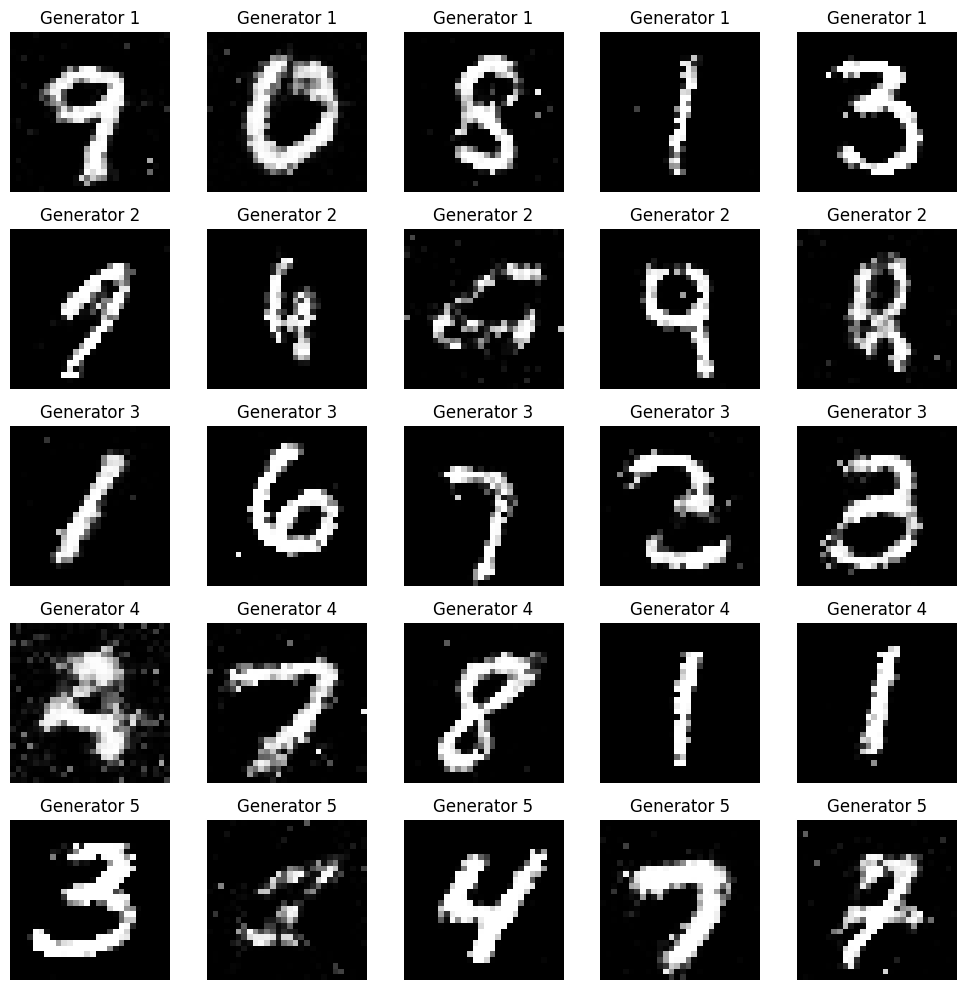

Epoch [31/100], Batch [0/188], D Loss: 1.3438, C Loss: 0.8046, G Loss: -0.0801
Epoch [31/100], Batch [100/188], D Loss: 1.3313, C Loss: 0.8050, G Loss: -0.0930
Epoch [32/100], Batch [0/188], D Loss: 1.2974, C Loss: 0.8051, G Loss: 0.0380
Epoch [32/100], Batch [100/188], D Loss: 1.2996, C Loss: 0.8050, G Loss: -0.0820
Epoch [33/100], Batch [0/188], D Loss: 1.3161, C Loss: 0.8050, G Loss: 0.1222
Epoch [33/100], Batch [100/188], D Loss: 1.3591, C Loss: 0.8045, G Loss: 0.1369
Epoch [34/100], Batch [0/188], D Loss: 1.3518, C Loss: 0.8050, G Loss: -0.0230
Epoch [34/100], Batch [100/188], D Loss: 1.3593, C Loss: 0.8047, G Loss: 0.0771
Epoch [35/100], Batch [0/188], D Loss: 1.3278, C Loss: 0.8052, G Loss: -0.0173
Epoch [35/100], Batch [100/188], D Loss: 1.3014, C Loss: 0.8045, G Loss: -0.0601
Generating samples at epoch 35


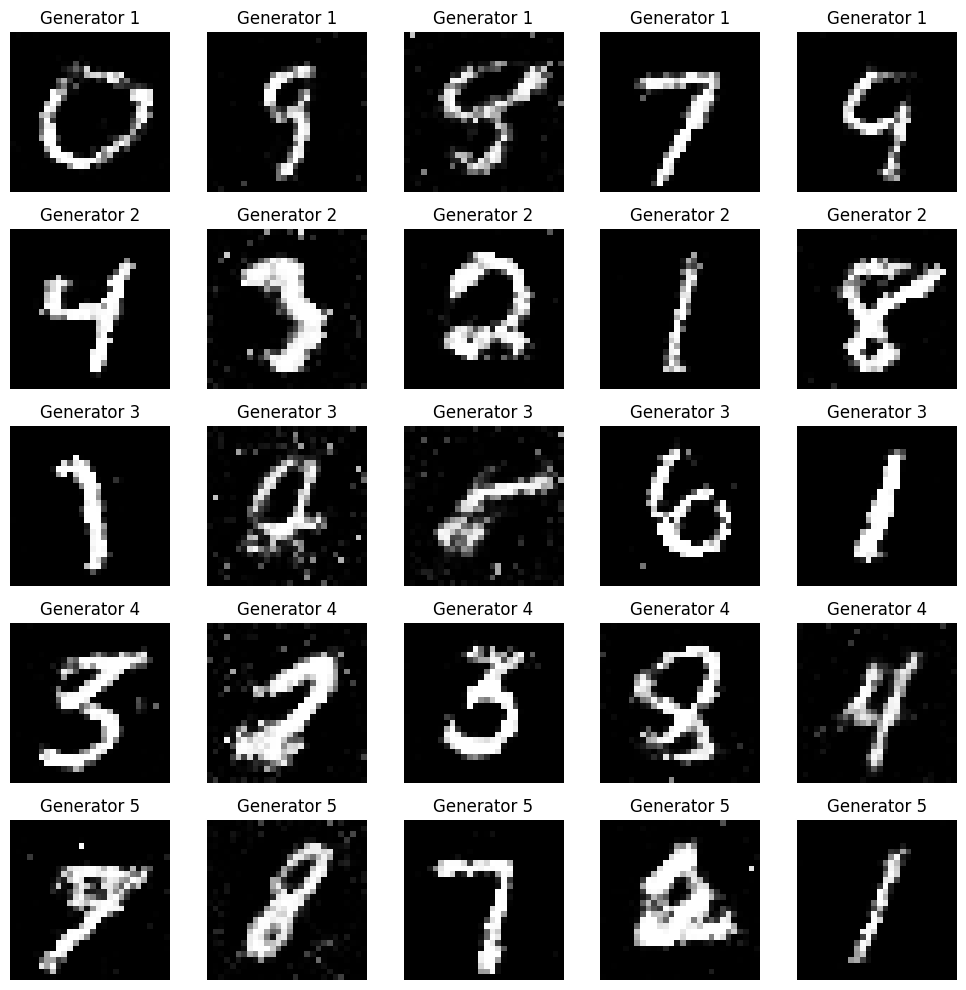

Epoch [36/100], Batch [0/188], D Loss: 1.3717, C Loss: 0.8043, G Loss: 0.0946
Epoch [36/100], Batch [100/188], D Loss: 1.3249, C Loss: 0.8042, G Loss: 0.0629
Epoch [37/100], Batch [0/188], D Loss: 1.3367, C Loss: 0.8048, G Loss: 0.0315
Epoch [37/100], Batch [100/188], D Loss: 1.3296, C Loss: 0.8044, G Loss: -0.0467
Epoch [38/100], Batch [0/188], D Loss: 1.3236, C Loss: 0.8051, G Loss: -0.0126
Epoch [38/100], Batch [100/188], D Loss: 1.3454, C Loss: 0.8052, G Loss: -0.0088
Epoch [39/100], Batch [0/188], D Loss: 1.3328, C Loss: 0.8047, G Loss: -0.1118
Epoch [39/100], Batch [100/188], D Loss: 1.3473, C Loss: 0.8041, G Loss: -0.1251
Epoch [40/100], Batch [0/188], D Loss: 1.3491, C Loss: 0.8040, G Loss: 0.1127
Epoch [40/100], Batch [100/188], D Loss: 1.3643, C Loss: 0.8049, G Loss: -0.0167
Generating samples at epoch 40


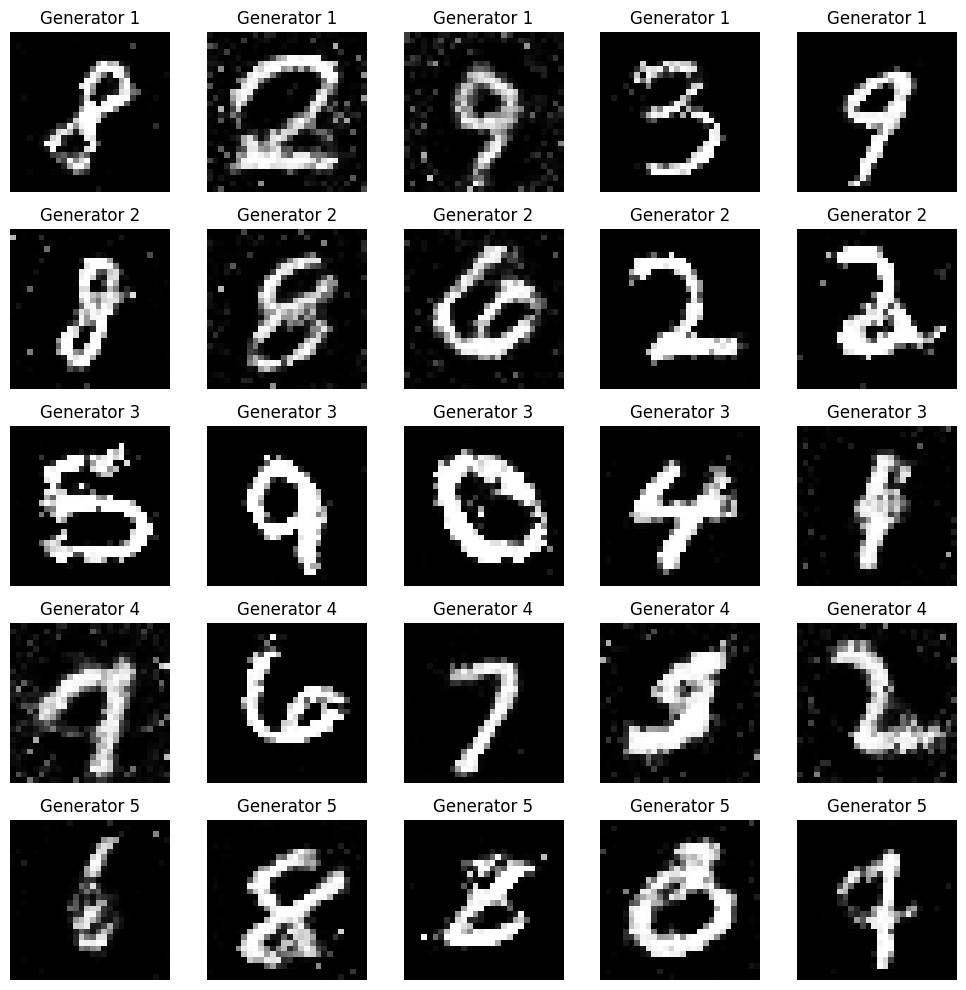

Epoch [41/100], Batch [0/188], D Loss: 1.3564, C Loss: 0.8049, G Loss: -0.1595
Epoch [41/100], Batch [100/188], D Loss: 1.3418, C Loss: 0.8044, G Loss: 0.1257
Epoch [42/100], Batch [0/188], D Loss: 1.3385, C Loss: 0.8046, G Loss: 0.1677
Epoch [42/100], Batch [100/188], D Loss: 1.3323, C Loss: 0.8044, G Loss: 0.0781
Epoch [43/100], Batch [0/188], D Loss: 1.3380, C Loss: 0.8049, G Loss: -0.1302
Epoch [43/100], Batch [100/188], D Loss: 1.3220, C Loss: 0.8049, G Loss: 0.0213
Epoch [44/100], Batch [0/188], D Loss: 1.3268, C Loss: 0.8048, G Loss: -0.1114
Epoch [44/100], Batch [100/188], D Loss: 1.3241, C Loss: 0.8044, G Loss: 0.0111
Epoch [45/100], Batch [0/188], D Loss: 1.3583, C Loss: 0.8044, G Loss: 0.0014
Epoch [45/100], Batch [100/188], D Loss: 1.3438, C Loss: 0.8044, G Loss: 0.0308
Generating samples at epoch 45


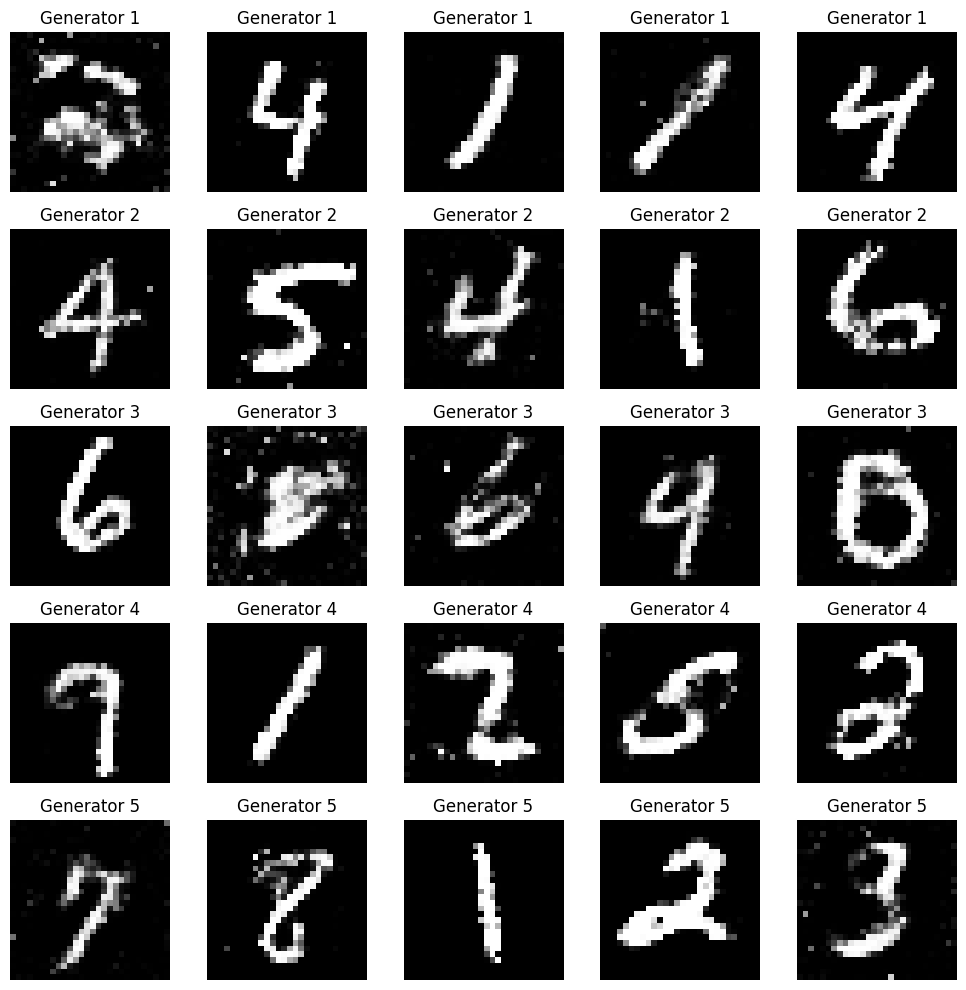

Epoch [46/100], Batch [0/188], D Loss: 1.3278, C Loss: 0.8041, G Loss: -0.0327
Epoch [46/100], Batch [100/188], D Loss: 1.3825, C Loss: 0.8045, G Loss: -0.0665
Epoch [47/100], Batch [0/188], D Loss: 1.3381, C Loss: 0.8049, G Loss: -0.0552
Epoch [47/100], Batch [100/188], D Loss: 1.3150, C Loss: 0.8047, G Loss: -0.0339
Epoch [48/100], Batch [0/188], D Loss: 1.3519, C Loss: 0.8049, G Loss: -0.1449
Epoch [48/100], Batch [100/188], D Loss: 1.3405, C Loss: 0.8052, G Loss: -0.0202
Epoch [49/100], Batch [0/188], D Loss: 1.3639, C Loss: 0.8051, G Loss: 0.0280
Epoch [49/100], Batch [100/188], D Loss: 1.3369, C Loss: 0.8047, G Loss: -0.0616
Epoch [50/100], Batch [0/188], D Loss: 1.3560, C Loss: 0.8047, G Loss: 0.0183
Epoch [50/100], Batch [100/188], D Loss: 1.3333, C Loss: 0.8044, G Loss: -0.1332
Generating samples at epoch 50


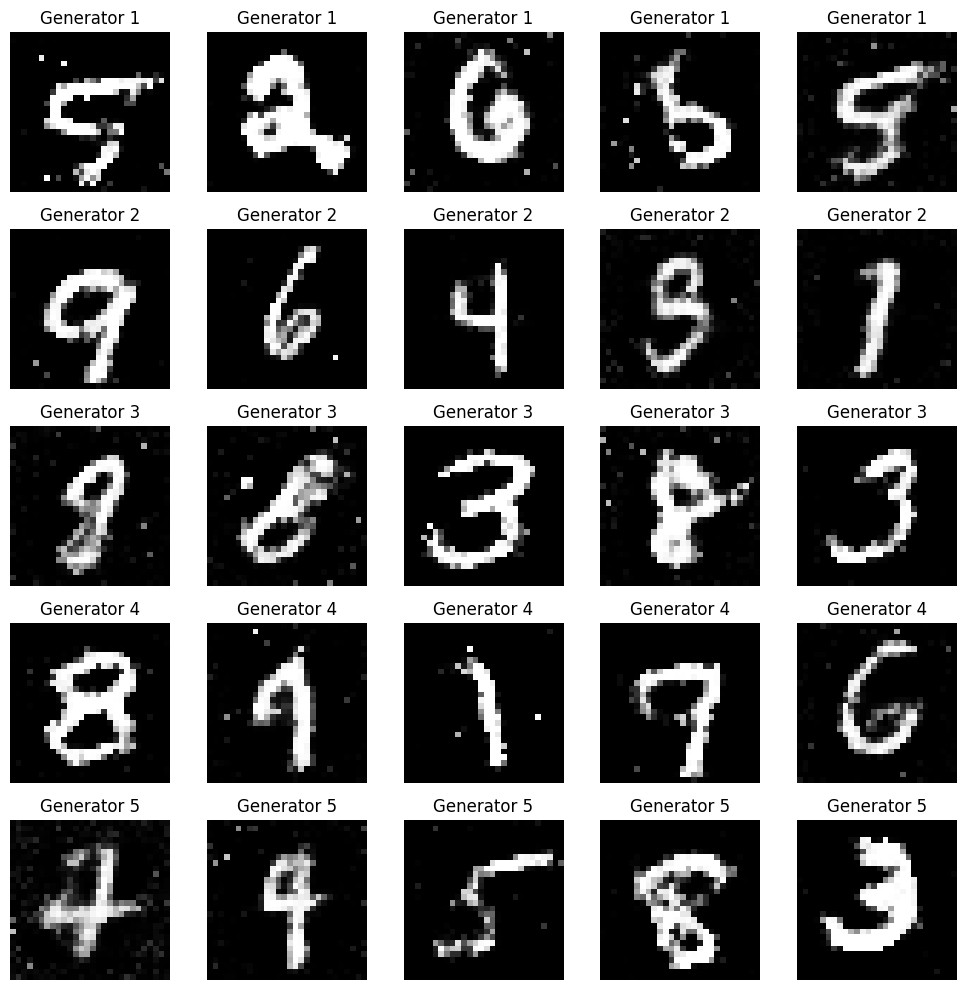

Epoch [51/100], Batch [0/188], D Loss: 1.3581, C Loss: 0.8044, G Loss: 0.1024
Epoch [51/100], Batch [100/188], D Loss: 1.3512, C Loss: 0.8046, G Loss: 0.0388
Epoch [52/100], Batch [0/188], D Loss: 1.3372, C Loss: 0.8045, G Loss: 0.0312
Epoch [52/100], Batch [100/188], D Loss: 1.3354, C Loss: 0.8050, G Loss: -0.1113
Epoch [53/100], Batch [0/188], D Loss: 1.3574, C Loss: 0.8048, G Loss: -0.0413
Epoch [53/100], Batch [100/188], D Loss: 1.3640, C Loss: 0.8049, G Loss: -0.0704
Epoch [54/100], Batch [0/188], D Loss: 1.3356, C Loss: 0.8046, G Loss: -0.0372
Epoch [54/100], Batch [100/188], D Loss: 1.3445, C Loss: 0.8045, G Loss: 0.0261
Epoch [55/100], Batch [0/188], D Loss: 1.3419, C Loss: 0.8052, G Loss: -0.0245
Epoch [55/100], Batch [100/188], D Loss: 1.3366, C Loss: 0.8046, G Loss: -0.0752
Generating samples at epoch 55


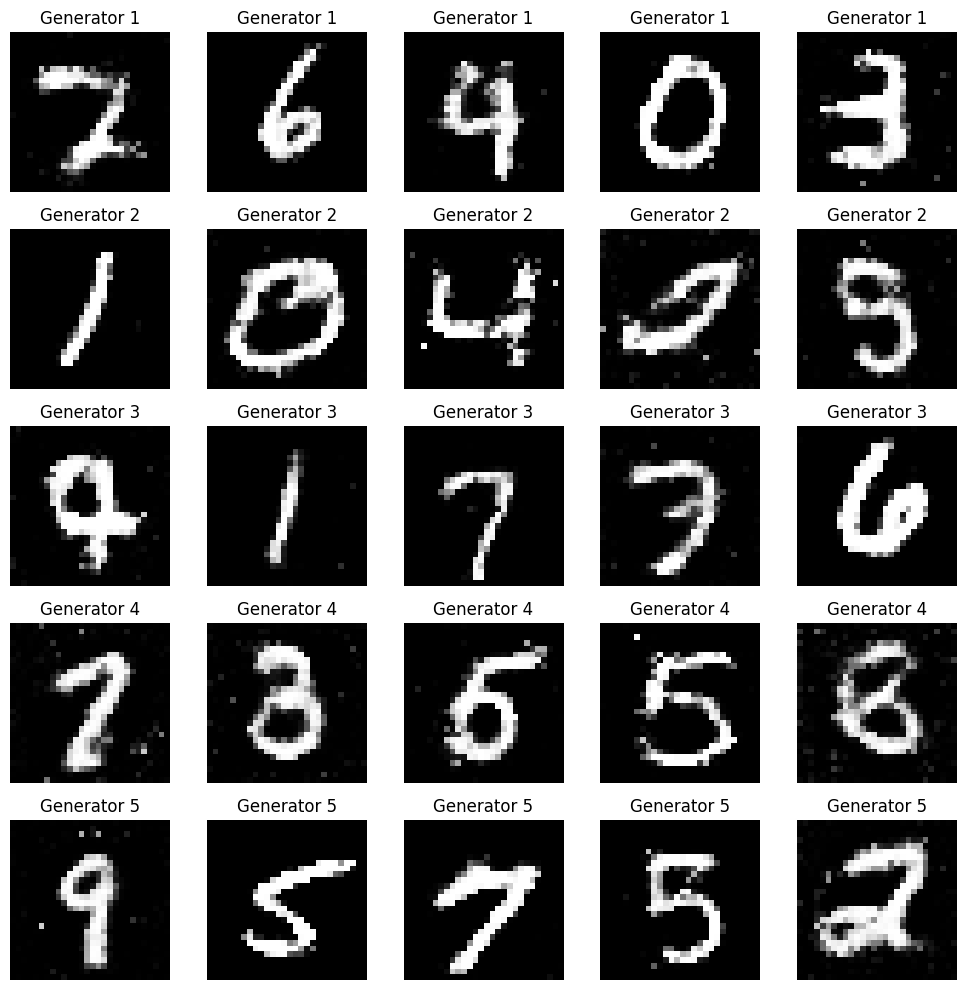

Epoch [56/100], Batch [0/188], D Loss: 1.3575, C Loss: 0.8051, G Loss: 0.1358
Epoch [56/100], Batch [100/188], D Loss: 1.3524, C Loss: 0.8049, G Loss: -0.0550
Epoch [57/100], Batch [0/188], D Loss: 1.3995, C Loss: 0.8046, G Loss: -0.1484
Epoch [57/100], Batch [100/188], D Loss: 1.3425, C Loss: 0.8047, G Loss: -0.0730
Epoch [58/100], Batch [0/188], D Loss: 1.3552, C Loss: 0.8052, G Loss: -0.0830
Epoch [58/100], Batch [100/188], D Loss: 1.3557, C Loss: 0.8047, G Loss: -0.0456
Epoch [59/100], Batch [0/188], D Loss: 1.3699, C Loss: 0.8048, G Loss: -0.0217
Epoch [59/100], Batch [100/188], D Loss: 1.3275, C Loss: 0.8050, G Loss: -0.0510
Epoch [60/100], Batch [0/188], D Loss: 1.3574, C Loss: 0.8046, G Loss: -0.0926
Epoch [60/100], Batch [100/188], D Loss: 1.3607, C Loss: 0.8049, G Loss: 0.0419
Generating samples at epoch 60


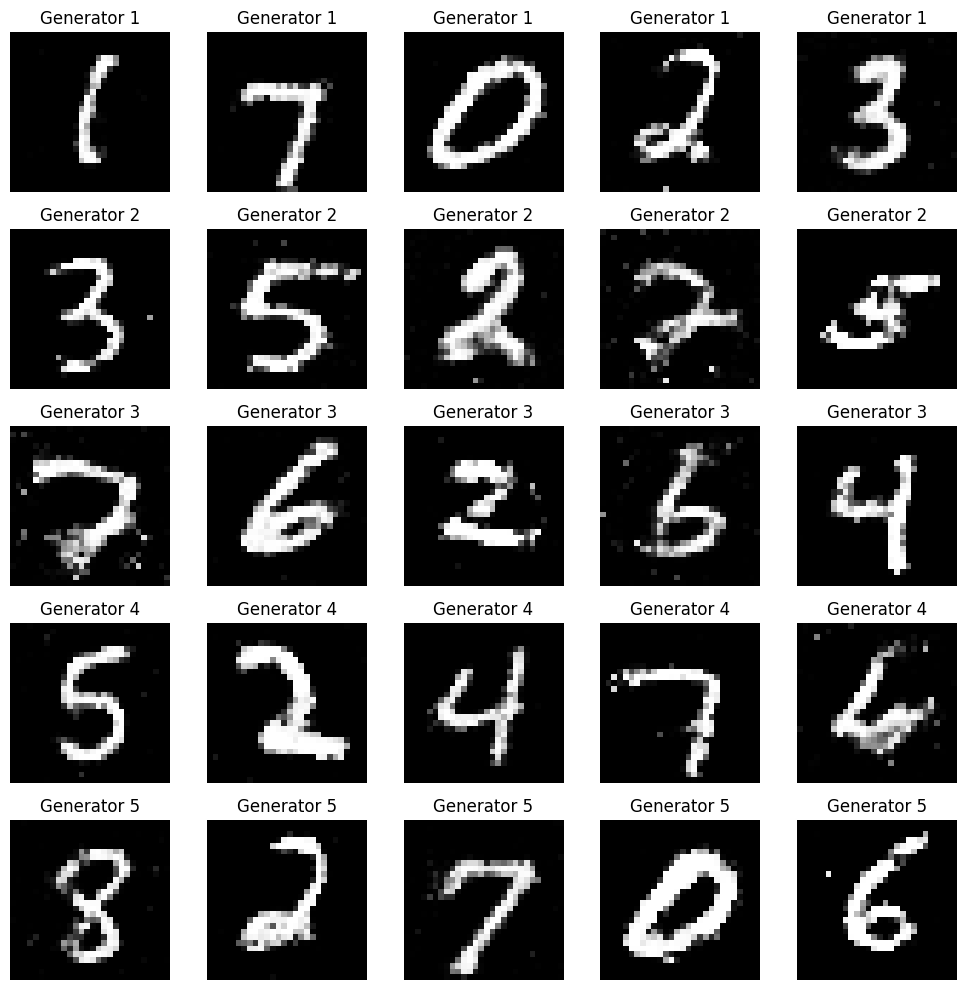

Epoch [61/100], Batch [0/188], D Loss: 1.3474, C Loss: 0.8049, G Loss: -0.0334
Epoch [61/100], Batch [100/188], D Loss: 1.3591, C Loss: 0.8052, G Loss: -0.0835
Epoch [62/100], Batch [0/188], D Loss: 1.3522, C Loss: 0.8050, G Loss: -0.0377
Epoch [62/100], Batch [100/188], D Loss: 1.3476, C Loss: 0.8049, G Loss: -0.0356
Epoch [63/100], Batch [0/188], D Loss: 1.3607, C Loss: 0.8047, G Loss: -0.0874
Epoch [63/100], Batch [100/188], D Loss: 1.3203, C Loss: 0.8053, G Loss: 0.0191
Epoch [64/100], Batch [0/188], D Loss: 1.3372, C Loss: 0.8049, G Loss: 0.0500
Epoch [64/100], Batch [100/188], D Loss: 1.3588, C Loss: 0.8048, G Loss: -0.1076
Epoch [65/100], Batch [0/188], D Loss: 1.3539, C Loss: 0.8044, G Loss: 0.0085
Epoch [65/100], Batch [100/188], D Loss: 1.3710, C Loss: 0.8044, G Loss: -0.0038
Generating samples at epoch 65


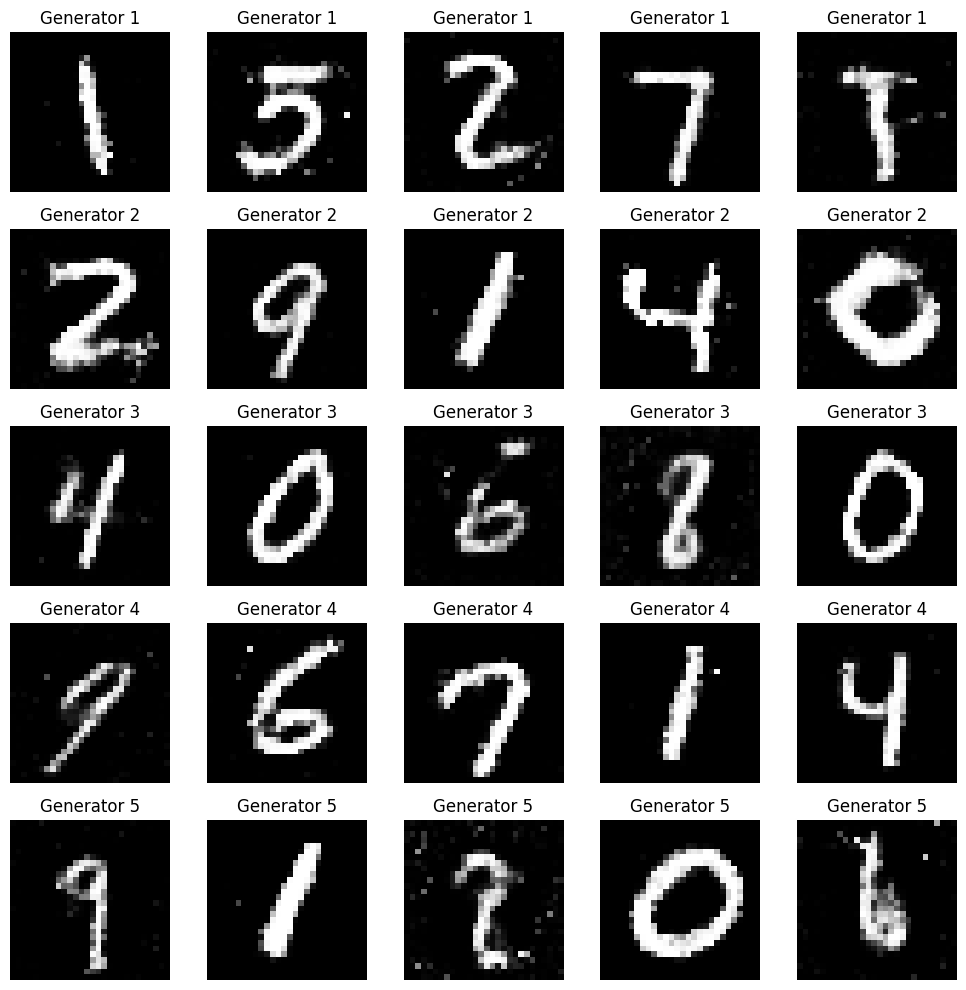

Epoch [66/100], Batch [0/188], D Loss: 1.3541, C Loss: 0.8049, G Loss: 0.0160
Epoch [66/100], Batch [100/188], D Loss: 1.3613, C Loss: 0.8049, G Loss: -0.0636
Epoch [67/100], Batch [0/188], D Loss: 1.3680, C Loss: 0.8044, G Loss: -0.0510
Epoch [67/100], Batch [100/188], D Loss: 1.3310, C Loss: 0.8052, G Loss: -0.0261
Epoch [68/100], Batch [0/188], D Loss: 1.3622, C Loss: 0.8049, G Loss: -0.0934
Epoch [68/100], Batch [100/188], D Loss: 1.3615, C Loss: 0.8050, G Loss: -0.0064
Epoch [69/100], Batch [0/188], D Loss: 1.3381, C Loss: 0.8045, G Loss: -0.0549
Epoch [69/100], Batch [100/188], D Loss: 1.3462, C Loss: 0.8050, G Loss: -0.0886
Epoch [70/100], Batch [0/188], D Loss: 1.3490, C Loss: 0.8052, G Loss: -0.0258
Epoch [70/100], Batch [100/188], D Loss: 1.3614, C Loss: 0.8045, G Loss: -0.0300
Generating samples at epoch 70


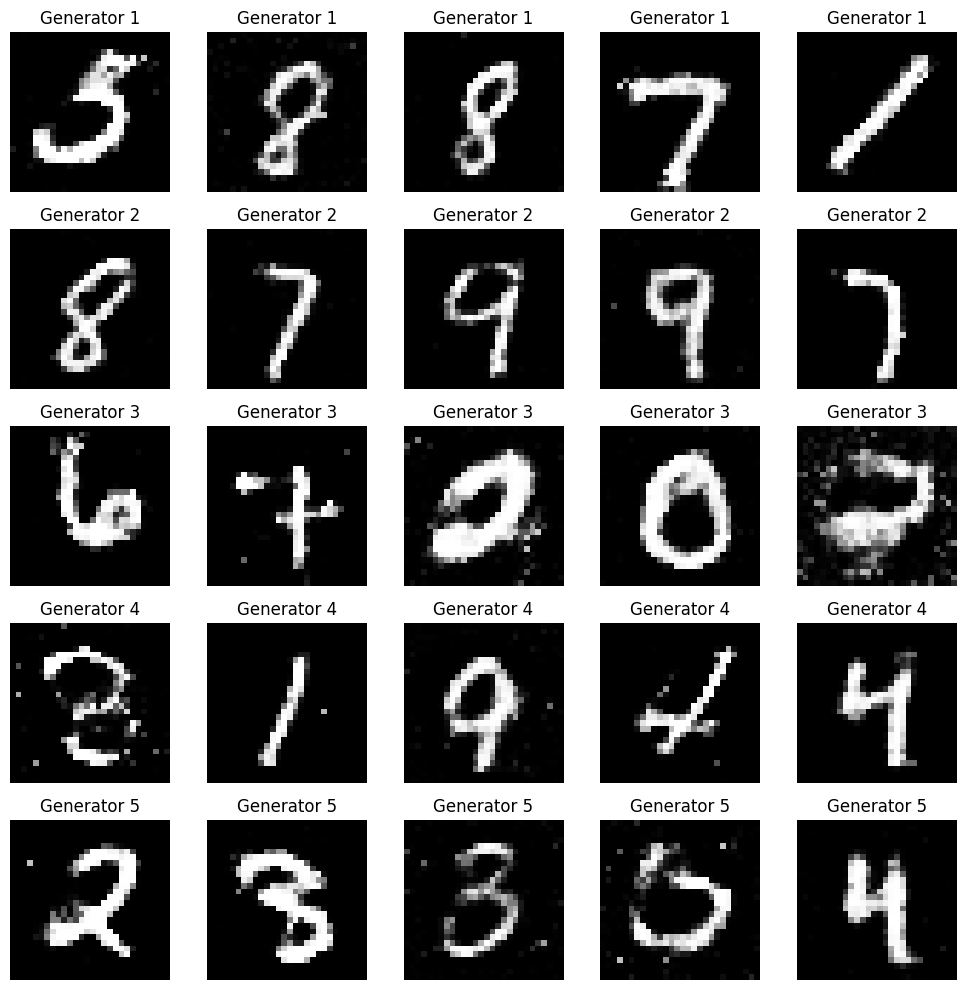

Epoch [71/100], Batch [0/188], D Loss: 1.3636, C Loss: 0.8047, G Loss: -0.0859
Epoch [71/100], Batch [100/188], D Loss: 1.3587, C Loss: 0.8050, G Loss: -0.0339
Epoch [72/100], Batch [0/188], D Loss: 1.3660, C Loss: 0.8043, G Loss: -0.0675
Epoch [72/100], Batch [100/188], D Loss: 1.3567, C Loss: 0.8043, G Loss: -0.0179
Epoch [73/100], Batch [0/188], D Loss: 1.3896, C Loss: 0.8043, G Loss: 0.0912
Epoch [73/100], Batch [100/188], D Loss: 1.3550, C Loss: 0.8045, G Loss: -0.0984
Epoch [74/100], Batch [0/188], D Loss: 1.3602, C Loss: 0.8051, G Loss: 0.0114
Epoch [74/100], Batch [100/188], D Loss: 1.3522, C Loss: 0.8042, G Loss: -0.0143
Epoch [75/100], Batch [0/188], D Loss: 1.3459, C Loss: 0.8042, G Loss: -0.0043
Epoch [75/100], Batch [100/188], D Loss: 1.3680, C Loss: 0.8050, G Loss: 0.0777
Generating samples at epoch 75


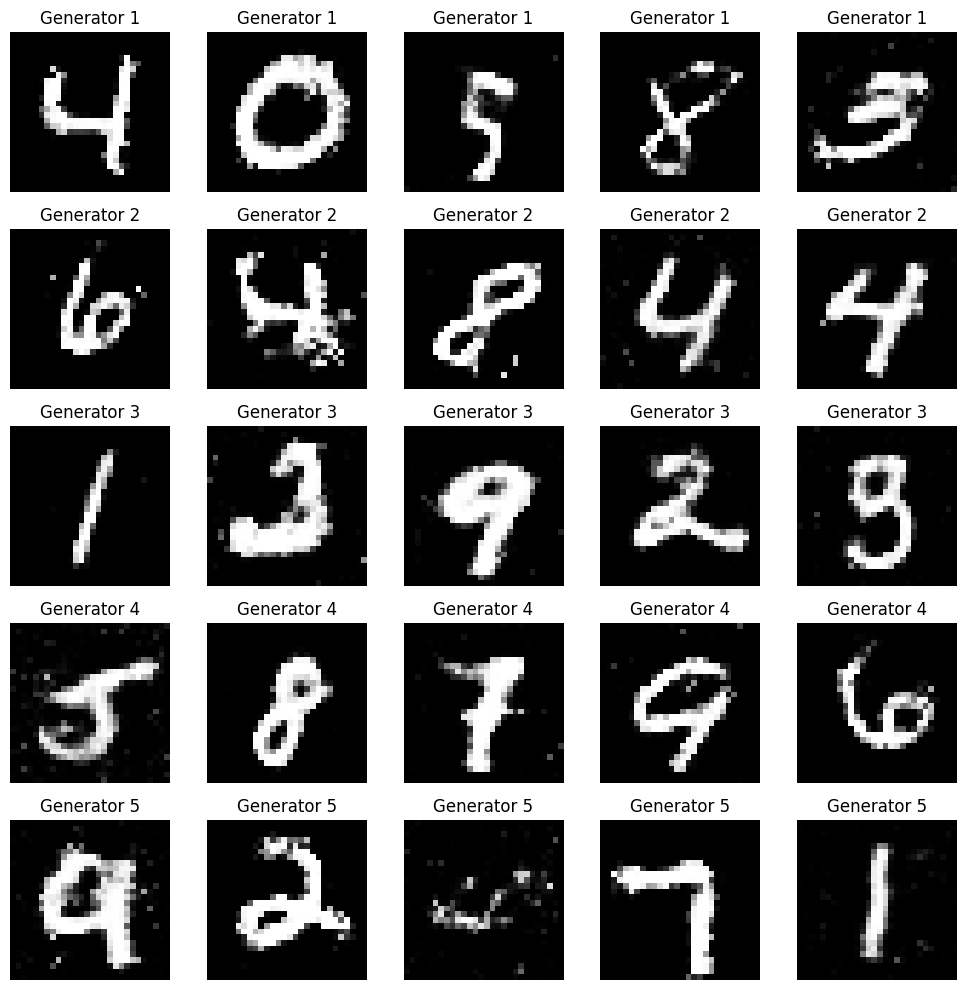

Epoch [76/100], Batch [0/188], D Loss: 1.3354, C Loss: 0.8043, G Loss: -0.0239
Epoch [76/100], Batch [100/188], D Loss: 1.3780, C Loss: 0.8051, G Loss: -0.0544
Epoch [77/100], Batch [0/188], D Loss: 1.3840, C Loss: 0.8050, G Loss: -0.0719
Epoch [77/100], Batch [100/188], D Loss: 1.3470, C Loss: 0.8050, G Loss: -0.0566
Epoch [78/100], Batch [0/188], D Loss: 1.3784, C Loss: 0.8047, G Loss: -0.1544
Epoch [78/100], Batch [100/188], D Loss: 1.3420, C Loss: 0.8053, G Loss: -0.0977
Epoch [79/100], Batch [0/188], D Loss: 1.3475, C Loss: 0.8045, G Loss: -0.0714
Epoch [79/100], Batch [100/188], D Loss: 1.3373, C Loss: 0.8047, G Loss: -0.0253
Epoch [80/100], Batch [0/188], D Loss: 1.3598, C Loss: 0.8046, G Loss: -0.0816
Epoch [80/100], Batch [100/188], D Loss: 1.3385, C Loss: 0.8051, G Loss: -0.0627
Generating samples at epoch 80


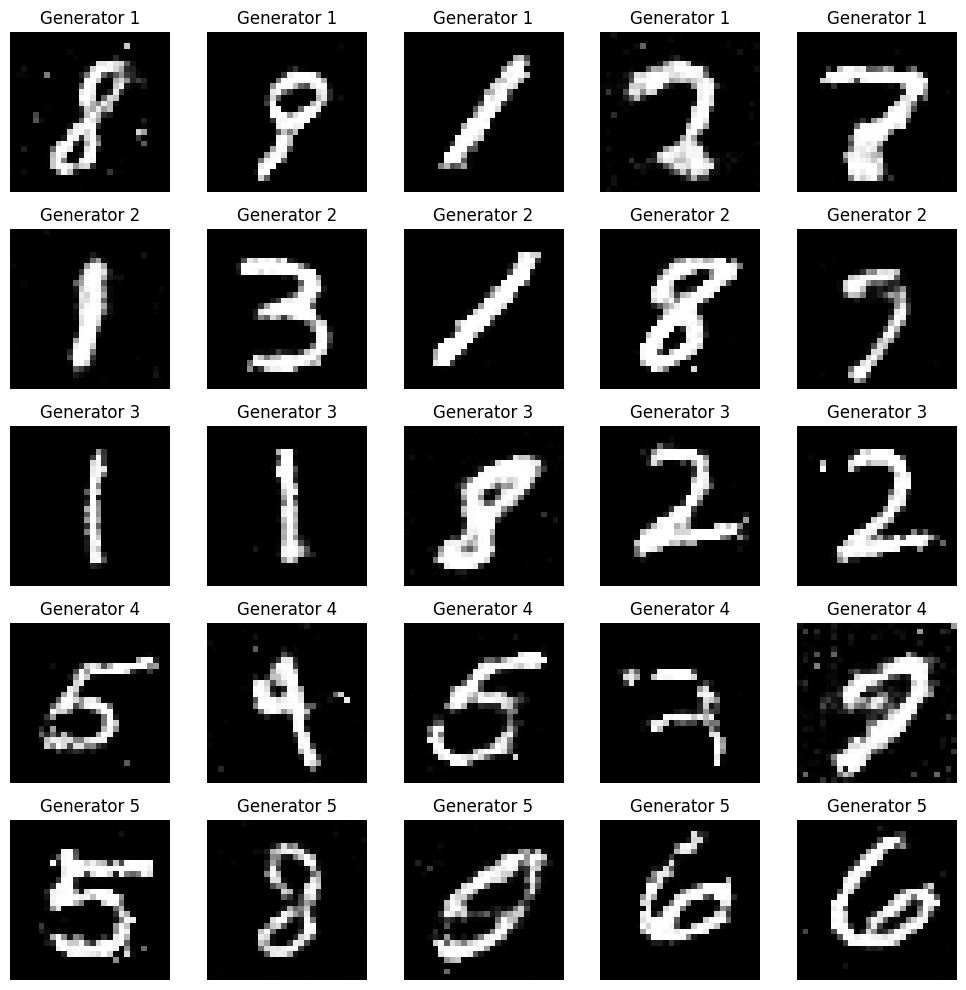

Epoch [81/100], Batch [0/188], D Loss: 1.3527, C Loss: 0.8043, G Loss: -0.0617
Epoch [81/100], Batch [100/188], D Loss: 1.3581, C Loss: 0.8046, G Loss: 0.0098
Epoch [82/100], Batch [0/188], D Loss: 1.3744, C Loss: 0.8050, G Loss: 0.0001
Epoch [82/100], Batch [100/188], D Loss: 1.3589, C Loss: 0.8048, G Loss: 0.0364
Epoch [83/100], Batch [0/188], D Loss: 1.3513, C Loss: 0.8045, G Loss: -0.0914
Epoch [83/100], Batch [100/188], D Loss: 1.3334, C Loss: 0.8054, G Loss: -0.0133
Epoch [84/100], Batch [0/188], D Loss: 1.3326, C Loss: 0.8048, G Loss: -0.0242
Epoch [84/100], Batch [100/188], D Loss: 1.3630, C Loss: 0.8048, G Loss: -0.0989
Epoch [85/100], Batch [0/188], D Loss: 1.3438, C Loss: 0.8055, G Loss: 0.0039
Epoch [85/100], Batch [100/188], D Loss: 1.3687, C Loss: 0.8049, G Loss: -0.0678
Generating samples at epoch 85


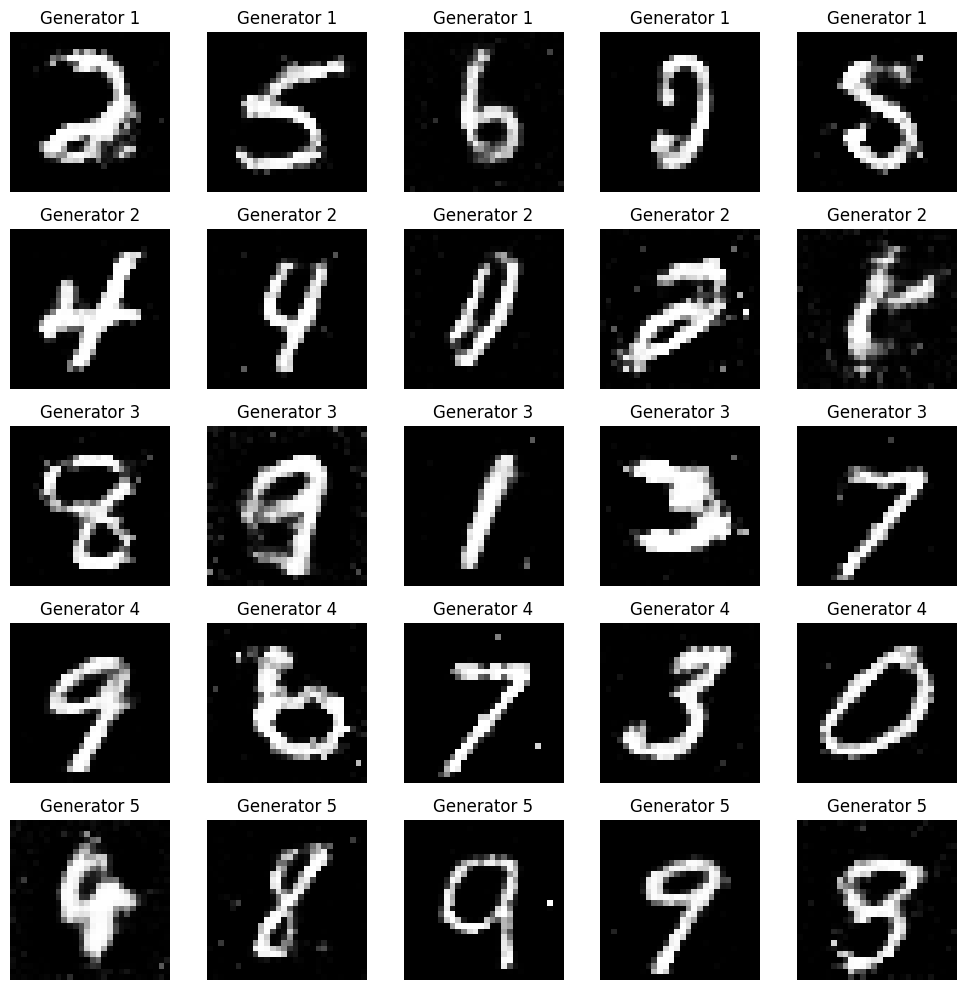

Epoch [86/100], Batch [0/188], D Loss: 1.3476, C Loss: 0.8044, G Loss: -0.0304
Epoch [86/100], Batch [100/188], D Loss: 1.3509, C Loss: 0.8044, G Loss: -0.0872
Epoch [87/100], Batch [0/188], D Loss: 1.3610, C Loss: 0.8045, G Loss: -0.0661
Epoch [87/100], Batch [100/188], D Loss: 1.3516, C Loss: 0.8046, G Loss: -0.0712
Epoch [88/100], Batch [0/188], D Loss: 1.3427, C Loss: 0.8045, G Loss: -0.0044
Epoch [88/100], Batch [100/188], D Loss: 1.3756, C Loss: 0.8041, G Loss: -0.0528
Epoch [89/100], Batch [0/188], D Loss: 1.3493, C Loss: 0.8045, G Loss: -0.0132
Epoch [89/100], Batch [100/188], D Loss: 1.3449, C Loss: 0.8048, G Loss: -0.0416
Epoch [90/100], Batch [0/188], D Loss: 1.3554, C Loss: 0.8051, G Loss: -0.0875
Epoch [90/100], Batch [100/188], D Loss: 1.3862, C Loss: 0.8047, G Loss: -0.0488
Generating samples at epoch 90


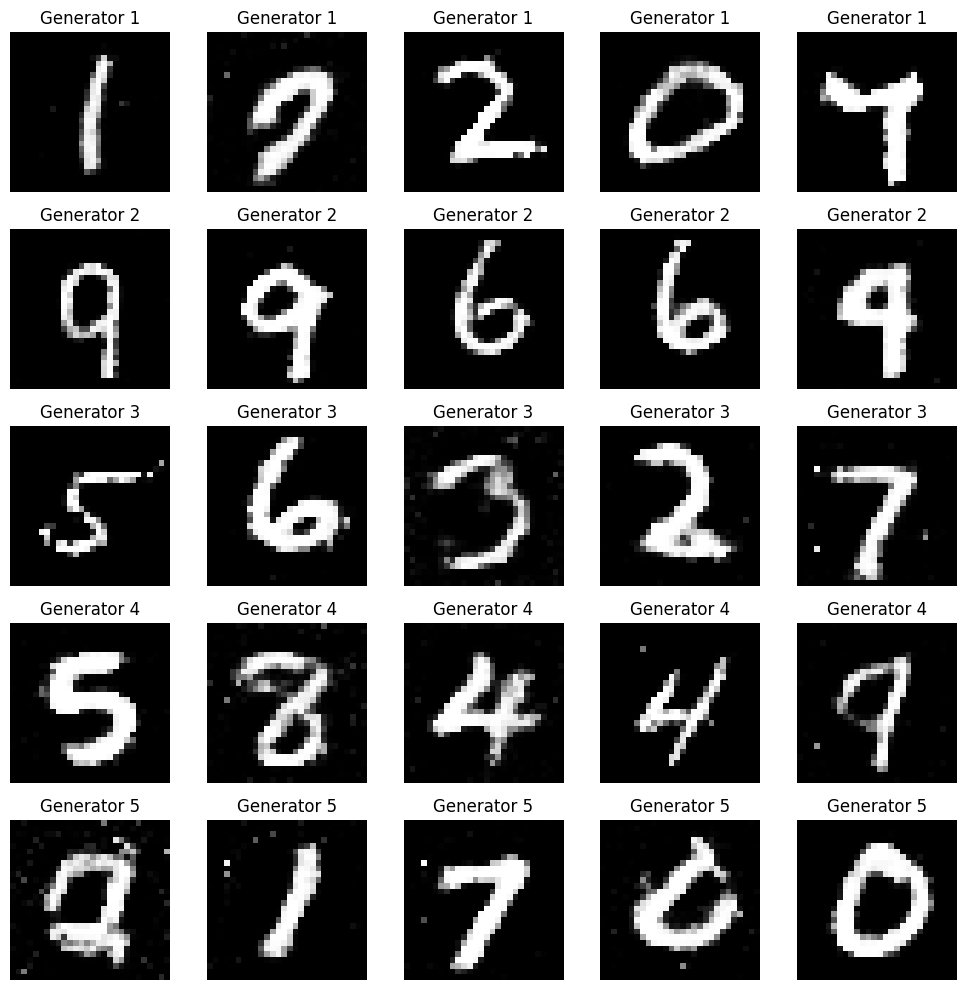

Epoch [91/100], Batch [0/188], D Loss: 1.3185, C Loss: 0.8049, G Loss: -0.0118
Epoch [91/100], Batch [100/188], D Loss: 1.3614, C Loss: 0.8045, G Loss: -0.1597
Epoch [92/100], Batch [0/188], D Loss: 1.3658, C Loss: 0.8050, G Loss: -0.1675
Epoch [92/100], Batch [100/188], D Loss: 1.3552, C Loss: 0.8051, G Loss: -0.0570
Epoch [93/100], Batch [0/188], D Loss: 1.3520, C Loss: 0.8045, G Loss: -0.0309
Epoch [93/100], Batch [100/188], D Loss: 1.3592, C Loss: 0.8045, G Loss: -0.0911
Epoch [94/100], Batch [0/188], D Loss: 1.3499, C Loss: 0.8044, G Loss: -0.0444
Epoch [94/100], Batch [100/188], D Loss: 1.3589, C Loss: 0.8039, G Loss: -0.0473
Epoch [95/100], Batch [0/188], D Loss: 1.3487, C Loss: 0.8051, G Loss: -0.0385
Epoch [95/100], Batch [100/188], D Loss: 1.3364, C Loss: 0.8044, G Loss: -0.0336
Generating samples at epoch 95


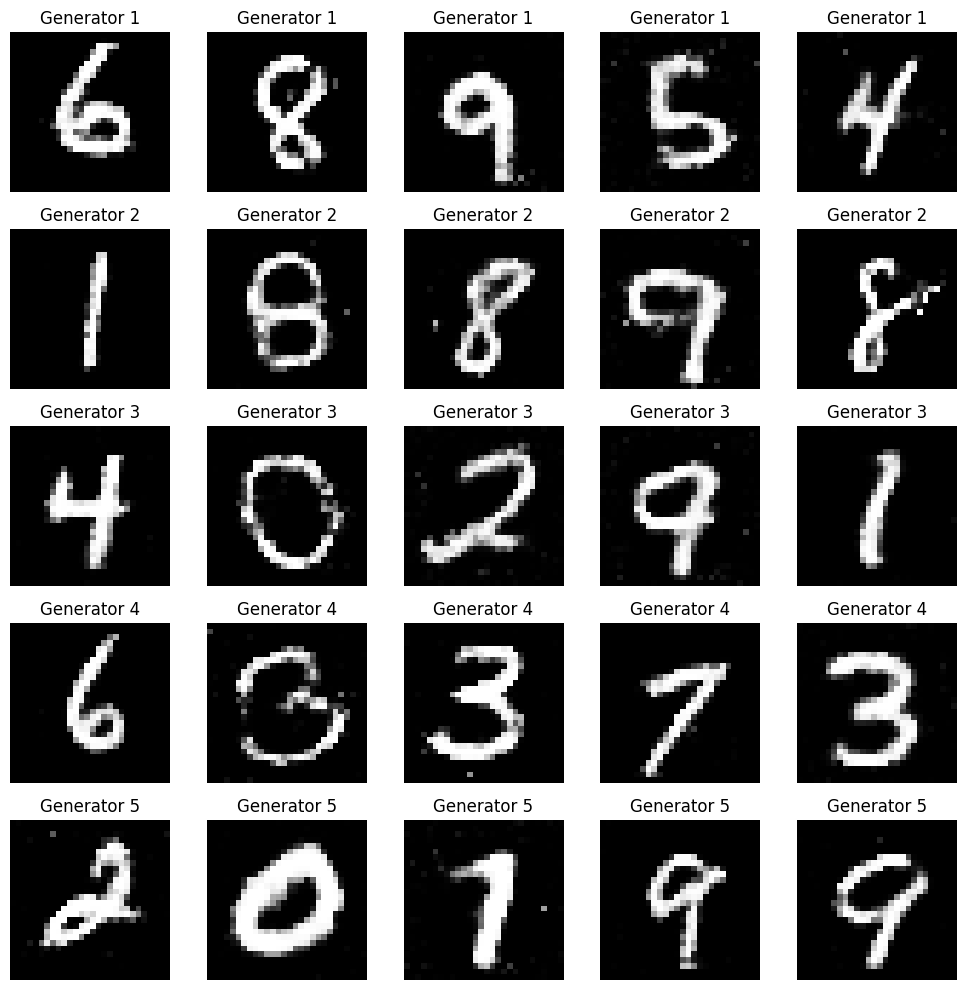

Epoch [96/100], Batch [0/188], D Loss: 1.3591, C Loss: 0.8048, G Loss: -0.0070
Epoch [96/100], Batch [100/188], D Loss: 1.3538, C Loss: 0.8053, G Loss: -0.0433
Epoch [97/100], Batch [0/188], D Loss: 1.3669, C Loss: 0.8047, G Loss: 0.0531
Epoch [97/100], Batch [100/188], D Loss: 1.3568, C Loss: 0.8049, G Loss: -0.0557
Epoch [98/100], Batch [0/188], D Loss: 1.3629, C Loss: 0.8046, G Loss: -0.0660
Epoch [98/100], Batch [100/188], D Loss: 1.3432, C Loss: 0.8048, G Loss: -0.1017
Epoch [99/100], Batch [0/188], D Loss: 1.3672, C Loss: 0.8050, G Loss: -0.0199
Epoch [99/100], Batch [100/188], D Loss: 1.3621, C Loss: 0.8048, G Loss: -0.0263
Epoch [100/100], Batch [0/188], D Loss: 1.3628, C Loss: 0.8045, G Loss: -0.0935
Epoch [100/100], Batch [100/188], D Loss: 1.3814, C Loss: 0.8056, G Loss: -0.0978
Generating samples at epoch 100


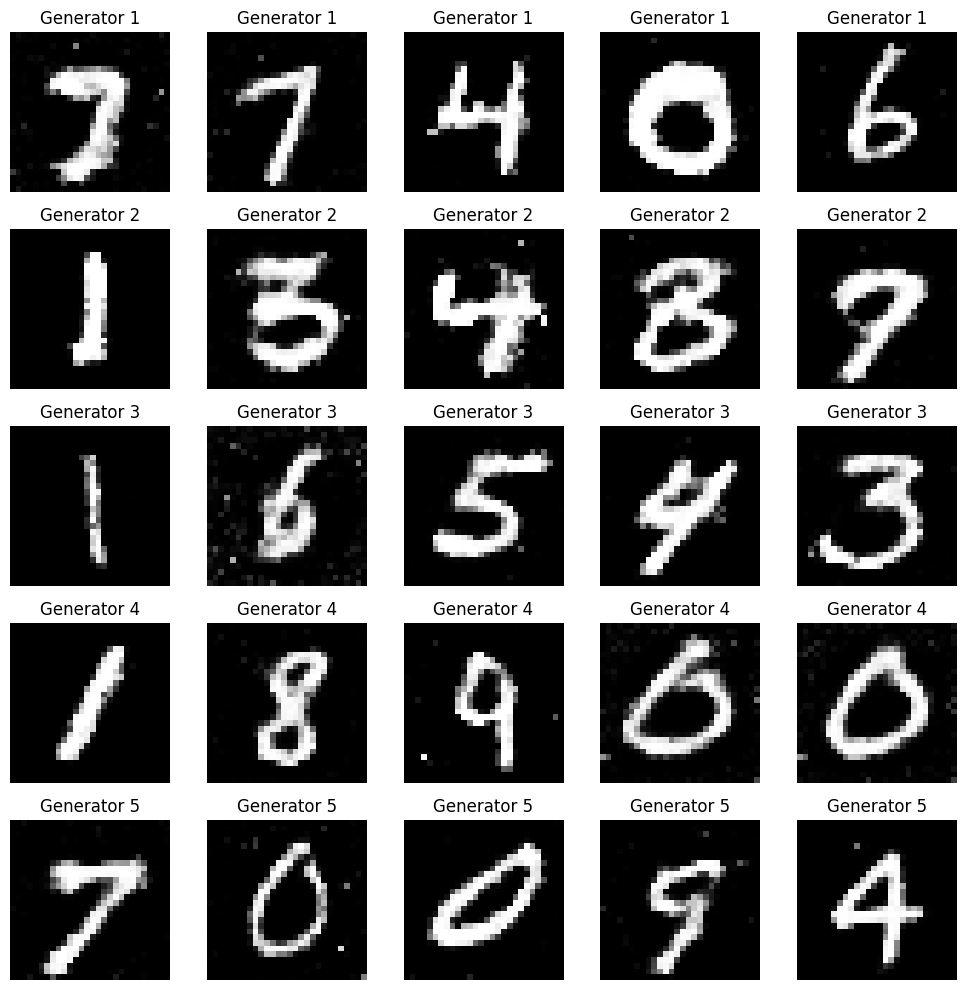

In [31]:

# Initialize models
shared_generator_layers = SharedGeneratorLayers().to(device)
shared_disc_class_layers = SharedDiscriminatorClassifierLayers().to(device)

generators = [Generator(latent_dim, shared_generator_layers).to(device) for _ in range(num_generators)]
discriminator = Discriminator(shared_disc_class_layers).to(device)
classifier = Classifier(shared_disc_class_layers, num_generators).to(device)

# Train the model
history = train_mgans(generators, discriminator, classifier, train_loader, latent_dim, num_epochs, beta, device, visualize_frequency)


In [12]:
def set_requires_grad(model, value):
    for param in model.parameters():
        param.requires_grad = value


In [13]:
class Classifier(nn.Module):
    def __init__(self, num_generators):
        super(Classifier, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
        )
        self.fc = nn.Linear(256, num_generators)

    def forward(self, x):
        x = self.main(x)
        x = self.fc(x)
        return x


In [14]:
def train_mgans_new(generators, discriminator, classifier, train_loader, latent_dim, num_epochs, beta, device, visualize_frequency):
    criterion_bce = nn.BCELoss()
    criterion_ce = nn.CrossEntropyLoss()

    # Collect generator parameters
    gen_params = []
    for gen in generators:
        gen_params += list(gen.fc.parameters())
    gen_params += list(generators[0].shared_layers.parameters())  # Shared layers are the same

    optimizer_G = optim.Adam(gen_params, lr=0.0002, betas=(0.5, 0.999))

    # Discriminator parameters
    discriminator_params = list(discriminator.shared_layers.parameters()) + \
                           list(discriminator.fc.parameters())
    optimizer_D = optim.Adam(discriminator_params, lr=0.0002, betas=(0.5, 0.999))

    # Classifier parameters
    classifier_params = list(classifier.main.parameters()) + \
                        list(classifier.fc.parameters())
    optimizer_C = optim.Adam(classifier_params, lr=0.001, betas=(0.5, 0.999))

    # History to track losses
    history = {'d_loss': [], 'g_loss': [], 'c_loss': []}

    for epoch in range(num_epochs):
        for batch_idx, (real_images, _) in enumerate(train_loader):
            # Prepare real images
            real_images = real_images.view(-1, 28 * 28).to(device)
            batch_size_real = real_images.size(0)

            # Labels for real images
            real_labels = torch.ones(batch_size_real, 1).to(device)

            # ---------------------
            #  Train Discriminator
            # ---------------------
            optimizer_D.zero_grad()

            # Discriminator loss on real images
            outputs = discriminator(real_images)
            d_loss_real = criterion_bce(outputs, real_labels)

            # Prepare fake images and labels
            fake_images_list = []
            fake_labels_list = []
            batch_size_fake = batch_size_real  # For each generator

            for idx, gen in enumerate(generators):
                z = torch.randn(batch_size_fake, latent_dim).to(device)
                fake_images = gen(z)
                fake_images_list.append(fake_images)
                fake_labels_list.append(torch.full((batch_size_fake,), idx, dtype=torch.long))

            # Concatenate fake images and labels
            fake_images = torch.cat(fake_images_list, dim=0)
            fake_labels = torch.cat(fake_labels_list, dim=0).to(device)

            # Labels for fake images for discriminator
            fake_labels_dis = torch.zeros(fake_images.size(0), 1).to(device)

            # Discriminator loss on fake images
            outputs = discriminator(fake_images.detach())
            d_loss_fake = criterion_bce(outputs, fake_labels_dis)

            # Total discriminator loss
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_D.step()

            # -----------------
            #  Train Classifier
            # -----------------
            optimizer_C.zero_grad()
            outputs = classifier(fake_images.detach())
            c_loss = beta * criterion_ce(outputs, fake_labels)
            c_loss.backward()
            optimizer_C.step()
            # -----------------
            #  Train Generators
            # -----------------
            optimizer_G.zero_grad()

            # Generator adversarial loss
            outputs = discriminator(fake_images)
            real_labels_gen = torch.ones(fake_images.size(0), 1).to(device)
            g_loss_adv = criterion_bce(outputs, real_labels_gen)

            # Generator classification loss
            outputs = classifier(fake_images)
            g_loss_cls = criterion_ce(outputs, fake_labels)

            # Total generator loss
            g_loss = g_loss_adv - beta * g_loss_cls
            g_loss.backward()
            optimizer_G.step()

            if batch_idx % 100 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], '
                      f'D Loss: {d_loss.item():.4f}, C Loss: {c_loss.item():.4f}, G Loss: {g_loss.item():.4f}')

            # Save losses
            history['d_loss'].append(d_loss.item())
            history['g_loss'].append(g_loss.item())
            history['c_loss'].append(c_loss.item())

        # Visualize every few epochs
        if (epoch + 1) % visualize_frequency == 0:
            print(f'Generating samples at epoch {epoch + 1}')
            generate_and_plot(generators, latent_dim, device)

    return history


In [17]:
# Hyperparameters
batch_size = 64
num_epochs = 100
learning_rate = 0.0002
latent_dim = 100
num_generators = 5
beta = 0.5  # Diversity hyperparameter
visualize_frequency = 3

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Epoch [1/100], Batch [0/188], D Loss: 1.3943, C Loss: 0.8055, G Loss: -0.0898
Epoch [1/100], Batch [100/188], D Loss: 1.1585, C Loss: 0.8065, G Loss: 0.5745
Epoch [2/100], Batch [0/188], D Loss: 0.9760, C Loss: 0.8040, G Loss: 0.6363
Epoch [2/100], Batch [100/188], D Loss: 0.9409, C Loss: 0.8045, G Loss: 0.9047
Epoch [3/100], Batch [0/188], D Loss: 0.8060, C Loss: 0.8050, G Loss: 0.9058
Epoch [3/100], Batch [100/188], D Loss: 0.9784, C Loss: 0.8044, G Loss: 0.8850
Generating samples at epoch 3


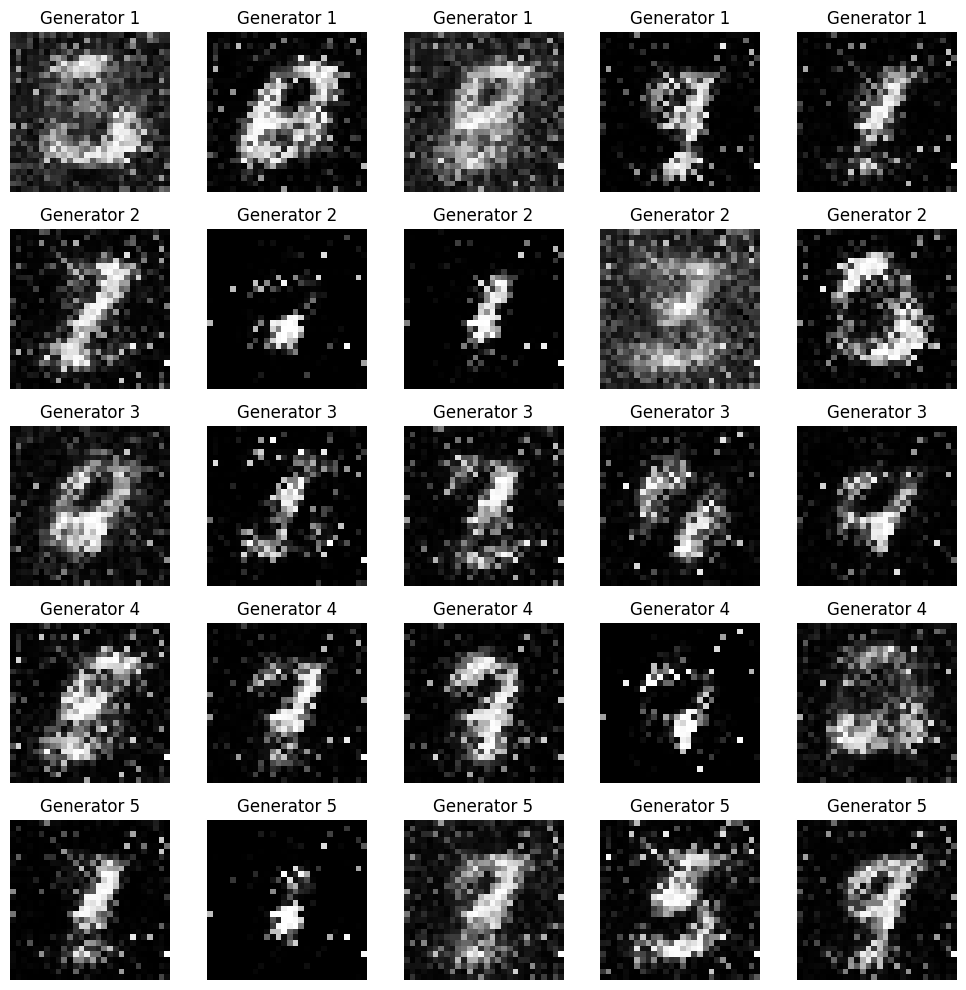

Epoch [4/100], Batch [0/188], D Loss: 0.8192, C Loss: 0.8049, G Loss: 1.0907
Epoch [4/100], Batch [100/188], D Loss: 1.1336, C Loss: 0.8042, G Loss: 0.3700
Epoch [5/100], Batch [0/188], D Loss: 0.9030, C Loss: 0.8045, G Loss: 0.5386
Epoch [5/100], Batch [100/188], D Loss: 0.9613, C Loss: 0.8045, G Loss: 0.5918
Epoch [6/100], Batch [0/188], D Loss: 0.9182, C Loss: 0.8048, G Loss: 0.9530
Epoch [6/100], Batch [100/188], D Loss: 1.1270, C Loss: 0.8056, G Loss: 0.6332
Generating samples at epoch 6


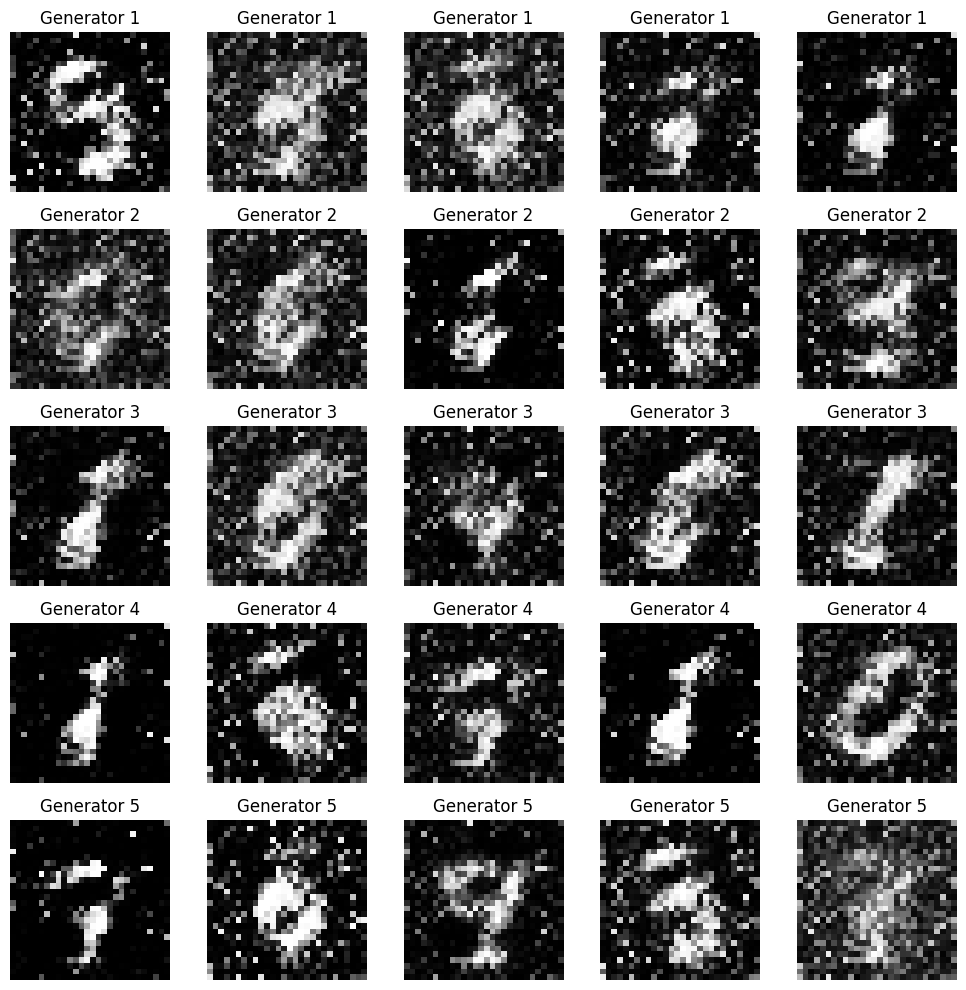

Epoch [7/100], Batch [0/188], D Loss: 0.9287, C Loss: 0.8060, G Loss: 1.0848
Epoch [7/100], Batch [100/188], D Loss: 0.8782, C Loss: 0.8053, G Loss: 1.4929
Epoch [8/100], Batch [0/188], D Loss: 0.9475, C Loss: 0.8047, G Loss: 0.8254
Epoch [8/100], Batch [100/188], D Loss: 0.9851, C Loss: 0.8051, G Loss: 0.3399
Epoch [9/100], Batch [0/188], D Loss: 0.9056, C Loss: 0.8059, G Loss: 0.7060
Epoch [9/100], Batch [100/188], D Loss: 0.8259, C Loss: 0.8048, G Loss: 0.6248
Generating samples at epoch 9


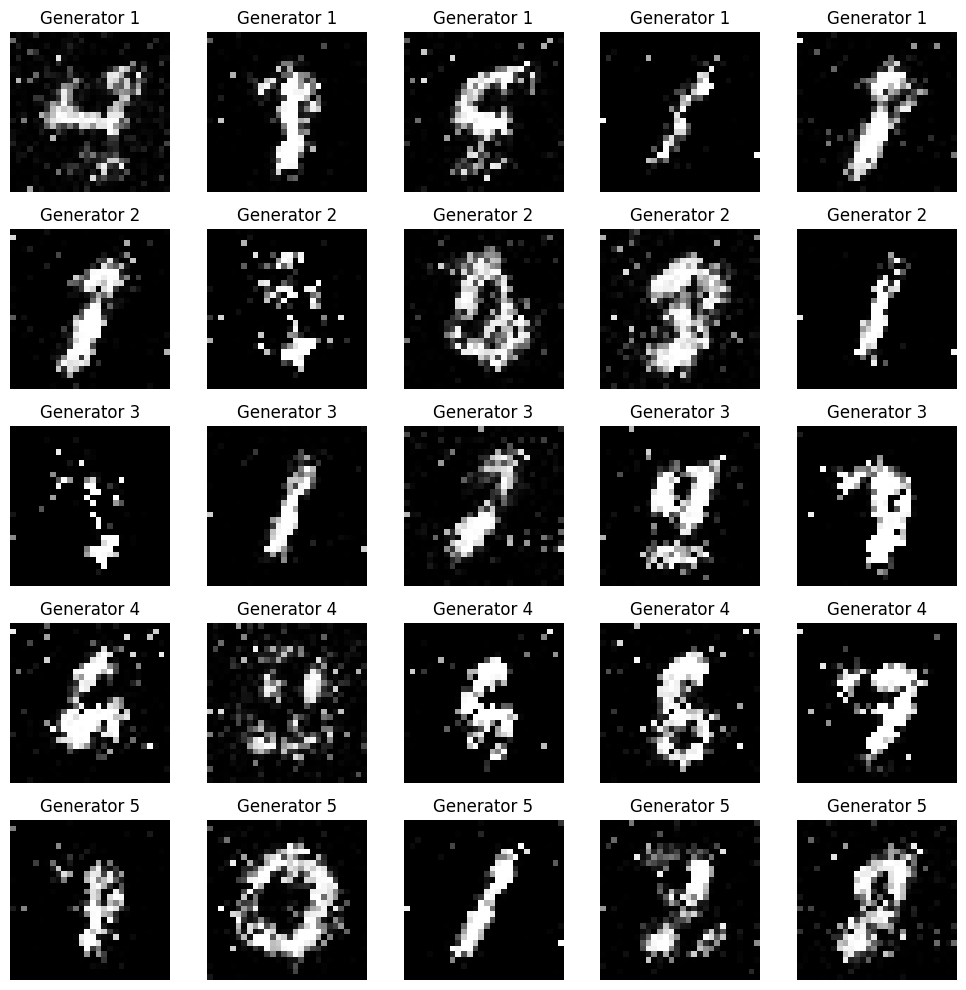

Epoch [10/100], Batch [0/188], D Loss: 0.9357, C Loss: 0.8051, G Loss: 0.5155
Epoch [10/100], Batch [100/188], D Loss: 1.0947, C Loss: 0.8051, G Loss: 0.4521
Epoch [11/100], Batch [0/188], D Loss: 1.0978, C Loss: 0.8054, G Loss: 0.9669
Epoch [11/100], Batch [100/188], D Loss: 1.1067, C Loss: 0.8052, G Loss: 0.7849
Epoch [12/100], Batch [0/188], D Loss: 1.0527, C Loss: 4.2376, G Loss: -238.9154
Epoch [12/100], Batch [100/188], D Loss: 0.0026, C Loss: 0.8747, G Loss: 6.2676
Generating samples at epoch 12


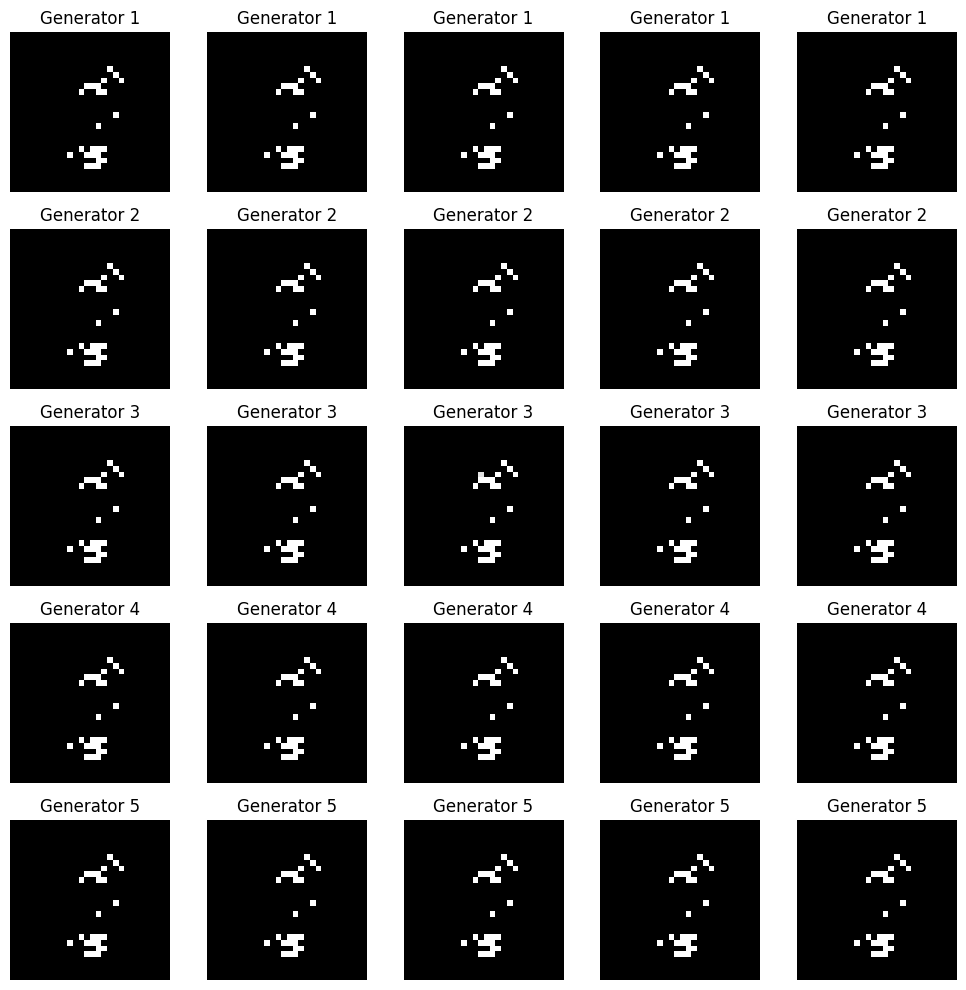

Epoch [13/100], Batch [0/188], D Loss: 0.0012, C Loss: 0.8490, G Loss: 7.5786
Epoch [13/100], Batch [100/188], D Loss: 0.0006, C Loss: 0.8321, G Loss: 8.0339
Epoch [14/100], Batch [0/188], D Loss: 0.0018, C Loss: 0.8205, G Loss: 6.7705
Epoch [14/100], Batch [100/188], D Loss: 0.0009, C Loss: 0.8123, G Loss: 7.3552
Epoch [15/100], Batch [0/188], D Loss: 0.0007, C Loss: 0.8109, G Loss: 7.6213
Epoch [15/100], Batch [100/188], D Loss: 0.0002, C Loss: 0.8116, G Loss: 9.0290
Generating samples at epoch 15


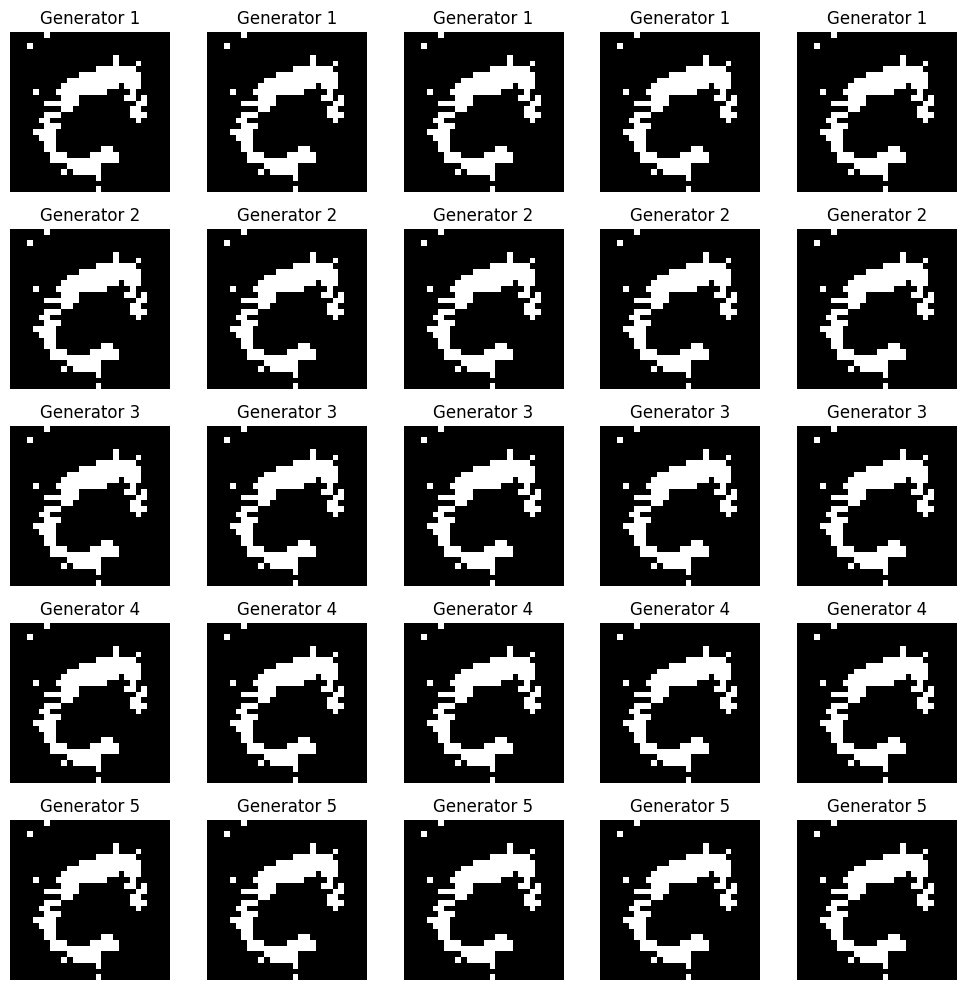

Epoch [16/100], Batch [0/188], D Loss: 0.0002, C Loss: 0.8077, G Loss: 9.1139
Epoch [16/100], Batch [100/188], D Loss: 0.0001, C Loss: 0.8114, G Loss: 9.3791
Epoch [17/100], Batch [0/188], D Loss: 0.0001, C Loss: 0.8084, G Loss: 9.8170
Epoch [17/100], Batch [100/188], D Loss: 0.0003, C Loss: 0.8113, G Loss: 10.4599
Epoch [18/100], Batch [0/188], D Loss: 0.0001, C Loss: 0.8069, G Loss: 10.2947
Epoch [18/100], Batch [100/188], D Loss: 0.0001, C Loss: 0.8079, G Loss: 9.5921
Generating samples at epoch 18


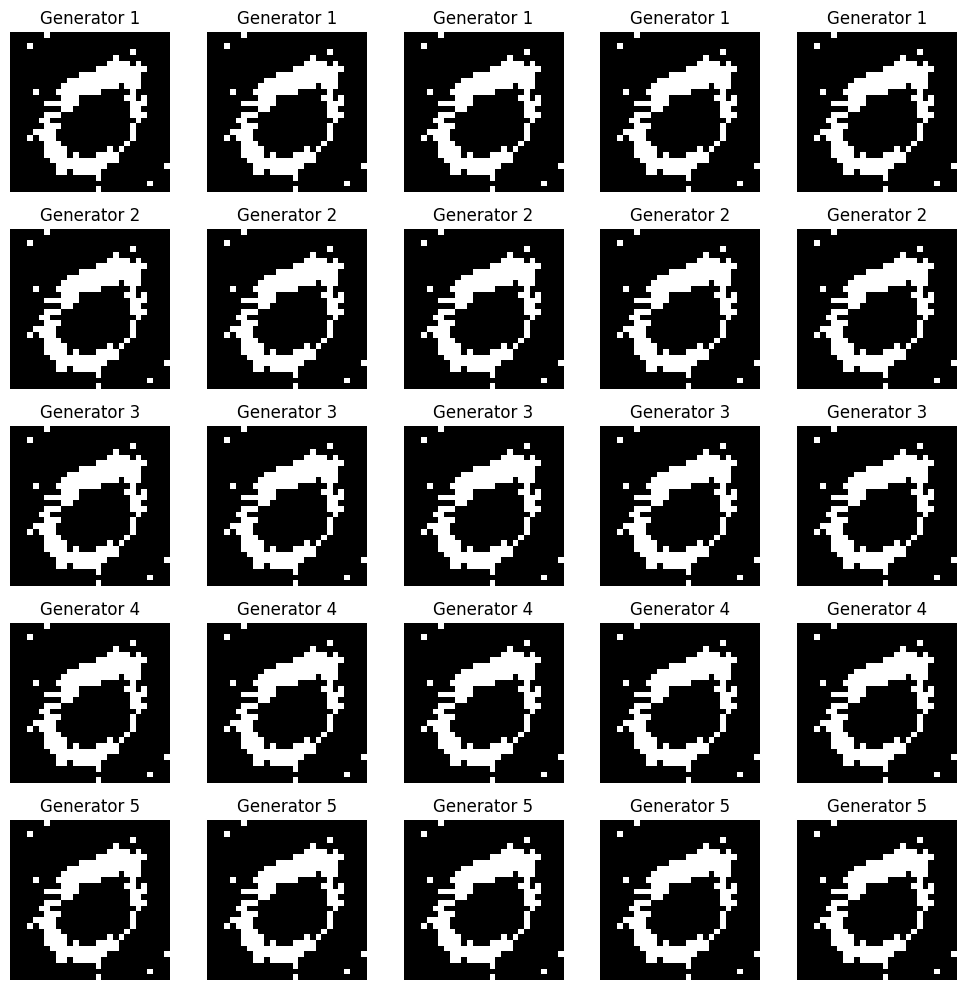

Epoch [19/100], Batch [0/188], D Loss: 0.0002, C Loss: 0.8094, G Loss: 9.3131
Epoch [19/100], Batch [100/188], D Loss: 0.0001, C Loss: 0.8073, G Loss: 9.7195
Epoch [20/100], Batch [0/188], D Loss: 0.0000, C Loss: 0.8087, G Loss: 10.5107
Epoch [20/100], Batch [100/188], D Loss: 0.0001, C Loss: 0.8047, G Loss: 10.5901
Epoch [21/100], Batch [0/188], D Loss: 0.0000, C Loss: 0.8090, G Loss: 10.9720
Epoch [21/100], Batch [100/188], D Loss: 0.0000, C Loss: 0.8050, G Loss: 10.6749
Generating samples at epoch 21


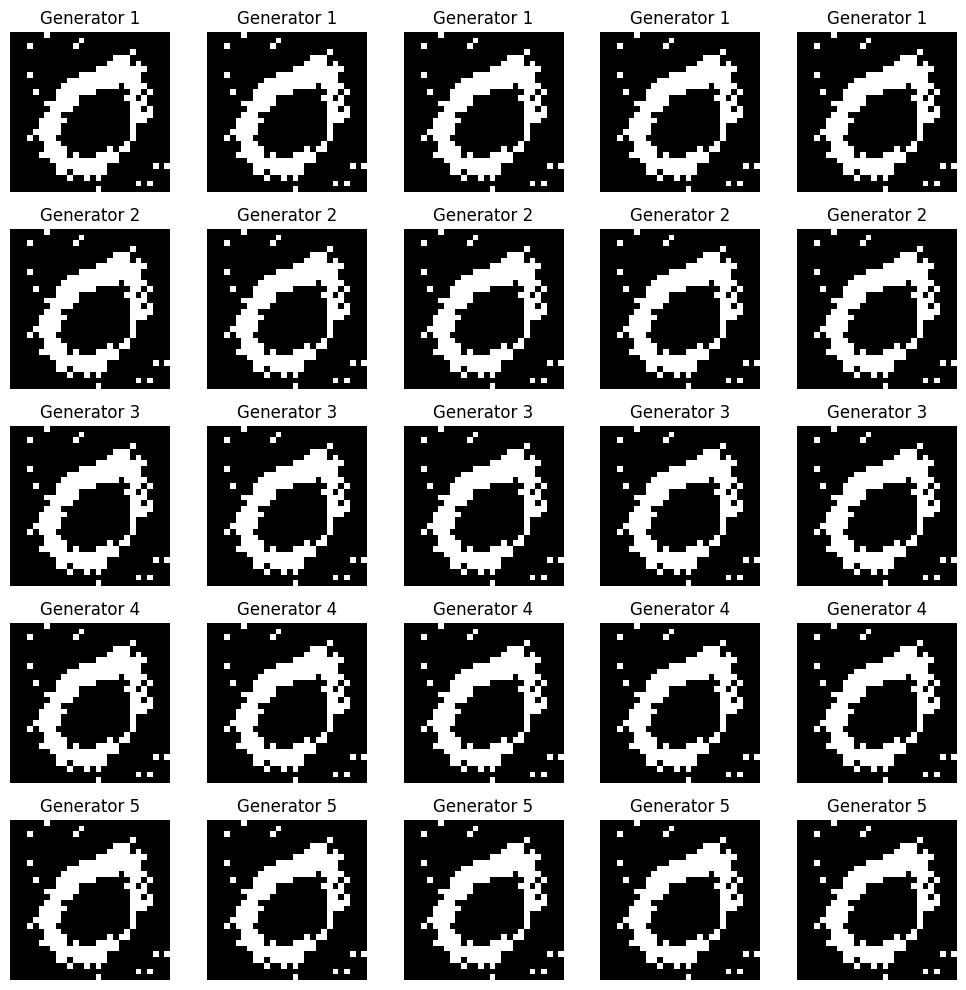

Epoch [22/100], Batch [0/188], D Loss: 0.0000, C Loss: 0.8069, G Loss: 11.4079
Epoch [22/100], Batch [100/188], D Loss: 0.0000, C Loss: 0.8062, G Loss: 11.3042
Epoch [23/100], Batch [0/188], D Loss: 0.0000, C Loss: 0.8077, G Loss: 11.4712
Epoch [23/100], Batch [100/188], D Loss: 0.0000, C Loss: 0.8057, G Loss: 11.3309
Epoch [24/100], Batch [0/188], D Loss: 0.0000, C Loss: 0.8043, G Loss: 11.5583
Epoch [24/100], Batch [100/188], D Loss: 0.0000, C Loss: 0.8063, G Loss: 12.1684
Generating samples at epoch 24


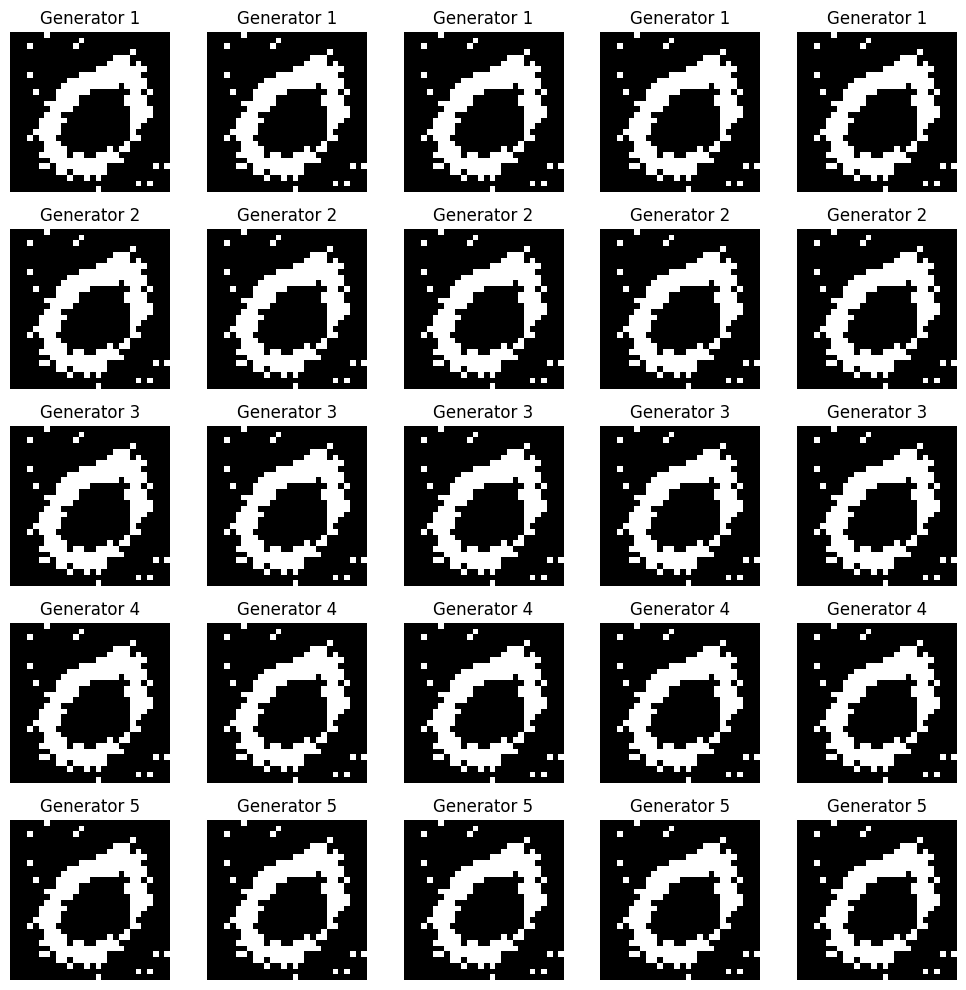

Epoch [25/100], Batch [0/188], D Loss: 0.0000, C Loss: 0.8053, G Loss: 12.3068
Epoch [25/100], Batch [100/188], D Loss: 0.0000, C Loss: 0.8060, G Loss: 11.7866
Epoch [26/100], Batch [0/188], D Loss: 0.0000, C Loss: 0.8062, G Loss: 12.3394
Epoch [26/100], Batch [100/188], D Loss: 0.0000, C Loss: 0.8061, G Loss: 12.3751
Epoch [27/100], Batch [0/188], D Loss: 0.0000, C Loss: 0.8059, G Loss: 12.5681
Epoch [27/100], Batch [100/188], D Loss: 0.0000, C Loss: 0.8077, G Loss: 12.8001
Generating samples at epoch 27


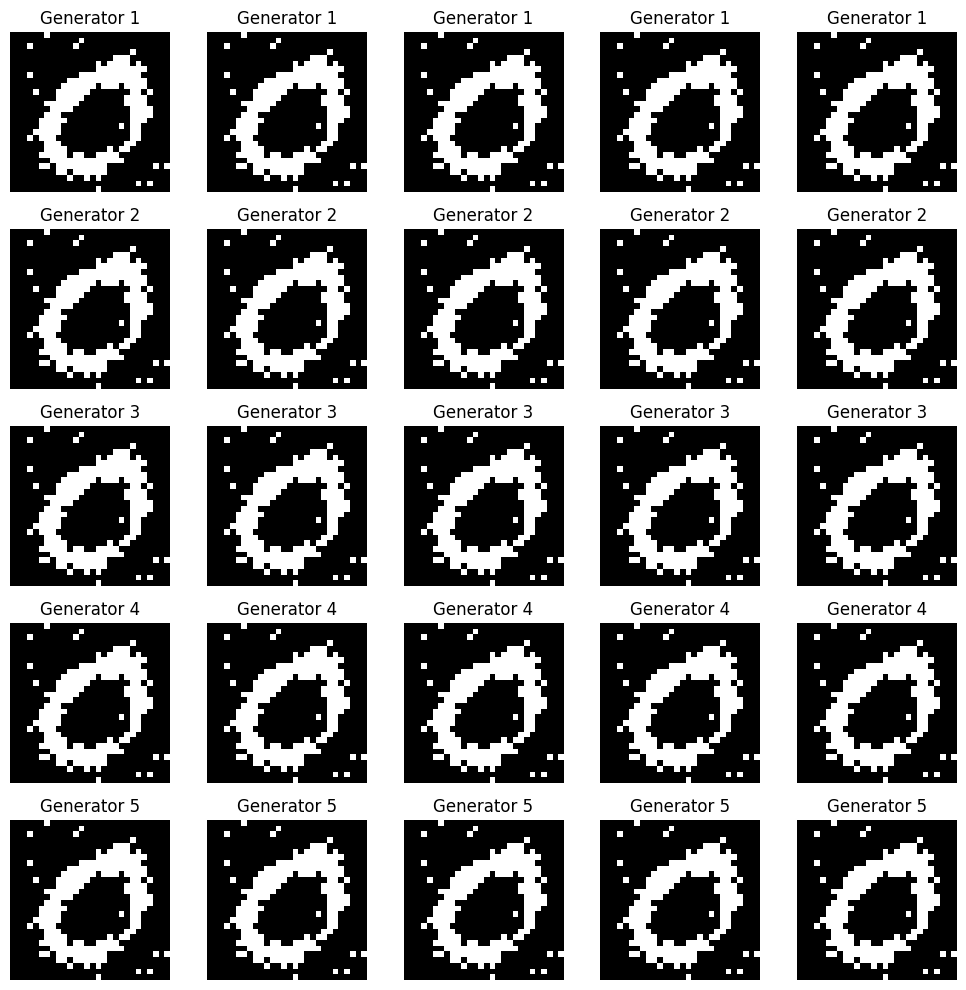

Epoch [28/100], Batch [0/188], D Loss: 0.0000, C Loss: 0.8061, G Loss: 12.3948
Epoch [28/100], Batch [100/188], D Loss: 0.0000, C Loss: 0.8055, G Loss: 11.5323
Epoch [29/100], Batch [0/188], D Loss: 0.0000, C Loss: 0.8054, G Loss: 11.9510
Epoch [29/100], Batch [100/188], D Loss: 0.0000, C Loss: 0.8054, G Loss: 12.2819
Epoch [30/100], Batch [0/188], D Loss: 0.0000, C Loss: 0.8058, G Loss: 12.0933
Epoch [30/100], Batch [100/188], D Loss: 0.0000, C Loss: 0.8059, G Loss: 12.8527
Generating samples at epoch 30


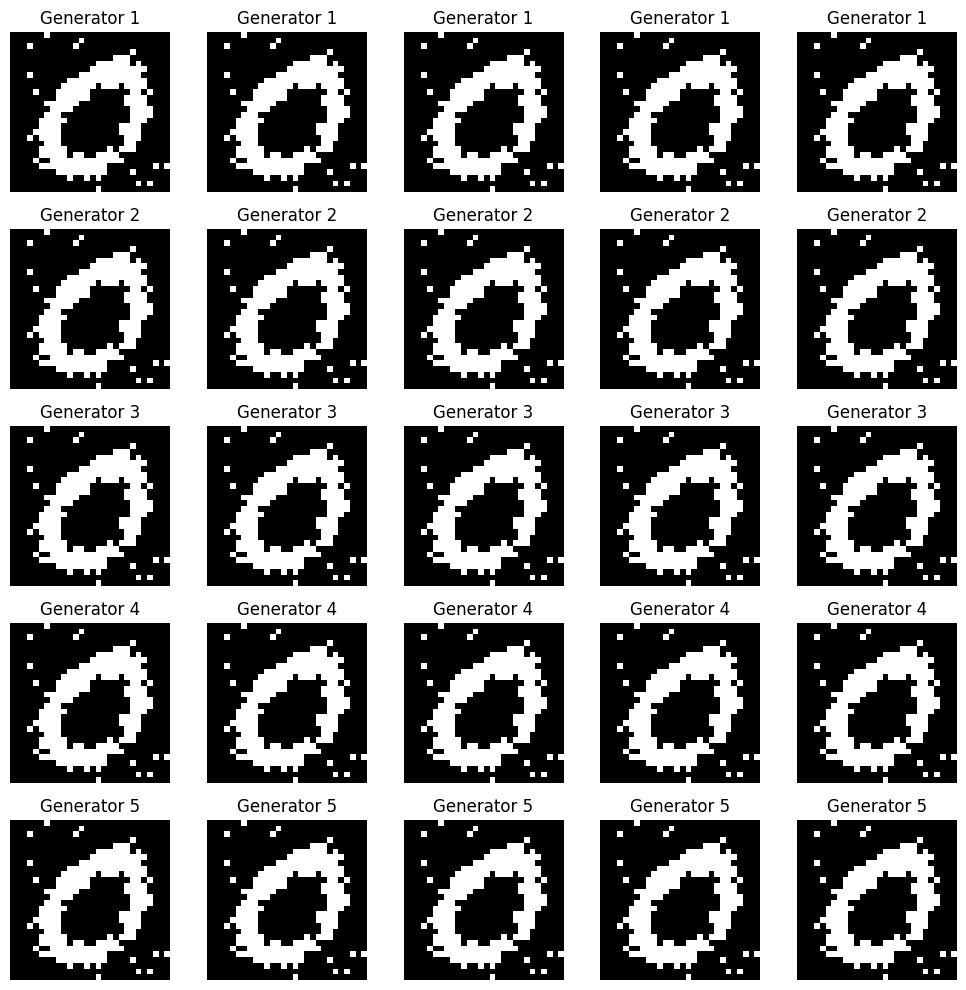

Epoch [31/100], Batch [0/188], D Loss: 0.0000, C Loss: 0.8061, G Loss: 12.4717
Epoch [31/100], Batch [100/188], D Loss: 0.0000, C Loss: 0.8053, G Loss: 12.9010
Epoch [32/100], Batch [0/188], D Loss: 0.0000, C Loss: 0.8055, G Loss: 11.6852
Epoch [32/100], Batch [100/188], D Loss: 0.0000, C Loss: 0.8053, G Loss: 12.9932
Epoch [33/100], Batch [0/188], D Loss: 0.0000, C Loss: 0.8057, G Loss: 13.0576
Epoch [33/100], Batch [100/188], D Loss: 0.0000, C Loss: 0.8053, G Loss: 12.9089
Generating samples at epoch 33


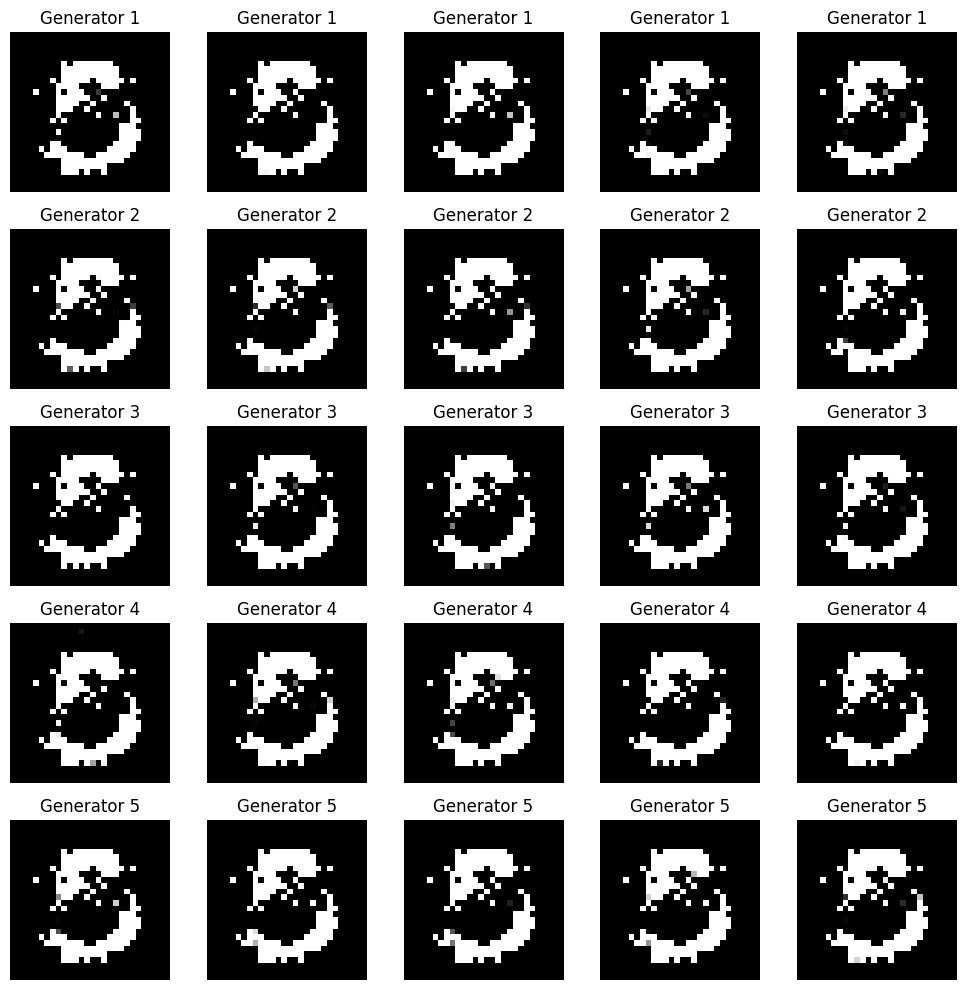

Epoch [34/100], Batch [0/188], D Loss: 100.0000, C Loss: 0.8084, G Loss: -0.8069
Epoch [34/100], Batch [100/188], D Loss: 100.0000, C Loss: 0.8067, G Loss: -0.8051
Epoch [35/100], Batch [0/188], D Loss: 100.0000, C Loss: 0.8064, G Loss: -0.8071
Epoch [35/100], Batch [100/188], D Loss: 100.0000, C Loss: 0.8053, G Loss: -0.8071
Epoch [36/100], Batch [0/188], D Loss: 100.0000, C Loss: 0.8060, G Loss: -0.8056
Epoch [36/100], Batch [100/188], D Loss: 100.0000, C Loss: 0.8062, G Loss: -0.8064
Generating samples at epoch 36


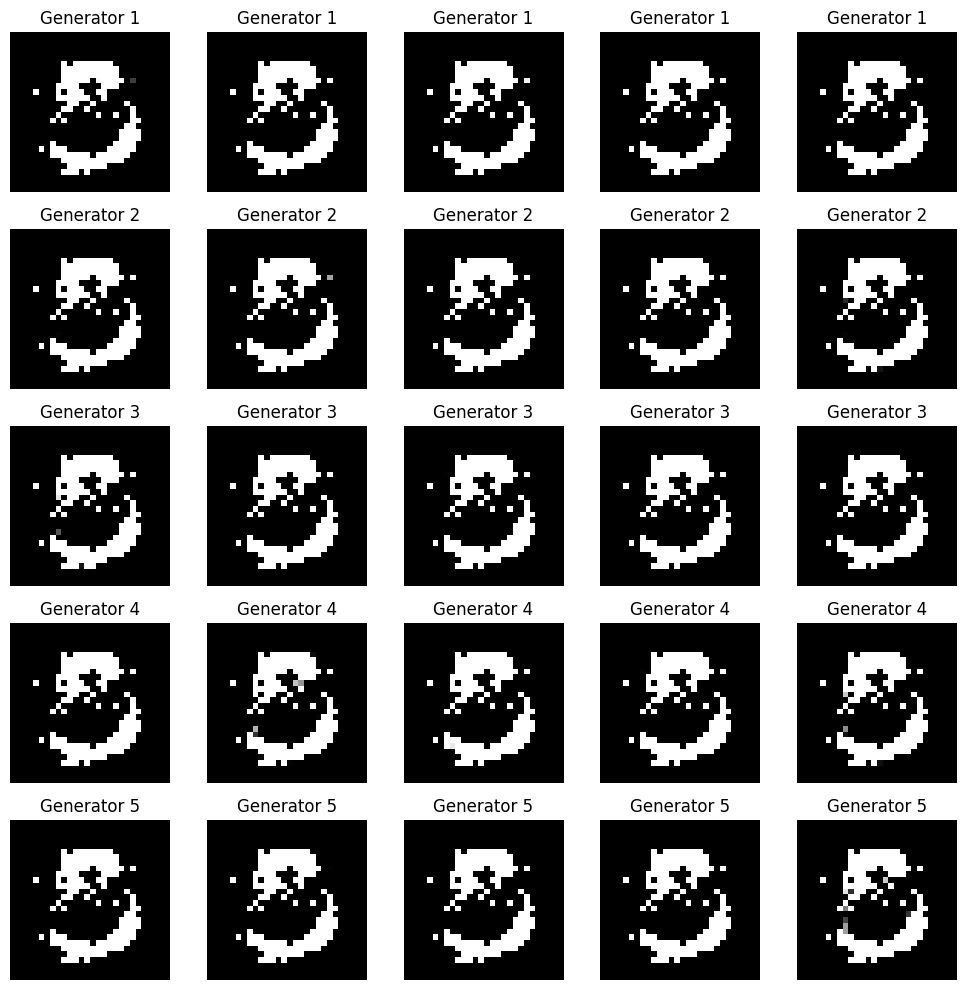

Epoch [37/100], Batch [0/188], D Loss: 100.0000, C Loss: 0.8052, G Loss: -0.8069
Epoch [37/100], Batch [100/188], D Loss: 100.0000, C Loss: 0.8049, G Loss: -0.8055
Epoch [38/100], Batch [0/188], D Loss: 100.0000, C Loss: 0.8048, G Loss: -0.8061
Epoch [38/100], Batch [100/188], D Loss: 100.0000, C Loss: 0.8053, G Loss: -0.8074
Epoch [39/100], Batch [0/188], D Loss: 100.0000, C Loss: 0.8063, G Loss: -0.8060
Epoch [39/100], Batch [100/188], D Loss: 100.0000, C Loss: 0.8037, G Loss: -0.8050
Generating samples at epoch 39


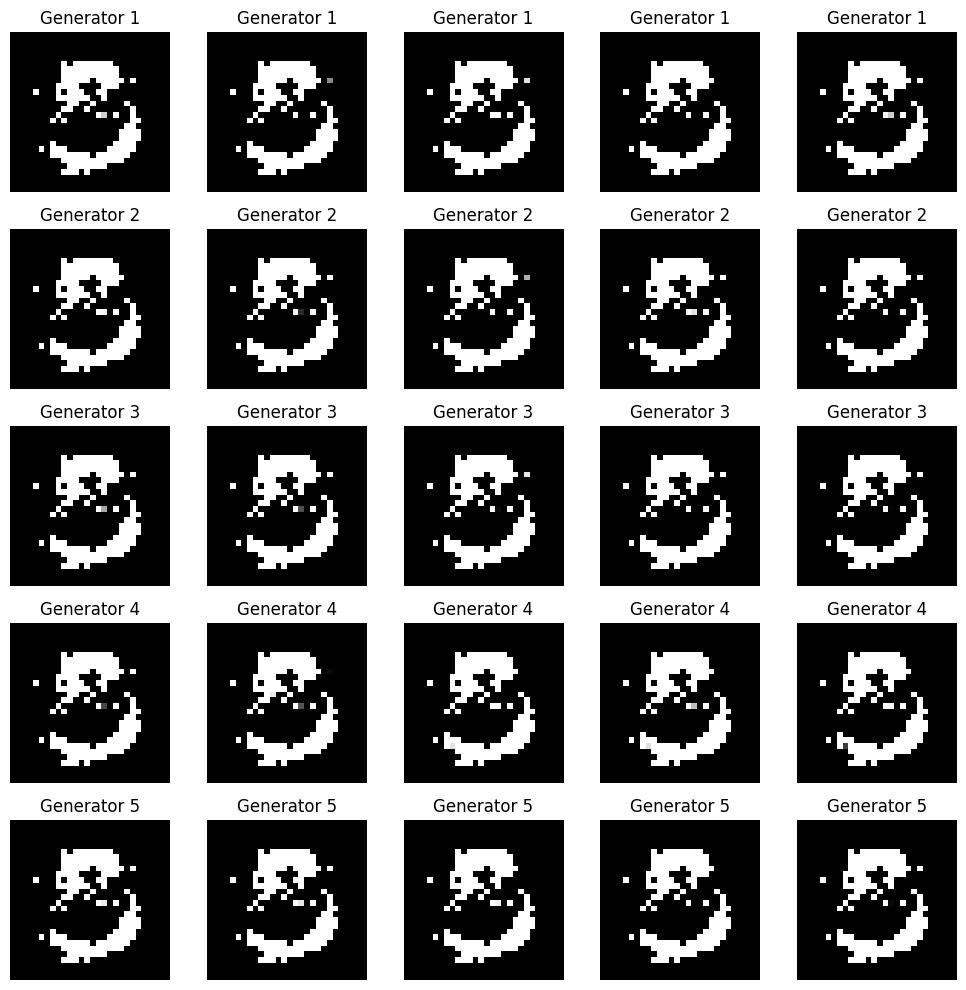

Epoch [40/100], Batch [0/188], D Loss: 100.0000, C Loss: 0.8041, G Loss: -0.8063
Epoch [40/100], Batch [100/188], D Loss: 100.0000, C Loss: 0.8046, G Loss: -0.8053
Epoch [41/100], Batch [0/188], D Loss: 100.0000, C Loss: 0.8045, G Loss: -0.8057
Epoch [41/100], Batch [100/188], D Loss: 100.0000, C Loss: 0.8055, G Loss: -0.8045
Epoch [42/100], Batch [0/188], D Loss: 100.0000, C Loss: 0.8054, G Loss: -0.8040
Epoch [42/100], Batch [100/188], D Loss: 100.0000, C Loss: 0.8053, G Loss: -0.8066
Generating samples at epoch 42


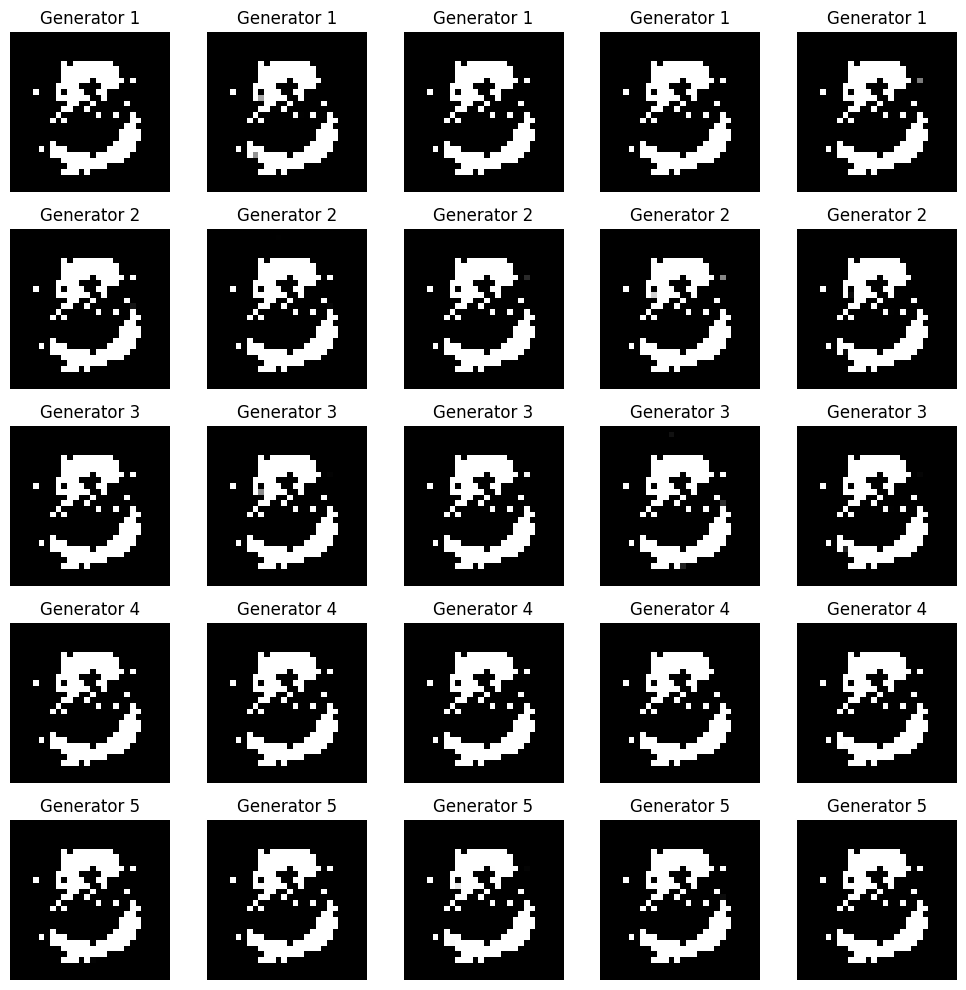

Epoch [43/100], Batch [0/188], D Loss: 100.0000, C Loss: 0.8054, G Loss: -0.8047
Epoch [43/100], Batch [100/188], D Loss: 100.0000, C Loss: 0.8058, G Loss: -0.8040
Epoch [44/100], Batch [0/188], D Loss: 100.0000, C Loss: 0.8061, G Loss: -0.8074
Epoch [44/100], Batch [100/188], D Loss: 100.0000, C Loss: 0.8052, G Loss: -0.8067
Epoch [45/100], Batch [0/188], D Loss: 100.0000, C Loss: 0.8048, G Loss: -0.8054
Epoch [45/100], Batch [100/188], D Loss: 100.0000, C Loss: 0.8047, G Loss: -0.8046
Generating samples at epoch 45


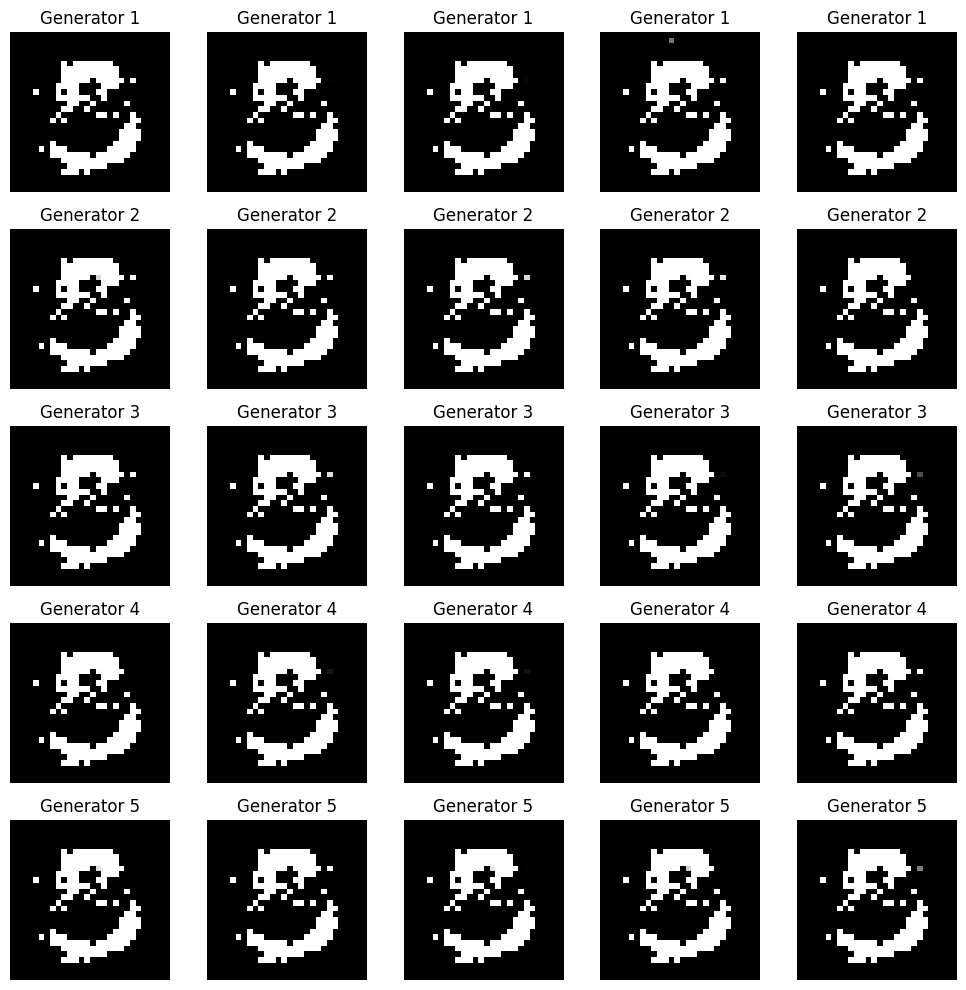

Epoch [46/100], Batch [0/188], D Loss: 100.0000, C Loss: 0.8054, G Loss: -0.8051
Epoch [46/100], Batch [100/188], D Loss: 100.0000, C Loss: 0.8054, G Loss: -0.8055
Epoch [47/100], Batch [0/188], D Loss: 100.0000, C Loss: 0.8049, G Loss: -0.8052
Epoch [47/100], Batch [100/188], D Loss: 100.0000, C Loss: 0.8057, G Loss: -0.8051
Epoch [48/100], Batch [0/188], D Loss: 100.0000, C Loss: 0.8051, G Loss: -0.8048
Epoch [48/100], Batch [100/188], D Loss: 100.0000, C Loss: 0.8049, G Loss: -0.8045
Generating samples at epoch 48


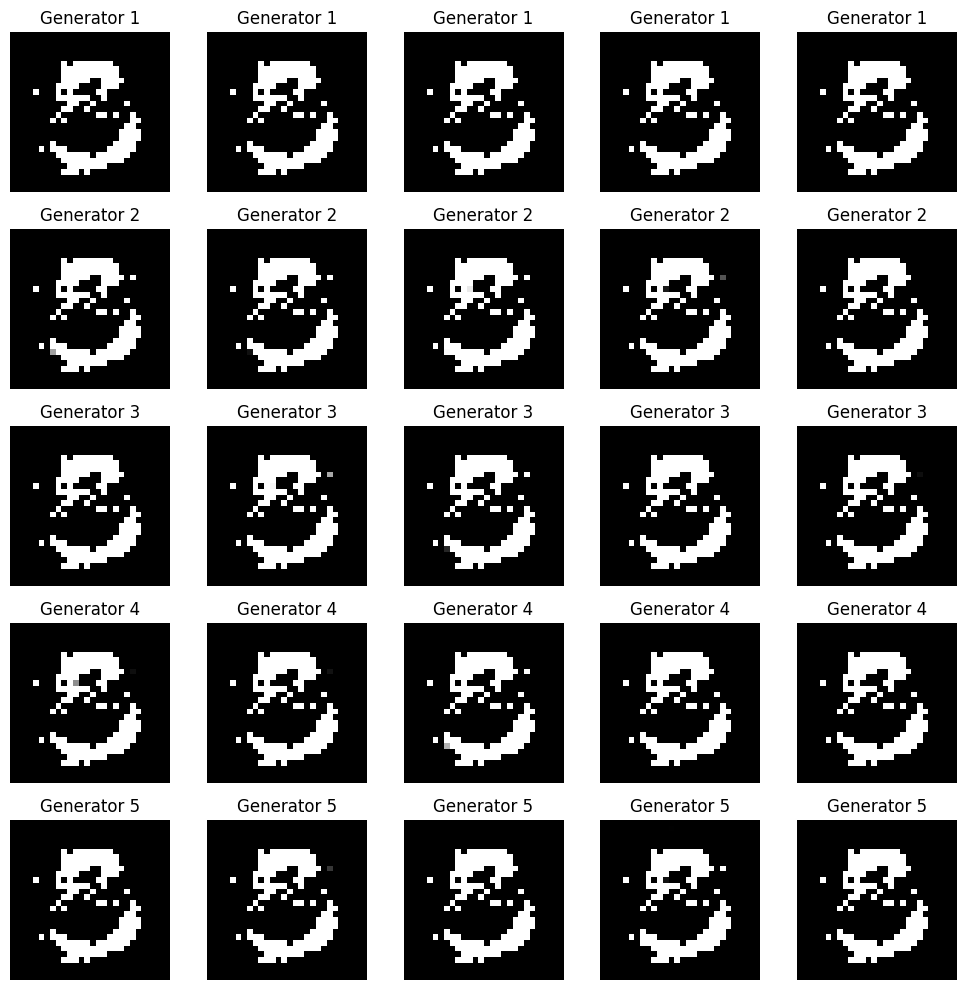

Epoch [49/100], Batch [0/188], D Loss: 100.0000, C Loss: 0.8053, G Loss: -0.8051
Epoch [49/100], Batch [100/188], D Loss: 100.0000, C Loss: 0.8047, G Loss: -0.8054
Epoch [50/100], Batch [0/188], D Loss: 100.0000, C Loss: 0.8059, G Loss: -0.8047
Epoch [50/100], Batch [100/188], D Loss: 100.0000, C Loss: 0.8053, G Loss: -0.8050
Epoch [51/100], Batch [0/188], D Loss: 100.0000, C Loss: 0.8044, G Loss: -0.8058
Epoch [51/100], Batch [100/188], D Loss: 100.0000, C Loss: 0.8090, G Loss: -0.8074
Generating samples at epoch 51


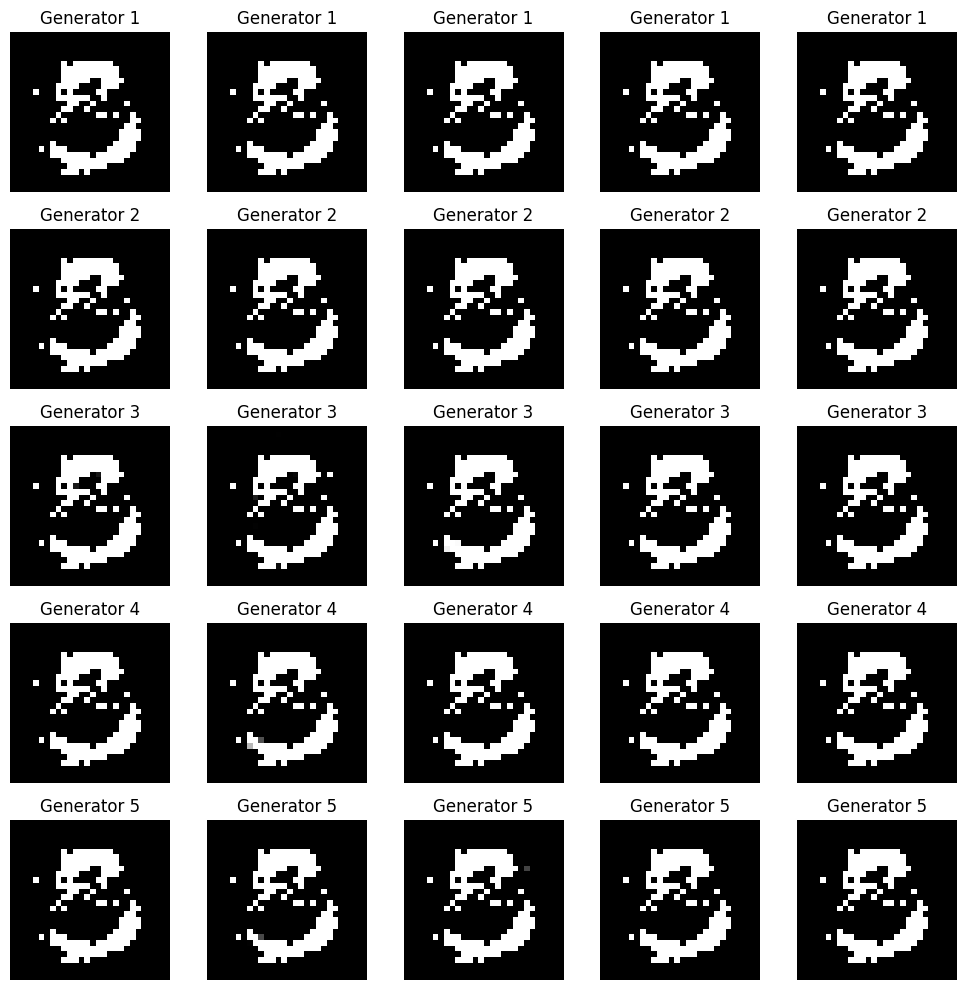

Epoch [52/100], Batch [0/188], D Loss: 100.0000, C Loss: 0.8060, G Loss: -0.8052
Epoch [52/100], Batch [100/188], D Loss: 100.0000, C Loss: 0.8040, G Loss: -0.8066
Epoch [53/100], Batch [0/188], D Loss: 100.0000, C Loss: 0.8048, G Loss: -0.8049
Epoch [53/100], Batch [100/188], D Loss: 100.0000, C Loss: 0.8050, G Loss: -0.8056
Epoch [54/100], Batch [0/188], D Loss: 100.0000, C Loss: 0.8053, G Loss: -0.8054
Epoch [54/100], Batch [100/188], D Loss: 100.0000, C Loss: 0.8051, G Loss: -0.8040
Generating samples at epoch 54


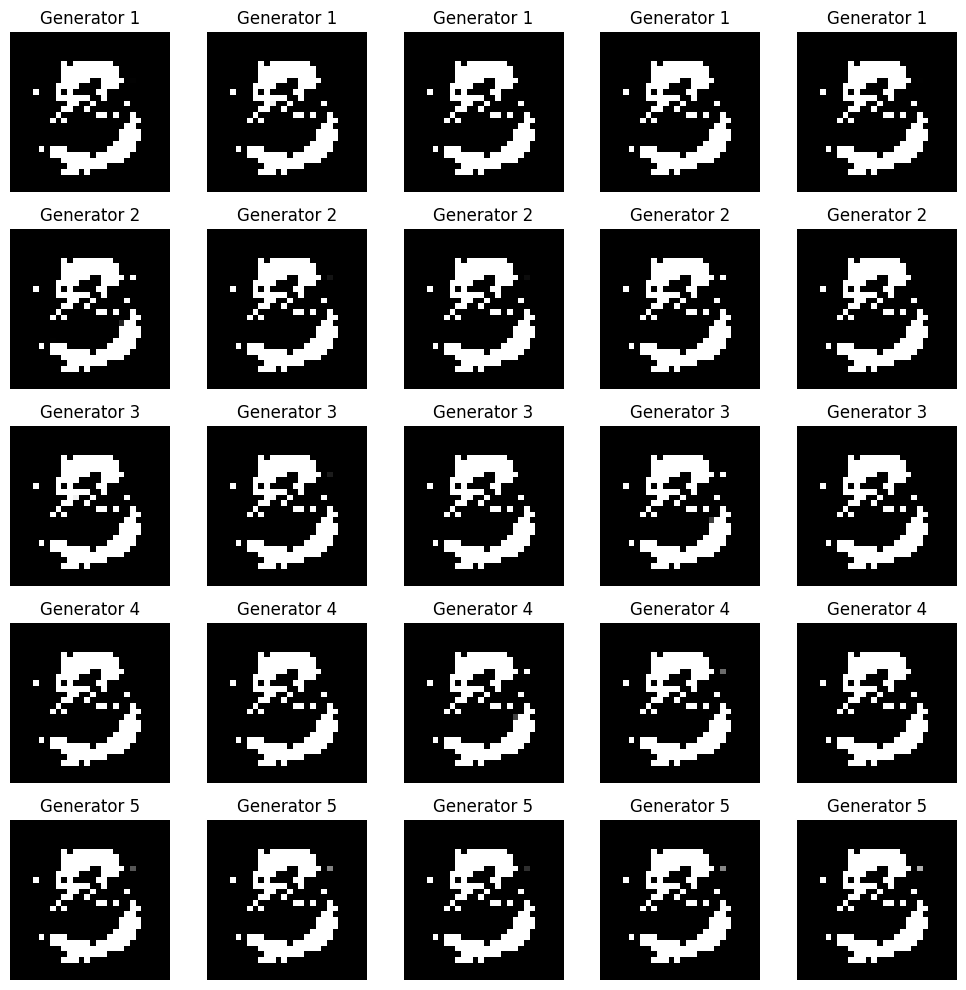

Epoch [55/100], Batch [0/188], D Loss: 100.0000, C Loss: 0.8039, G Loss: -0.8058
Epoch [55/100], Batch [100/188], D Loss: 100.0000, C Loss: 0.8050, G Loss: -0.8052


KeyboardInterrupt: 

In [18]:


# Initialize models
shared_generator_layers = SharedGeneratorLayers().to(device)
discriminator_layers = SharedDiscriminatorClassifierLayers().to(device)

# Initialize generators, discriminator, and classifier separately
generators = [Generator(latent_dim, shared_generator_layers).to(device) for _ in range(num_generators)]
discriminator = Discriminator(discriminator_layers).to(device)
classifier = Classifier(num_generators).to(device)

# Train the model using the new training function
history = train_mgans_new(
    generators, discriminator, classifier, 
    train_loader, latent_dim, num_epochs, 
    beta, device, visualize_frequency
)
